In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)
from transformers import AutoTokenizer, AutoModel

In [2]:
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
 
f.close()

In [3]:
processed_data = [
    {
        "_score": item["_score"],
        "_index": item["_index"],
        "_crawldate": item["_crawldate"],
        "_type": item["_type"],
        "hashtags": item["_source"]["tweet"].get("hashtags", []),
        "tweet_id": item["_source"]["tweet"].get("tweet_id"),
        "text": item["_source"]["tweet"].get("text"),
    }
    for item in data
]
tweets = pd.DataFrame(processed_data)

print(tweets)

         _score          _index           _crawldate   _type  \
0           391  hashtag_tweets  2015-05-23 11:42:47  tweets   
1           433  hashtag_tweets  2016-01-28 04:52:09  tweets   
2           232  hashtag_tweets  2017-12-25 04:39:20  tweets   
3           376  hashtag_tweets  2016-01-24 23:53:05  tweets   
4           989  hashtag_tweets  2016-01-08 17:18:59  tweets   
...         ...             ...                  ...     ...   
1867530     827  hashtag_tweets  2015-05-12 12:51:52  tweets   
1867531     368  hashtag_tweets  2017-10-02 17:54:04  tweets   
1867532     498  hashtag_tweets  2016-10-10 11:04:32  tweets   
1867533     840  hashtag_tweets  2016-09-02 14:25:06  tweets   
1867534     360  hashtag_tweets  2016-11-16 01:40:07  tweets   

                                hashtags  tweet_id  \
0                             [Snapchat]  0x376b20   
1          [freepress, TrumpLegacy, CNN]  0x2d5350   
2                           [bibleverse]  0x28b412   
3              

In [4]:
emotion_path = '/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv'
data_identification_path = '/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv'
emotion_df = pd.read_csv(emotion_path)
data_identification_df = pd.read_csv(data_identification_path)

print(emotion_df.shape)
print(data_identification_df.shape)
print(tweets.shape)

(1455563, 2)
(1867535, 2)
(1867535, 7)


In [5]:
#merge training data
train_df = data_identification_df[data_identification_df['identification'] == 'train']
merged_df = pd.merge(train_df, emotion_df, on='tweet_id', how='inner')
train_df = pd.merge(merged_df, tweets, on='tweet_id', how='inner')
columns_to_keep = ['tweet_id', 'emotion', '_score', 'hashtags', 'text']
train_df = train_df[columns_to_keep]
print(train_df)
text = train_df['text']
emotion = train_df['emotion']

# merge test data
test_df = data_identification_df[data_identification_df['identification'] == 'test']
test_df = pd.merge(test_df, tweets, on='tweet_id', how='inner')
columns_to_keep = ['tweet_id', '_score', 'hashtags', 'text']
test_df = test_df[columns_to_keep]
print(test_df)

print(train_df)
print(test_df)

         tweet_id       emotion  _score  \
0        0x29e452           joy     809   
1        0x2b3819           joy     808   
2        0x2a2acc         trust      16   
3        0x2a8830           joy     768   
4        0x20b21d  anticipation      70   
...           ...           ...     ...   
1455558  0x227e25       disgust     361   
1455559  0x293813       sadness      15   
1455560  0x1e1a7e           joy     174   
1455561  0x2156a5         trust     515   
1455562  0x2bb9d2         trust     850   

                                                  hashtags  \
0                                                       []   
1                                        [spateradio, app]   
2                                                       []   
3        [PUBG, GamersUnite, twitch, BeHealthy, StayPos...   
4                                   [strength, bones, God]   
...                                                    ...   
1455558                                          

In [6]:
import pandas as pd

train_df = train_df.groupby('emotion', group_keys=False).apply(
    lambda x: x.sample(frac=700000 / len(train_df))
).reset_index(drop=True)


/tmp/ipykernel_23/335825368.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('emotion', group_keys=False).apply(


In [7]:
y_train_data = train_df ['emotion']
X_train_data = train_df ['text']

x_train, x_val, y_train, y_val =  train_test_split(X_train_data[:], 
                      y_train_data[:], test_size=0.2)

In [8]:
from transformers import BertTokenizer
import re
import emoji
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define cleaning function
def clean_tweet(text, emoji_dict):
    # Replace defined emojis with corresponding keywords
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # Remove remaining emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove <LH> tags
    text = re.sub(r'<LH>', '', text)
    # Remove characters starting with @ (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text) 
    # Remove extra whitespace characters
    text = text.strip()
    return text

# Define a dictionary for emoji mappings
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# First, clean the training and test sets
test_df['tokenized_text'] = [clean_tweet(text, emoji_dict) for text in test_df['text']]
x_train = [clean_tweet(text, emoji_dict) for text in x_train]
x_val = [clean_tweet(text, emoji_dict) for text in x_val]
# Tokenize the cleaned text
x_train_encoding = tokenizer(x_train, truncation=True, padding=True, max_length=64)
x_val_encoding = tokenizer(x_val, truncation=True, padding=True, max_length=64)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

In [10]:
from torch.utils.data import Dataset
import torch
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    # Read a single sample
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(x_train_encoding, y_train_encoded)
test_dataset = NewsDataset(x_val_encoding, y_val_encoded)


In [11]:
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
 
optim = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 1
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def flat_accuracy(preds, labels):
    # Get the index of the label with the highest probability in the prediction results
    pred_flat = np.argmax(preds, axis=1).flatten()
    # Flatten the true labels to one dimension
    labels_flat = labels.flatten()
    # Compare the predicted and true labels, calculate the number of correct predictions
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

------------Epoch: 0 ----------------


Training:   0%|          | 101/35000 [00:18<1:40:41,  5.78it/s]

Epoch: 0, Iteration: 100, Loss: 1.6572, 0.29%


Training:   1%|          | 201/35000 [00:35<1:41:09,  5.73it/s]

Epoch: 0, Iteration: 200, Loss: 1.6384, 0.57%


Training:   1%|          | 301/35000 [00:53<1:43:33,  5.58it/s]

Epoch: 0, Iteration: 300, Loss: 1.6736, 0.86%


Training:   1%|          | 401/35000 [01:11<1:44:05,  5.54it/s]

Epoch: 0, Iteration: 400, Loss: 1.8282, 1.14%


Training:   1%|▏         | 501/35000 [01:29<1:46:23,  5.40it/s]

Epoch: 0, Iteration: 500, Loss: 1.5204, 1.43%


Training:   2%|▏         | 601/35000 [01:48<1:48:56,  5.26it/s]

Epoch: 0, Iteration: 600, Loss: 1.3382, 1.71%


Training:   2%|▏         | 701/35000 [02:08<1:50:33,  5.17it/s]

Epoch: 0, Iteration: 700, Loss: 1.2096, 2.00%


Training:   2%|▏         | 801/35000 [02:27<1:53:24,  5.03it/s]

Epoch: 0, Iteration: 800, Loss: 1.4128, 2.29%


Training:   3%|▎         | 901/35000 [02:47<1:51:56,  5.08it/s]

Epoch: 0, Iteration: 900, Loss: 1.5873, 2.57%


Training:   3%|▎         | 1001/35000 [03:07<1:50:13,  5.14it/s]

Epoch: 0, Iteration: 1000, Loss: 1.3586, 2.86%


Training:   3%|▎         | 1101/35000 [03:27<1:51:08,  5.08it/s]

Epoch: 0, Iteration: 1100, Loss: 1.3662, 3.14%


Training:   3%|▎         | 1201/35000 [03:46<1:50:56,  5.08it/s]

Epoch: 0, Iteration: 1200, Loss: 1.7607, 3.43%


Training:   4%|▎         | 1301/35000 [04:06<1:50:01,  5.10it/s]

Epoch: 0, Iteration: 1300, Loss: 1.6329, 3.71%


Training:   4%|▍         | 1401/35000 [04:26<1:50:39,  5.06it/s]

Epoch: 0, Iteration: 1400, Loss: 1.3678, 4.00%


Training:   4%|▍         | 1501/35000 [04:46<1:49:38,  5.09it/s]

Epoch: 0, Iteration: 1500, Loss: 1.6302, 4.29%


Training:   5%|▍         | 1601/35000 [05:06<1:49:56,  5.06it/s]

Epoch: 0, Iteration: 1600, Loss: 1.3036, 4.57%


Training:   5%|▍         | 1701/35000 [05:25<1:49:25,  5.07it/s]

Epoch: 0, Iteration: 1700, Loss: 1.1990, 4.86%


Training:   5%|▌         | 1801/35000 [05:45<1:49:23,  5.06it/s]

Epoch: 0, Iteration: 1800, Loss: 1.2385, 5.14%


Training:   5%|▌         | 1901/35000 [06:05<1:48:25,  5.09it/s]

Epoch: 0, Iteration: 1900, Loss: 1.0982, 5.43%


Training:   6%|▌         | 2001/35000 [06:25<1:47:48,  5.10it/s]

Epoch: 0, Iteration: 2000, Loss: 1.2315, 5.71%


Training:   6%|▌         | 2101/35000 [06:45<1:47:44,  5.09it/s]

Epoch: 0, Iteration: 2100, Loss: 1.3297, 6.00%


Training:   6%|▋         | 2201/35000 [07:04<1:47:10,  5.10it/s]

Epoch: 0, Iteration: 2200, Loss: 1.5483, 6.29%


Training:   7%|▋         | 2301/35000 [07:24<1:47:25,  5.07it/s]

Epoch: 0, Iteration: 2300, Loss: 1.3982, 6.57%


Training:   7%|▋         | 2401/35000 [07:44<1:46:55,  5.08it/s]

Epoch: 0, Iteration: 2400, Loss: 1.0632, 6.86%


Training:   7%|▋         | 2501/35000 [08:04<1:46:44,  5.07it/s]

Epoch: 0, Iteration: 2500, Loss: 1.0208, 7.14%


Training:   7%|▋         | 2601/35000 [08:23<1:46:25,  5.07it/s]

Epoch: 0, Iteration: 2600, Loss: 1.2214, 7.43%


Training:   8%|▊         | 2701/35000 [08:43<1:45:46,  5.09it/s]

Epoch: 0, Iteration: 2700, Loss: 0.9709, 7.71%


Training:   8%|▊         | 2801/35000 [09:03<1:45:52,  5.07it/s]

Epoch: 0, Iteration: 2800, Loss: 1.7403, 8.00%


Training:   8%|▊         | 2901/35000 [09:23<1:45:41,  5.06it/s]

Epoch: 0, Iteration: 2900, Loss: 1.0617, 8.29%


Training:   9%|▊         | 3001/35000 [09:43<1:44:40,  5.10it/s]

Epoch: 0, Iteration: 3000, Loss: 1.5298, 8.57%


Training:   9%|▉         | 3101/35000 [10:03<1:44:41,  5.08it/s]

Epoch: 0, Iteration: 3100, Loss: 1.5763, 8.86%


Training:   9%|▉         | 3201/35000 [10:22<1:44:46,  5.06it/s]

Epoch: 0, Iteration: 3200, Loss: 1.7103, 9.14%


Training:   9%|▉         | 3301/35000 [10:42<1:44:16,  5.07it/s]

Epoch: 0, Iteration: 3300, Loss: 2.2362, 9.43%


Training:  10%|▉         | 3401/35000 [11:02<1:44:10,  5.06it/s]

Epoch: 0, Iteration: 3400, Loss: 1.3827, 9.71%


Training:  10%|█         | 3501/35000 [11:22<1:43:56,  5.05it/s]

Epoch: 0, Iteration: 3500, Loss: 1.5078, 10.00%


Training:  10%|█         | 3601/35000 [11:42<1:43:01,  5.08it/s]

Epoch: 0, Iteration: 3600, Loss: 1.2140, 10.29%


Training:  11%|█         | 3701/35000 [12:02<1:43:17,  5.05it/s]

Epoch: 0, Iteration: 3700, Loss: 1.4790, 10.57%


Training:  11%|█         | 3801/35000 [12:22<1:42:46,  5.06it/s]

Epoch: 0, Iteration: 3800, Loss: 1.2944, 10.86%


Training:  11%|█         | 3901/35000 [12:41<1:42:56,  5.04it/s]

Epoch: 0, Iteration: 3900, Loss: 1.4157, 11.14%


Training:  11%|█▏        | 4001/35000 [13:01<1:42:15,  5.05it/s]

Epoch: 0, Iteration: 4000, Loss: 1.4373, 11.43%


Training:  12%|█▏        | 4101/35000 [13:21<1:41:37,  5.07it/s]

Epoch: 0, Iteration: 4100, Loss: 1.0853, 11.71%


Training:  12%|█▏        | 4201/35000 [13:41<1:41:07,  5.08it/s]

Epoch: 0, Iteration: 4200, Loss: 1.0265, 12.00%


Training:  12%|█▏        | 4301/35000 [14:01<1:41:04,  5.06it/s]

Epoch: 0, Iteration: 4300, Loss: 1.3929, 12.29%


Training:  13%|█▎        | 4401/35000 [14:21<1:40:52,  5.06it/s]

Epoch: 0, Iteration: 4400, Loss: 1.9937, 12.57%


Training:  13%|█▎        | 4501/35000 [14:40<1:39:56,  5.09it/s]

Epoch: 0, Iteration: 4500, Loss: 1.6451, 12.86%


Training:  13%|█▎        | 4601/35000 [15:00<1:39:43,  5.08it/s]

Epoch: 0, Iteration: 4600, Loss: 1.4864, 13.14%


Training:  13%|█▎        | 4701/35000 [15:20<1:40:13,  5.04it/s]

Epoch: 0, Iteration: 4700, Loss: 1.3182, 13.43%


Training:  14%|█▎        | 4801/35000 [15:40<1:39:27,  5.06it/s]

Epoch: 0, Iteration: 4800, Loss: 1.2697, 13.71%


Training:  14%|█▍        | 4901/35000 [16:00<1:39:26,  5.04it/s]

Epoch: 0, Iteration: 4900, Loss: 1.1660, 14.00%


Training:  14%|█▍        | 5001/35000 [16:20<1:38:40,  5.07it/s]

Epoch: 0, Iteration: 5000, Loss: 1.3625, 14.29%


Training:  15%|█▍        | 5101/35000 [16:39<1:38:25,  5.06it/s]

Epoch: 0, Iteration: 5100, Loss: 0.9694, 14.57%


Training:  15%|█▍        | 5201/35000 [16:59<1:38:10,  5.06it/s]

Epoch: 0, Iteration: 5200, Loss: 1.2232, 14.86%


Training:  15%|█▌        | 5301/35000 [17:19<1:37:25,  5.08it/s]

Epoch: 0, Iteration: 5300, Loss: 1.4487, 15.14%


Training:  15%|█▌        | 5401/35000 [17:39<1:37:35,  5.06it/s]

Epoch: 0, Iteration: 5400, Loss: 1.0747, 15.43%


Training:  16%|█▌        | 5501/35000 [17:59<1:37:09,  5.06it/s]

Epoch: 0, Iteration: 5500, Loss: 1.7705, 15.71%


Training:  16%|█▌        | 5601/35000 [18:19<1:36:26,  5.08it/s]

Epoch: 0, Iteration: 5600, Loss: 1.4405, 16.00%


Training:  16%|█▋        | 5701/35000 [18:38<1:35:29,  5.11it/s]

Epoch: 0, Iteration: 5700, Loss: 1.4365, 16.29%


Training:  17%|█▋        | 5801/35000 [18:58<1:35:59,  5.07it/s]

Epoch: 0, Iteration: 5800, Loss: 1.0976, 16.57%


Training:  17%|█▋        | 5901/35000 [19:18<1:36:04,  5.05it/s]

Epoch: 0, Iteration: 5900, Loss: 0.9765, 16.86%


Training:  17%|█▋        | 6001/35000 [19:38<1:35:36,  5.06it/s]

Epoch: 0, Iteration: 6000, Loss: 1.5883, 17.14%


Training:  17%|█▋        | 6101/35000 [19:58<1:35:55,  5.02it/s]

Epoch: 0, Iteration: 6100, Loss: 0.7539, 17.43%


Training:  18%|█▊        | 6201/35000 [20:18<1:35:00,  5.05it/s]

Epoch: 0, Iteration: 6200, Loss: 1.2457, 17.71%


Training:  18%|█▊        | 6301/35000 [20:38<1:34:51,  5.04it/s]

Epoch: 0, Iteration: 6300, Loss: 1.2262, 18.00%


Training:  18%|█▊        | 6401/35000 [20:57<1:34:26,  5.05it/s]

Epoch: 0, Iteration: 6400, Loss: 1.7935, 18.29%


Training:  19%|█▊        | 6501/35000 [21:17<1:33:50,  5.06it/s]

Epoch: 0, Iteration: 6500, Loss: 1.3303, 18.57%


Training:  19%|█▉        | 6601/35000 [21:37<1:33:45,  5.05it/s]

Epoch: 0, Iteration: 6600, Loss: 1.4542, 18.86%


Training:  19%|█▉        | 6701/35000 [21:57<1:33:22,  5.05it/s]

Epoch: 0, Iteration: 6700, Loss: 1.2857, 19.14%


Training:  19%|█▉        | 6801/35000 [22:17<1:32:54,  5.06it/s]

Epoch: 0, Iteration: 6800, Loss: 1.3828, 19.43%


Training:  20%|█▉        | 6901/35000 [22:37<1:32:18,  5.07it/s]

Epoch: 0, Iteration: 6900, Loss: 1.1820, 19.71%


Training:  20%|██        | 7001/35000 [22:57<1:31:46,  5.09it/s]

Epoch: 0, Iteration: 7000, Loss: 1.6102, 20.00%


Training:  20%|██        | 7101/35000 [23:16<1:31:52,  5.06it/s]

Epoch: 0, Iteration: 7100, Loss: 1.2552, 20.29%


Training:  21%|██        | 7201/35000 [23:36<1:31:57,  5.04it/s]

Epoch: 0, Iteration: 7200, Loss: 1.4687, 20.57%


Training:  21%|██        | 7301/35000 [23:56<1:31:09,  5.06it/s]

Epoch: 0, Iteration: 7300, Loss: 1.1597, 20.86%


Training:  21%|██        | 7401/35000 [24:16<1:31:21,  5.03it/s]

Epoch: 0, Iteration: 7400, Loss: 1.5144, 21.14%


Training:  21%|██▏       | 7501/35000 [24:36<1:30:36,  5.06it/s]

Epoch: 0, Iteration: 7500, Loss: 1.7055, 21.43%


Training:  22%|██▏       | 7601/35000 [24:56<1:30:25,  5.05it/s]

Epoch: 0, Iteration: 7600, Loss: 1.6219, 21.71%


Training:  22%|██▏       | 7701/35000 [25:16<1:30:27,  5.03it/s]

Epoch: 0, Iteration: 7700, Loss: 1.1952, 22.00%


Training:  22%|██▏       | 7801/35000 [25:35<1:29:19,  5.08it/s]

Epoch: 0, Iteration: 7800, Loss: 0.9939, 22.29%


Training:  23%|██▎       | 7901/35000 [25:55<1:30:00,  5.02it/s]

Epoch: 0, Iteration: 7900, Loss: 1.4578, 22.57%


Training:  23%|██▎       | 8001/35000 [26:15<1:28:46,  5.07it/s]

Epoch: 0, Iteration: 8000, Loss: 0.8710, 22.86%


Training:  23%|██▎       | 8101/35000 [26:35<1:28:22,  5.07it/s]

Epoch: 0, Iteration: 8100, Loss: 0.9691, 23.14%


Training:  23%|██▎       | 8201/35000 [26:55<1:28:16,  5.06it/s]

Epoch: 0, Iteration: 8200, Loss: 0.9755, 23.43%


Training:  24%|██▎       | 8301/35000 [27:15<1:28:08,  5.05it/s]

Epoch: 0, Iteration: 8300, Loss: 1.3471, 23.71%


Training:  24%|██▍       | 8401/35000 [27:35<1:27:34,  5.06it/s]

Epoch: 0, Iteration: 8400, Loss: 1.1524, 24.00%


Training:  24%|██▍       | 8501/35000 [27:54<1:27:07,  5.07it/s]

Epoch: 0, Iteration: 8500, Loss: 1.4182, 24.29%


Training:  25%|██▍       | 8601/35000 [28:14<1:27:13,  5.04it/s]

Epoch: 0, Iteration: 8600, Loss: 1.5489, 24.57%


Training:  25%|██▍       | 8701/35000 [28:34<1:26:33,  5.06it/s]

Epoch: 0, Iteration: 8700, Loss: 0.6648, 24.86%


Training:  25%|██▌       | 8801/35000 [28:54<1:26:04,  5.07it/s]

Epoch: 0, Iteration: 8800, Loss: 0.9166, 25.14%


Training:  25%|██▌       | 8901/35000 [29:14<1:25:45,  5.07it/s]

Epoch: 0, Iteration: 8900, Loss: 1.3603, 25.43%


Training:  26%|██▌       | 9001/35000 [29:34<1:25:43,  5.05it/s]

Epoch: 0, Iteration: 9000, Loss: 1.1938, 25.71%


Training:  26%|██▌       | 9101/35000 [29:53<1:25:09,  5.07it/s]

Epoch: 0, Iteration: 9100, Loss: 1.1404, 26.00%


Training:  26%|██▋       | 9201/35000 [30:13<1:25:07,  5.05it/s]

Epoch: 0, Iteration: 9200, Loss: 0.9768, 26.29%


Training:  27%|██▋       | 9301/35000 [30:33<1:24:40,  5.06it/s]

Epoch: 0, Iteration: 9300, Loss: 1.1494, 26.57%


Training:  27%|██▋       | 9401/35000 [30:53<1:23:56,  5.08it/s]

Epoch: 0, Iteration: 9400, Loss: 0.9885, 26.86%


Training:  27%|██▋       | 9501/35000 [31:13<1:23:42,  5.08it/s]

Epoch: 0, Iteration: 9500, Loss: 1.0604, 27.14%


Training:  27%|██▋       | 9601/35000 [31:32<1:23:57,  5.04it/s]

Epoch: 0, Iteration: 9600, Loss: 1.3770, 27.43%


Training:  28%|██▊       | 9701/35000 [31:52<1:23:07,  5.07it/s]

Epoch: 0, Iteration: 9700, Loss: 1.0681, 27.71%


Training:  28%|██▊       | 9801/35000 [32:12<1:22:45,  5.07it/s]

Epoch: 0, Iteration: 9800, Loss: 0.8833, 28.00%


Training:  28%|██▊       | 9901/35000 [32:32<1:22:55,  5.04it/s]

Epoch: 0, Iteration: 9900, Loss: 1.5407, 28.29%


Training:  29%|██▊       | 10001/35000 [32:52<1:22:46,  5.03it/s]

Epoch: 0, Iteration: 10000, Loss: 0.9132, 28.57%


Training:  29%|██▉       | 10101/35000 [33:12<1:22:00,  5.06it/s]

Epoch: 0, Iteration: 10100, Loss: 1.5430, 28.86%


Training:  29%|██▉       | 10201/35000 [33:32<1:21:40,  5.06it/s]

Epoch: 0, Iteration: 10200, Loss: 0.5405, 29.14%


Training:  29%|██▉       | 10301/35000 [33:52<1:21:46,  5.03it/s]

Epoch: 0, Iteration: 10300, Loss: 0.6243, 29.43%


Training:  30%|██▉       | 10401/35000 [34:11<1:20:58,  5.06it/s]

Epoch: 0, Iteration: 10400, Loss: 0.9304, 29.71%


Training:  30%|███       | 10501/35000 [34:31<1:20:30,  5.07it/s]

Epoch: 0, Iteration: 10500, Loss: 1.1431, 30.00%


Training:  30%|███       | 10601/35000 [34:51<1:19:47,  5.10it/s]

Epoch: 0, Iteration: 10600, Loss: 1.3422, 30.29%


Training:  31%|███       | 10701/35000 [35:11<1:19:23,  5.10it/s]

Epoch: 0, Iteration: 10700, Loss: 1.1863, 30.57%


Training:  31%|███       | 10801/35000 [35:31<1:19:24,  5.08it/s]

Epoch: 0, Iteration: 10800, Loss: 1.2948, 30.86%


Training:  31%|███       | 10901/35000 [35:50<1:19:25,  5.06it/s]

Epoch: 0, Iteration: 10900, Loss: 1.4145, 31.14%


Training:  31%|███▏      | 11001/35000 [36:10<1:18:43,  5.08it/s]

Epoch: 0, Iteration: 11000, Loss: 0.8393, 31.43%


Training:  32%|███▏      | 11101/35000 [36:30<1:18:31,  5.07it/s]

Epoch: 0, Iteration: 11100, Loss: 0.7510, 31.71%


Training:  32%|███▏      | 11201/35000 [36:50<1:18:35,  5.05it/s]

Epoch: 0, Iteration: 11200, Loss: 1.1683, 32.00%


Training:  32%|███▏      | 11301/35000 [37:10<1:17:59,  5.06it/s]

Epoch: 0, Iteration: 11300, Loss: 1.4140, 32.29%


Training:  33%|███▎      | 11401/35000 [37:30<1:17:24,  5.08it/s]

Epoch: 0, Iteration: 11400, Loss: 0.7687, 32.57%


Training:  33%|███▎      | 11501/35000 [37:49<1:17:30,  5.05it/s]

Epoch: 0, Iteration: 11500, Loss: 1.1239, 32.86%


Training:  33%|███▎      | 11601/35000 [38:09<1:17:08,  5.06it/s]

Epoch: 0, Iteration: 11600, Loss: 1.8556, 33.14%


Training:  33%|███▎      | 11701/35000 [38:29<1:16:35,  5.07it/s]

Epoch: 0, Iteration: 11700, Loss: 1.1693, 33.43%


Training:  34%|███▎      | 11801/35000 [38:49<1:16:10,  5.08it/s]

Epoch: 0, Iteration: 11800, Loss: 1.2279, 33.71%


Training:  34%|███▍      | 11901/35000 [39:09<1:15:41,  5.09it/s]

Epoch: 0, Iteration: 11900, Loss: 1.6627, 34.00%


Training:  34%|███▍      | 12001/35000 [39:29<1:15:46,  5.06it/s]

Epoch: 0, Iteration: 12000, Loss: 1.7259, 34.29%


Training:  35%|███▍      | 12101/35000 [39:48<1:15:31,  5.05it/s]

Epoch: 0, Iteration: 12100, Loss: 1.1421, 34.57%


Training:  35%|███▍      | 12201/35000 [40:08<1:14:56,  5.07it/s]

Epoch: 0, Iteration: 12200, Loss: 1.1455, 34.86%


Training:  35%|███▌      | 12301/35000 [40:28<1:14:40,  5.07it/s]

Epoch: 0, Iteration: 12300, Loss: 1.5685, 35.14%


Training:  35%|███▌      | 12401/35000 [40:48<1:14:06,  5.08it/s]

Epoch: 0, Iteration: 12400, Loss: 1.5782, 35.43%


Training:  36%|███▌      | 12501/35000 [41:08<1:13:56,  5.07it/s]

Epoch: 0, Iteration: 12500, Loss: 1.4869, 35.71%


Training:  36%|███▌      | 12601/35000 [41:28<1:13:32,  5.08it/s]

Epoch: 0, Iteration: 12600, Loss: 0.9789, 36.00%


Training:  36%|███▋      | 12701/35000 [41:47<1:12:53,  5.10it/s]

Epoch: 0, Iteration: 12700, Loss: 1.5007, 36.29%


Training:  37%|███▋      | 12801/35000 [42:07<1:12:45,  5.09it/s]

Epoch: 0, Iteration: 12800, Loss: 1.3181, 36.57%


Training:  37%|███▋      | 12901/35000 [42:27<1:12:55,  5.05it/s]

Epoch: 0, Iteration: 12900, Loss: 0.7263, 36.86%


Training:  37%|███▋      | 13001/35000 [42:47<1:12:28,  5.06it/s]

Epoch: 0, Iteration: 13000, Loss: 0.9769, 37.14%


Training:  37%|███▋      | 13101/35000 [43:07<1:11:59,  5.07it/s]

Epoch: 0, Iteration: 13100, Loss: 1.2047, 37.43%


Training:  38%|███▊      | 13201/35000 [43:27<1:11:40,  5.07it/s]

Epoch: 0, Iteration: 13200, Loss: 1.0318, 37.71%


Training:  38%|███▊      | 13301/35000 [43:46<1:11:09,  5.08it/s]

Epoch: 0, Iteration: 13300, Loss: 0.7341, 38.00%


Training:  38%|███▊      | 13401/35000 [44:06<1:10:51,  5.08it/s]

Epoch: 0, Iteration: 13400, Loss: 1.6816, 38.29%


Training:  39%|███▊      | 13501/35000 [44:26<1:10:46,  5.06it/s]

Epoch: 0, Iteration: 13500, Loss: 1.2492, 38.57%


Training:  39%|███▉      | 13601/35000 [44:46<1:10:10,  5.08it/s]

Epoch: 0, Iteration: 13600, Loss: 1.1518, 38.86%


Training:  39%|███▉      | 13701/35000 [45:06<1:09:55,  5.08it/s]

Epoch: 0, Iteration: 13700, Loss: 1.3274, 39.14%


Training:  39%|███▉      | 13801/35000 [45:26<1:09:41,  5.07it/s]

Epoch: 0, Iteration: 13800, Loss: 1.2680, 39.43%


Training:  40%|███▉      | 13901/35000 [45:45<1:09:18,  5.07it/s]

Epoch: 0, Iteration: 13900, Loss: 1.3748, 39.71%


Training:  40%|████      | 14001/35000 [46:05<1:09:04,  5.07it/s]

Epoch: 0, Iteration: 14000, Loss: 0.9039, 40.00%


Training:  40%|████      | 14101/35000 [46:25<1:08:31,  5.08it/s]

Epoch: 0, Iteration: 14100, Loss: 1.2074, 40.29%


Training:  41%|████      | 14201/35000 [46:45<1:08:14,  5.08it/s]

Epoch: 0, Iteration: 14200, Loss: 1.2145, 40.57%


Training:  41%|████      | 14301/35000 [47:05<1:08:03,  5.07it/s]

Epoch: 0, Iteration: 14300, Loss: 1.4633, 40.86%


Training:  41%|████      | 14401/35000 [47:25<1:07:51,  5.06it/s]

Epoch: 0, Iteration: 14400, Loss: 1.1910, 41.14%


Training:  41%|████▏     | 14501/35000 [47:45<1:07:56,  5.03it/s]

Epoch: 0, Iteration: 14500, Loss: 1.4142, 41.43%


Training:  42%|████▏     | 14601/35000 [48:04<1:07:05,  5.07it/s]

Epoch: 0, Iteration: 14600, Loss: 0.9601, 41.71%


Training:  42%|████▏     | 14701/35000 [48:24<1:07:02,  5.05it/s]

Epoch: 0, Iteration: 14700, Loss: 1.0653, 42.00%


Training:  42%|████▏     | 14801/35000 [48:44<1:06:26,  5.07it/s]

Epoch: 0, Iteration: 14800, Loss: 1.5058, 42.29%


Training:  43%|████▎     | 14901/35000 [49:04<1:06:16,  5.05it/s]

Epoch: 0, Iteration: 14900, Loss: 0.9837, 42.57%


Training:  43%|████▎     | 15001/35000 [49:24<1:05:55,  5.06it/s]

Epoch: 0, Iteration: 15000, Loss: 1.2577, 42.86%


Training:  43%|████▎     | 15101/35000 [49:44<1:05:43,  5.05it/s]

Epoch: 0, Iteration: 15100, Loss: 1.7246, 43.14%


Training:  43%|████▎     | 15201/35000 [50:03<1:05:07,  5.07it/s]

Epoch: 0, Iteration: 15200, Loss: 1.0885, 43.43%


Training:  44%|████▎     | 15301/35000 [50:23<1:04:40,  5.08it/s]

Epoch: 0, Iteration: 15300, Loss: 0.8373, 43.71%


Training:  44%|████▍     | 15401/35000 [50:43<1:04:29,  5.07it/s]

Epoch: 0, Iteration: 15400, Loss: 1.3286, 44.00%


Training:  44%|████▍     | 15501/35000 [51:03<1:04:06,  5.07it/s]

Epoch: 0, Iteration: 15500, Loss: 1.4195, 44.29%


Training:  45%|████▍     | 15601/35000 [51:23<1:03:40,  5.08it/s]

Epoch: 0, Iteration: 15600, Loss: 0.8614, 44.57%


Training:  45%|████▍     | 15701/35000 [51:43<1:03:40,  5.05it/s]

Epoch: 0, Iteration: 15700, Loss: 1.2866, 44.86%


Training:  45%|████▌     | 15801/35000 [52:02<1:03:01,  5.08it/s]

Epoch: 0, Iteration: 15800, Loss: 1.3049, 45.14%


Training:  45%|████▌     | 15901/35000 [52:22<1:02:58,  5.05it/s]

Epoch: 0, Iteration: 15900, Loss: 1.2327, 45.43%


Training:  46%|████▌     | 16001/35000 [52:42<1:02:31,  5.06it/s]

Epoch: 0, Iteration: 16000, Loss: 0.9206, 45.71%


Training:  46%|████▌     | 16101/35000 [53:02<1:01:51,  5.09it/s]

Epoch: 0, Iteration: 16100, Loss: 1.5839, 46.00%


Training:  46%|████▋     | 16201/35000 [53:22<1:01:45,  5.07it/s]

Epoch: 0, Iteration: 16200, Loss: 1.0990, 46.29%


Training:  47%|████▋     | 16301/35000 [53:42<1:01:17,  5.08it/s]

Epoch: 0, Iteration: 16300, Loss: 1.5957, 46.57%


Training:  47%|████▋     | 16401/35000 [54:01<1:00:54,  5.09it/s]

Epoch: 0, Iteration: 16400, Loss: 1.5030, 46.86%


Training:  47%|████▋     | 16501/35000 [54:21<1:01:00,  5.05it/s]

Epoch: 0, Iteration: 16500, Loss: 1.6150, 47.14%


Training:  47%|████▋     | 16601/35000 [54:41<1:00:24,  5.08it/s]

Epoch: 0, Iteration: 16600, Loss: 1.0833, 47.43%


Training:  48%|████▊     | 16701/35000 [55:01<1:00:08,  5.07it/s]

Epoch: 0, Iteration: 16700, Loss: 0.7736, 47.71%


Training:  48%|████▊     | 16801/35000 [55:21<1:00:05,  5.05it/s]

Epoch: 0, Iteration: 16800, Loss: 1.2030, 48.00%


Training:  48%|████▊     | 16901/35000 [55:40<59:23,  5.08it/s]  

Epoch: 0, Iteration: 16900, Loss: 1.1701, 48.29%


Training:  49%|████▊     | 17001/35000 [56:00<59:01,  5.08it/s]  

Epoch: 0, Iteration: 17000, Loss: 0.9398, 48.57%


Training:  49%|████▉     | 17101/35000 [56:20<58:46,  5.08it/s]  

Epoch: 0, Iteration: 17100, Loss: 1.3159, 48.86%


Training:  49%|████▉     | 17201/35000 [56:40<58:30,  5.07it/s]  

Epoch: 0, Iteration: 17200, Loss: 1.7569, 49.14%


Training:  49%|████▉     | 17301/35000 [57:00<58:23,  5.05it/s]  

Epoch: 0, Iteration: 17300, Loss: 1.0619, 49.43%


Training:  50%|████▉     | 17401/35000 [57:20<57:44,  5.08it/s]

Epoch: 0, Iteration: 17400, Loss: 0.9827, 49.71%


Training:  50%|█████     | 17501/35000 [57:39<57:25,  5.08it/s]

Epoch: 0, Iteration: 17500, Loss: 0.8798, 50.00%


Training:  50%|█████     | 17601/35000 [57:59<57:08,  5.07it/s]

Epoch: 0, Iteration: 17600, Loss: 0.9845, 50.29%


Training:  51%|█████     | 17701/35000 [58:19<57:09,  5.04it/s]

Epoch: 0, Iteration: 17700, Loss: 0.9084, 50.57%


Training:  51%|█████     | 17801/35000 [58:39<56:33,  5.07it/s]

Epoch: 0, Iteration: 17800, Loss: 0.8086, 50.86%


Training:  51%|█████     | 17901/35000 [58:59<56:24,  5.05it/s]

Epoch: 0, Iteration: 17900, Loss: 1.1152, 51.14%


Training:  51%|█████▏    | 18001/35000 [59:19<55:45,  5.08it/s]

Epoch: 0, Iteration: 18000, Loss: 1.4271, 51.43%


Training:  52%|█████▏    | 18101/35000 [59:38<55:34,  5.07it/s]

Epoch: 0, Iteration: 18100, Loss: 1.6759, 51.71%


Training:  52%|█████▏    | 18201/35000 [59:58<55:18,  5.06it/s]

Epoch: 0, Iteration: 18200, Loss: 1.7415, 52.00%


Training:  52%|█████▏    | 18301/35000 [1:00:18<54:46,  5.08it/s]

Epoch: 0, Iteration: 18300, Loss: 1.4433, 52.29%


Training:  53%|█████▎    | 18401/35000 [1:00:38<54:40,  5.06it/s]

Epoch: 0, Iteration: 18400, Loss: 1.0232, 52.57%


Training:  53%|█████▎    | 18501/35000 [1:00:58<54:29,  5.05it/s]

Epoch: 0, Iteration: 18500, Loss: 1.3992, 52.86%


Training:  53%|█████▎    | 18601/35000 [1:01:18<53:42,  5.09it/s]

Epoch: 0, Iteration: 18600, Loss: 1.4357, 53.14%


Training:  53%|█████▎    | 18701/35000 [1:01:37<53:27,  5.08it/s]

Epoch: 0, Iteration: 18700, Loss: 1.0093, 53.43%


Training:  54%|█████▎    | 18801/35000 [1:01:57<53:01,  5.09it/s]

Epoch: 0, Iteration: 18800, Loss: 0.7590, 53.71%


Training:  54%|█████▍    | 18901/35000 [1:02:17<52:45,  5.09it/s]

Epoch: 0, Iteration: 18900, Loss: 1.1570, 54.00%


Training:  54%|█████▍    | 19001/35000 [1:02:37<52:29,  5.08it/s]

Epoch: 0, Iteration: 19000, Loss: 1.1339, 54.29%


Training:  55%|█████▍    | 19101/35000 [1:02:57<52:11,  5.08it/s]

Epoch: 0, Iteration: 19100, Loss: 1.0992, 54.57%


Training:  55%|█████▍    | 19201/35000 [1:03:17<52:05,  5.05it/s]

Epoch: 0, Iteration: 19200, Loss: 1.1057, 54.86%


Training:  55%|█████▌    | 19301/35000 [1:03:36<51:49,  5.05it/s]

Epoch: 0, Iteration: 19300, Loss: 0.7504, 55.14%


Training:  55%|█████▌    | 19401/35000 [1:03:56<51:18,  5.07it/s]

Epoch: 0, Iteration: 19400, Loss: 0.8534, 55.43%


Training:  56%|█████▌    | 19501/35000 [1:04:16<51:03,  5.06it/s]

Epoch: 0, Iteration: 19500, Loss: 1.0122, 55.71%


Training:  56%|█████▌    | 19601/35000 [1:04:36<50:44,  5.06it/s]

Epoch: 0, Iteration: 19600, Loss: 1.0067, 56.00%


Training:  56%|█████▋    | 19701/35000 [1:04:56<50:18,  5.07it/s]

Epoch: 0, Iteration: 19700, Loss: 1.7000, 56.29%


Training:  57%|█████▋    | 19801/35000 [1:05:16<50:05,  5.06it/s]

Epoch: 0, Iteration: 19800, Loss: 0.8038, 56.57%


Training:  57%|█████▋    | 19901/35000 [1:05:35<50:06,  5.02it/s]

Epoch: 0, Iteration: 19900, Loss: 1.0831, 56.86%


Training:  57%|█████▋    | 20001/35000 [1:05:55<49:11,  5.08it/s]

Epoch: 0, Iteration: 20000, Loss: 1.3720, 57.14%


Training:  57%|█████▋    | 20101/35000 [1:06:15<48:46,  5.09it/s]

Epoch: 0, Iteration: 20100, Loss: 1.1706, 57.43%


Training:  58%|█████▊    | 20201/35000 [1:06:35<48:41,  5.06it/s]

Epoch: 0, Iteration: 20200, Loss: 0.7826, 57.71%


Training:  58%|█████▊    | 20301/35000 [1:06:55<48:21,  5.07it/s]

Epoch: 0, Iteration: 20300, Loss: 1.3628, 58.00%


Training:  58%|█████▊    | 20401/35000 [1:07:15<47:57,  5.07it/s]

Epoch: 0, Iteration: 20400, Loss: 1.0653, 58.29%


Training:  59%|█████▊    | 20501/35000 [1:07:35<47:34,  5.08it/s]

Epoch: 0, Iteration: 20500, Loss: 0.7335, 58.57%


Training:  59%|█████▉    | 20601/35000 [1:07:54<47:26,  5.06it/s]

Epoch: 0, Iteration: 20600, Loss: 1.2514, 58.86%


Training:  59%|█████▉    | 20701/35000 [1:08:14<46:51,  5.09it/s]

Epoch: 0, Iteration: 20700, Loss: 1.2227, 59.14%


Training:  59%|█████▉    | 20801/35000 [1:08:34<46:36,  5.08it/s]

Epoch: 0, Iteration: 20800, Loss: 1.3657, 59.43%


Training:  60%|█████▉    | 20901/35000 [1:08:54<46:06,  5.10it/s]

Epoch: 0, Iteration: 20900, Loss: 1.1937, 59.71%


Training:  60%|██████    | 21001/35000 [1:09:14<46:00,  5.07it/s]

Epoch: 0, Iteration: 21000, Loss: 1.0163, 60.00%


Training:  60%|██████    | 21101/35000 [1:09:33<45:34,  5.08it/s]

Epoch: 0, Iteration: 21100, Loss: 1.1049, 60.29%


Training:  61%|██████    | 21201/35000 [1:09:53<45:14,  5.08it/s]

Epoch: 0, Iteration: 21200, Loss: 1.4077, 60.57%


Training:  61%|██████    | 21301/35000 [1:10:13<45:04,  5.07it/s]

Epoch: 0, Iteration: 21300, Loss: 0.6517, 60.86%


Training:  61%|██████    | 21401/35000 [1:10:33<44:44,  5.06it/s]

Epoch: 0, Iteration: 21400, Loss: 0.6943, 61.14%


Training:  61%|██████▏   | 21501/35000 [1:10:53<44:13,  5.09it/s]

Epoch: 0, Iteration: 21500, Loss: 1.2597, 61.43%


Training:  62%|██████▏   | 21601/35000 [1:11:13<43:55,  5.08it/s]

Epoch: 0, Iteration: 21600, Loss: 0.9698, 61.71%


Training:  62%|██████▏   | 21701/35000 [1:11:32<43:26,  5.10it/s]

Epoch: 0, Iteration: 21700, Loss: 1.1431, 62.00%


Training:  62%|██████▏   | 21801/35000 [1:11:52<43:28,  5.06it/s]

Epoch: 0, Iteration: 21800, Loss: 1.4934, 62.29%


Training:  63%|██████▎   | 21901/35000 [1:12:12<43:02,  5.07it/s]

Epoch: 0, Iteration: 21900, Loss: 1.4854, 62.57%


Training:  63%|██████▎   | 22001/35000 [1:12:32<42:22,  5.11it/s]

Epoch: 0, Iteration: 22000, Loss: 0.9935, 62.86%


Training:  63%|██████▎   | 22101/35000 [1:12:52<42:18,  5.08it/s]

Epoch: 0, Iteration: 22100, Loss: 0.6823, 63.14%


Training:  63%|██████▎   | 22201/35000 [1:13:11<42:02,  5.07it/s]

Epoch: 0, Iteration: 22200, Loss: 1.3991, 63.43%


Training:  64%|██████▎   | 22301/35000 [1:13:31<41:35,  5.09it/s]

Epoch: 0, Iteration: 22300, Loss: 1.0992, 63.71%


Training:  64%|██████▍   | 22401/35000 [1:13:51<41:25,  5.07it/s]

Epoch: 0, Iteration: 22400, Loss: 1.0596, 64.00%


Training:  64%|██████▍   | 22501/35000 [1:14:11<41:07,  5.07it/s]

Epoch: 0, Iteration: 22500, Loss: 1.3401, 64.29%


Training:  65%|██████▍   | 22601/35000 [1:14:31<40:53,  5.05it/s]

Epoch: 0, Iteration: 22600, Loss: 1.0899, 64.57%


Training:  65%|██████▍   | 22701/35000 [1:14:51<40:25,  5.07it/s]

Epoch: 0, Iteration: 22700, Loss: 0.8807, 64.86%


Training:  65%|██████▌   | 22801/35000 [1:15:11<40:01,  5.08it/s]

Epoch: 0, Iteration: 22800, Loss: 0.9551, 65.14%


Training:  65%|██████▌   | 22901/35000 [1:15:30<39:40,  5.08it/s]

Epoch: 0, Iteration: 22900, Loss: 0.9144, 65.43%


Training:  66%|██████▌   | 23001/35000 [1:15:50<39:32,  5.06it/s]

Epoch: 0, Iteration: 23000, Loss: 1.2080, 65.71%


Training:  66%|██████▌   | 23101/35000 [1:16:10<39:06,  5.07it/s]

Epoch: 0, Iteration: 23100, Loss: 0.9906, 66.00%


Training:  66%|██████▋   | 23201/35000 [1:16:30<38:55,  5.05it/s]

Epoch: 0, Iteration: 23200, Loss: 0.9591, 66.29%


Training:  67%|██████▋   | 23301/35000 [1:16:50<38:37,  5.05it/s]

Epoch: 0, Iteration: 23300, Loss: 0.9336, 66.57%


Training:  67%|██████▋   | 23401/35000 [1:17:10<38:01,  5.08it/s]

Epoch: 0, Iteration: 23400, Loss: 1.2686, 66.86%


Training:  67%|██████▋   | 23501/35000 [1:17:29<37:39,  5.09it/s]

Epoch: 0, Iteration: 23500, Loss: 1.6308, 67.14%


Training:  67%|██████▋   | 23601/35000 [1:17:49<37:21,  5.09it/s]

Epoch: 0, Iteration: 23600, Loss: 0.7845, 67.43%


Training:  68%|██████▊   | 23701/35000 [1:18:09<37:08,  5.07it/s]

Epoch: 0, Iteration: 23700, Loss: 1.0399, 67.71%


Training:  68%|██████▊   | 23801/35000 [1:18:29<36:33,  5.10it/s]

Epoch: 0, Iteration: 23800, Loss: 1.1131, 68.00%


Training:  68%|██████▊   | 23901/35000 [1:18:49<36:24,  5.08it/s]

Epoch: 0, Iteration: 23900, Loss: 1.3566, 68.29%


Training:  69%|██████▊   | 24001/35000 [1:19:08<36:05,  5.08it/s]

Epoch: 0, Iteration: 24000, Loss: 1.1084, 68.57%


Training:  69%|██████▉   | 24101/35000 [1:19:28<35:47,  5.08it/s]

Epoch: 0, Iteration: 24100, Loss: 0.8188, 68.86%


Training:  69%|██████▉   | 24201/35000 [1:19:48<35:25,  5.08it/s]

Epoch: 0, Iteration: 24200, Loss: 1.1481, 69.14%


Training:  69%|██████▉   | 24301/35000 [1:20:08<35:10,  5.07it/s]

Epoch: 0, Iteration: 24300, Loss: 1.0280, 69.43%


Training:  70%|██████▉   | 24401/35000 [1:20:28<34:50,  5.07it/s]

Epoch: 0, Iteration: 24400, Loss: 1.0525, 69.71%


Training:  70%|███████   | 24501/35000 [1:20:48<34:22,  5.09it/s]

Epoch: 0, Iteration: 24500, Loss: 0.9944, 70.00%


Training:  70%|███████   | 24601/35000 [1:21:07<34:09,  5.07it/s]

Epoch: 0, Iteration: 24600, Loss: 1.3138, 70.29%


Training:  71%|███████   | 24701/35000 [1:21:27<33:59,  5.05it/s]

Epoch: 0, Iteration: 24700, Loss: 1.4708, 70.57%


Training:  71%|███████   | 24801/35000 [1:21:47<33:34,  5.06it/s]

Epoch: 0, Iteration: 24800, Loss: 1.2621, 70.86%


Training:  71%|███████   | 24901/35000 [1:22:07<33:10,  5.07it/s]

Epoch: 0, Iteration: 24900, Loss: 1.0439, 71.14%


Training:  71%|███████▏  | 25001/35000 [1:22:27<32:59,  5.05it/s]

Epoch: 0, Iteration: 25000, Loss: 1.1028, 71.43%


Training:  72%|███████▏  | 25101/35000 [1:22:47<32:36,  5.06it/s]

Epoch: 0, Iteration: 25100, Loss: 1.4858, 71.71%


Training:  72%|███████▏  | 25201/35000 [1:23:07<32:08,  5.08it/s]

Epoch: 0, Iteration: 25200, Loss: 0.5995, 72.00%


Training:  72%|███████▏  | 25301/35000 [1:23:26<31:51,  5.08it/s]

Epoch: 0, Iteration: 25300, Loss: 0.8042, 72.29%


Training:  73%|███████▎  | 25401/35000 [1:23:46<31:33,  5.07it/s]

Epoch: 0, Iteration: 25400, Loss: 1.1577, 72.57%


Training:  73%|███████▎  | 25501/35000 [1:24:06<31:18,  5.06it/s]

Epoch: 0, Iteration: 25500, Loss: 1.3866, 72.86%


Training:  73%|███████▎  | 25601/35000 [1:24:26<30:45,  5.09it/s]

Epoch: 0, Iteration: 25600, Loss: 1.9223, 73.14%


Training:  73%|███████▎  | 25701/35000 [1:24:46<30:33,  5.07it/s]

Epoch: 0, Iteration: 25700, Loss: 0.9943, 73.43%


Training:  74%|███████▎  | 25801/35000 [1:25:05<30:06,  5.09it/s]

Epoch: 0, Iteration: 25800, Loss: 1.3059, 73.71%


Training:  74%|███████▍  | 25901/35000 [1:25:25<29:54,  5.07it/s]

Epoch: 0, Iteration: 25900, Loss: 0.8159, 74.00%


Training:  74%|███████▍  | 26001/35000 [1:25:45<29:39,  5.06it/s]

Epoch: 0, Iteration: 26000, Loss: 1.1253, 74.29%


Training:  75%|███████▍  | 26101/35000 [1:26:05<29:22,  5.05it/s]

Epoch: 0, Iteration: 26100, Loss: 1.0966, 74.57%


Training:  75%|███████▍  | 26201/35000 [1:26:25<28:53,  5.08it/s]

Epoch: 0, Iteration: 26200, Loss: 0.9407, 74.86%


Training:  75%|███████▌  | 26301/35000 [1:26:45<28:38,  5.06it/s]

Epoch: 0, Iteration: 26300, Loss: 1.3708, 75.14%


Training:  75%|███████▌  | 26401/35000 [1:27:05<28:13,  5.08it/s]

Epoch: 0, Iteration: 26400, Loss: 1.2685, 75.43%


Training:  76%|███████▌  | 26501/35000 [1:27:24<27:52,  5.08it/s]

Epoch: 0, Iteration: 26500, Loss: 0.8188, 75.71%


Training:  76%|███████▌  | 26601/35000 [1:27:44<27:37,  5.07it/s]

Epoch: 0, Iteration: 26600, Loss: 1.5476, 76.00%


Training:  76%|███████▋  | 26701/35000 [1:28:04<27:21,  5.05it/s]

Epoch: 0, Iteration: 26700, Loss: 1.3338, 76.29%


Training:  77%|███████▋  | 26801/35000 [1:28:24<26:59,  5.06it/s]

Epoch: 0, Iteration: 26800, Loss: 1.1765, 76.57%


Training:  77%|███████▋  | 26901/35000 [1:28:44<26:34,  5.08it/s]

Epoch: 0, Iteration: 26900, Loss: 1.3374, 76.86%


Training:  77%|███████▋  | 27001/35000 [1:29:03<26:24,  5.05it/s]

Epoch: 0, Iteration: 27000, Loss: 1.3933, 77.14%


Training:  77%|███████▋  | 27101/35000 [1:29:23<26:00,  5.06it/s]

Epoch: 0, Iteration: 27100, Loss: 1.5114, 77.43%


Training:  78%|███████▊  | 27201/35000 [1:29:43<25:30,  5.10it/s]

Epoch: 0, Iteration: 27200, Loss: 0.9911, 77.71%


Training:  78%|███████▊  | 27301/35000 [1:30:03<25:18,  5.07it/s]

Epoch: 0, Iteration: 27300, Loss: 0.7259, 78.00%


Training:  78%|███████▊  | 27401/35000 [1:30:23<25:05,  5.05it/s]

Epoch: 0, Iteration: 27400, Loss: 0.7718, 78.29%


Training:  79%|███████▊  | 27501/35000 [1:30:43<24:41,  5.06it/s]

Epoch: 0, Iteration: 27500, Loss: 1.4361, 78.57%


Training:  79%|███████▉  | 27601/35000 [1:31:03<24:20,  5.07it/s]

Epoch: 0, Iteration: 27600, Loss: 1.0340, 78.86%


Training:  79%|███████▉  | 27701/35000 [1:31:23<23:56,  5.08it/s]

Epoch: 0, Iteration: 27700, Loss: 1.3339, 79.14%


Training:  79%|███████▉  | 27801/35000 [1:31:42<23:42,  5.06it/s]

Epoch: 0, Iteration: 27800, Loss: 1.1184, 79.43%


Training:  80%|███████▉  | 27901/35000 [1:32:02<23:21,  5.06it/s]

Epoch: 0, Iteration: 27900, Loss: 1.1699, 79.71%


Training:  80%|████████  | 28001/35000 [1:32:22<23:05,  5.05it/s]

Epoch: 0, Iteration: 28000, Loss: 0.9164, 80.00%


Training:  80%|████████  | 28101/35000 [1:32:42<22:39,  5.07it/s]

Epoch: 0, Iteration: 28100, Loss: 1.3981, 80.29%


Training:  81%|████████  | 28201/35000 [1:33:02<22:23,  5.06it/s]

Epoch: 0, Iteration: 28200, Loss: 1.5473, 80.57%


Training:  81%|████████  | 28301/35000 [1:33:22<22:05,  5.05it/s]

Epoch: 0, Iteration: 28300, Loss: 1.3242, 80.86%


Training:  81%|████████  | 28401/35000 [1:33:42<21:45,  5.05it/s]

Epoch: 0, Iteration: 28400, Loss: 0.9828, 81.14%


Training:  81%|████████▏ | 28501/35000 [1:34:01<21:23,  5.06it/s]

Epoch: 0, Iteration: 28500, Loss: 1.0162, 81.43%


Training:  82%|████████▏ | 28601/35000 [1:34:21<21:07,  5.05it/s]

Epoch: 0, Iteration: 28600, Loss: 0.8953, 81.71%


Training:  82%|████████▏ | 28701/35000 [1:34:41<20:46,  5.05it/s]

Epoch: 0, Iteration: 28700, Loss: 1.0882, 82.00%


Training:  82%|████████▏ | 28801/35000 [1:35:01<20:14,  5.11it/s]

Epoch: 0, Iteration: 28800, Loss: 1.2380, 82.29%


Training:  83%|████████▎ | 28901/35000 [1:35:21<20:04,  5.06it/s]

Epoch: 0, Iteration: 28900, Loss: 1.1414, 82.57%


Training:  83%|████████▎ | 29001/35000 [1:35:40<19:47,  5.05it/s]

Epoch: 0, Iteration: 29000, Loss: 1.1909, 82.86%


Training:  83%|████████▎ | 29101/35000 [1:36:00<19:25,  5.06it/s]

Epoch: 0, Iteration: 29100, Loss: 0.8012, 83.14%


Training:  83%|████████▎ | 29201/35000 [1:36:20<19:05,  5.06it/s]

Epoch: 0, Iteration: 29200, Loss: 1.1851, 83.43%


Training:  84%|████████▎ | 29301/35000 [1:36:40<18:45,  5.06it/s]

Epoch: 0, Iteration: 29300, Loss: 1.2408, 83.71%


Training:  84%|████████▍ | 29401/35000 [1:37:00<18:26,  5.06it/s]

Epoch: 0, Iteration: 29400, Loss: 0.9320, 84.00%


Training:  84%|████████▍ | 29501/35000 [1:37:20<18:05,  5.06it/s]

Epoch: 0, Iteration: 29500, Loss: 1.2033, 84.29%


Training:  85%|████████▍ | 29601/35000 [1:37:40<17:47,  5.06it/s]

Epoch: 0, Iteration: 29600, Loss: 0.8763, 84.57%


Training:  85%|████████▍ | 29701/35000 [1:38:00<17:24,  5.08it/s]

Epoch: 0, Iteration: 29700, Loss: 1.3012, 84.86%


Training:  85%|████████▌ | 29801/35000 [1:38:19<17:00,  5.09it/s]

Epoch: 0, Iteration: 29800, Loss: 1.4139, 85.14%


Training:  85%|████████▌ | 29901/35000 [1:38:39<16:43,  5.08it/s]

Epoch: 0, Iteration: 29900, Loss: 1.2478, 85.43%


Training:  86%|████████▌ | 30001/35000 [1:38:59<16:25,  5.07it/s]

Epoch: 0, Iteration: 30000, Loss: 1.4426, 85.71%


Training:  86%|████████▌ | 30101/35000 [1:39:19<16:07,  5.06it/s]

Epoch: 0, Iteration: 30100, Loss: 0.9841, 86.00%


Training:  86%|████████▋ | 30201/35000 [1:39:39<15:50,  5.05it/s]

Epoch: 0, Iteration: 30200, Loss: 1.7206, 86.29%


Training:  87%|████████▋ | 30301/35000 [1:39:59<15:25,  5.08it/s]

Epoch: 0, Iteration: 30300, Loss: 1.4336, 86.57%


Training:  87%|████████▋ | 30401/35000 [1:40:18<15:11,  5.05it/s]

Epoch: 0, Iteration: 30400, Loss: 1.2828, 86.86%


Training:  87%|████████▋ | 30501/35000 [1:40:38<14:47,  5.07it/s]

Epoch: 0, Iteration: 30500, Loss: 1.5915, 87.14%


Training:  87%|████████▋ | 30601/35000 [1:40:58<14:26,  5.08it/s]

Epoch: 0, Iteration: 30600, Loss: 1.2800, 87.43%


Training:  88%|████████▊ | 30701/35000 [1:41:18<14:08,  5.07it/s]

Epoch: 0, Iteration: 30700, Loss: 1.6107, 87.71%


Training:  88%|████████▊ | 30801/35000 [1:41:38<13:48,  5.07it/s]

Epoch: 0, Iteration: 30800, Loss: 1.1205, 88.00%


Training:  88%|████████▊ | 30901/35000 [1:41:58<13:28,  5.07it/s]

Epoch: 0, Iteration: 30900, Loss: 1.5006, 88.29%


Training:  89%|████████▊ | 31001/35000 [1:42:17<13:06,  5.08it/s]

Epoch: 0, Iteration: 31000, Loss: 0.9475, 88.57%


Training:  89%|████████▉ | 31101/35000 [1:42:37<12:47,  5.08it/s]

Epoch: 0, Iteration: 31100, Loss: 1.1588, 88.86%


Training:  89%|████████▉ | 31201/35000 [1:42:57<12:27,  5.08it/s]

Epoch: 0, Iteration: 31200, Loss: 1.1735, 89.14%


Training:  89%|████████▉ | 31301/35000 [1:43:17<12:08,  5.08it/s]

Epoch: 0, Iteration: 31300, Loss: 1.4241, 89.43%


Training:  90%|████████▉ | 31401/35000 [1:43:37<11:48,  5.08it/s]

Epoch: 0, Iteration: 31400, Loss: 1.1154, 89.71%


Training:  90%|█████████ | 31501/35000 [1:43:56<11:28,  5.08it/s]

Epoch: 0, Iteration: 31500, Loss: 1.0518, 90.00%


Training:  90%|█████████ | 31601/35000 [1:44:16<11:10,  5.07it/s]

Epoch: 0, Iteration: 31600, Loss: 0.8076, 90.29%


Training:  91%|█████████ | 31701/35000 [1:44:36<10:49,  5.08it/s]

Epoch: 0, Iteration: 31700, Loss: 1.1663, 90.57%


Training:  91%|█████████ | 31801/35000 [1:44:56<10:30,  5.07it/s]

Epoch: 0, Iteration: 31800, Loss: 1.1969, 90.86%


Training:  91%|█████████ | 31901/35000 [1:45:16<10:08,  5.09it/s]

Epoch: 0, Iteration: 31900, Loss: 1.1154, 91.14%


Training:  91%|█████████▏| 32001/35000 [1:45:35<09:47,  5.10it/s]

Epoch: 0, Iteration: 32000, Loss: 0.7157, 91.43%


Training:  92%|█████████▏| 32101/35000 [1:45:55<09:31,  5.07it/s]

Epoch: 0, Iteration: 32100, Loss: 1.3264, 91.71%


Training:  92%|█████████▏| 32201/35000 [1:46:15<09:11,  5.08it/s]

Epoch: 0, Iteration: 32200, Loss: 1.3551, 92.00%


Training:  92%|█████████▏| 32301/35000 [1:46:35<08:53,  5.06it/s]

Epoch: 0, Iteration: 32300, Loss: 1.3542, 92.29%


Training:  93%|█████████▎| 32401/35000 [1:46:55<08:31,  5.08it/s]

Epoch: 0, Iteration: 32400, Loss: 0.7334, 92.57%


Training:  93%|█████████▎| 32501/35000 [1:47:15<08:13,  5.06it/s]

Epoch: 0, Iteration: 32500, Loss: 0.7364, 92.86%


Training:  93%|█████████▎| 32601/35000 [1:47:34<07:51,  5.09it/s]

Epoch: 0, Iteration: 32600, Loss: 0.6074, 93.14%


Training:  93%|█████████▎| 32701/35000 [1:47:54<07:31,  5.10it/s]

Epoch: 0, Iteration: 32700, Loss: 1.3633, 93.43%


Training:  94%|█████████▎| 32801/35000 [1:48:14<07:13,  5.07it/s]

Epoch: 0, Iteration: 32800, Loss: 1.4226, 93.71%


Training:  94%|█████████▍| 32901/35000 [1:48:34<06:53,  5.08it/s]

Epoch: 0, Iteration: 32900, Loss: 0.9311, 94.00%


Training:  94%|█████████▍| 33001/35000 [1:48:54<06:34,  5.07it/s]

Epoch: 0, Iteration: 33000, Loss: 0.9285, 94.29%


Training:  95%|█████████▍| 33101/35000 [1:49:13<06:14,  5.07it/s]

Epoch: 0, Iteration: 33100, Loss: 1.0886, 94.57%


Training:  95%|█████████▍| 33201/35000 [1:49:33<05:55,  5.06it/s]

Epoch: 0, Iteration: 33200, Loss: 1.3959, 94.86%


Training:  95%|█████████▌| 33301/35000 [1:49:53<05:33,  5.10it/s]

Epoch: 0, Iteration: 33300, Loss: 1.3559, 95.14%


Training:  95%|█████████▌| 33401/35000 [1:50:13<05:15,  5.07it/s]

Epoch: 0, Iteration: 33400, Loss: 1.1789, 95.43%


Training:  96%|█████████▌| 33501/35000 [1:50:33<04:56,  5.05it/s]

Epoch: 0, Iteration: 33500, Loss: 0.8073, 95.71%


Training:  96%|█████████▌| 33601/35000 [1:50:53<04:36,  5.05it/s]

Epoch: 0, Iteration: 33600, Loss: 1.0185, 96.00%


Training:  96%|█████████▋| 33701/35000 [1:51:13<04:17,  5.04it/s]

Epoch: 0, Iteration: 33700, Loss: 1.0489, 96.29%


Training:  97%|█████████▋| 33801/35000 [1:51:32<03:56,  5.07it/s]

Epoch: 0, Iteration: 33800, Loss: 1.1601, 96.57%


Training:  97%|█████████▋| 33901/35000 [1:51:52<03:37,  5.05it/s]

Epoch: 0, Iteration: 33900, Loss: 1.2156, 96.86%


Training:  97%|█████████▋| 34001/35000 [1:52:12<03:17,  5.06it/s]

Epoch: 0, Iteration: 34000, Loss: 1.3258, 97.14%


Training:  97%|█████████▋| 34101/35000 [1:52:32<02:57,  5.05it/s]

Epoch: 0, Iteration: 34100, Loss: 0.9252, 97.43%


Training:  98%|█████████▊| 34201/35000 [1:52:52<02:37,  5.06it/s]

Epoch: 0, Iteration: 34200, Loss: 1.2173, 97.71%


Training:  98%|█████████▊| 34301/35000 [1:53:12<02:17,  5.08it/s]

Epoch: 0, Iteration: 34300, Loss: 1.1163, 98.00%


Training:  98%|█████████▊| 34401/35000 [1:53:32<01:58,  5.07it/s]

Epoch: 0, Iteration: 34400, Loss: 1.5464, 98.29%


Training:  99%|█████████▊| 34501/35000 [1:53:51<01:38,  5.06it/s]

Epoch: 0, Iteration: 34500, Loss: 1.0351, 98.57%


Training:  99%|█████████▉| 34601/35000 [1:54:11<01:18,  5.07it/s]

Epoch: 0, Iteration: 34600, Loss: 1.0825, 98.86%


Training:  99%|█████████▉| 34701/35000 [1:54:31<00:59,  5.06it/s]

Epoch: 0, Iteration: 34700, Loss: 1.1497, 99.14%


Training:  99%|█████████▉| 34801/35000 [1:54:51<00:39,  5.05it/s]

Epoch: 0, Iteration: 34800, Loss: 1.3146, 99.43%


Training: 100%|█████████▉| 34901/35000 [1:55:11<00:19,  5.08it/s]

Epoch: 0, Iteration: 34900, Loss: 1.6478, 99.71%


Training: 100%|██████████| 35000/35000 [1:55:30<00:00,  5.05it/s]


Epoch: 0, Iteration: 35000, Loss: 1.1096, 100.00%
Epoch: 0, Average training loss: 1.2192


Validating: 100%|██████████| 8750/8750 [08:51<00:00, 16.47it/s]


Validation Accuracy: 0.5961
Average Validation Loss: 1.1267
-------------------------------
------------Epoch: 1 ----------------


Training:   0%|          | 101/35000 [00:19<1:54:26,  5.08it/s]

Epoch: 1, Iteration: 100, Loss: 0.8791, 0.29%


Training:   1%|          | 201/35000 [00:39<1:54:16,  5.08it/s]

Epoch: 1, Iteration: 200, Loss: 0.7772, 0.57%


Training:   1%|          | 301/35000 [00:59<1:54:37,  5.05it/s]

Epoch: 1, Iteration: 300, Loss: 0.8222, 0.86%


Training:   1%|          | 401/35000 [01:19<1:53:27,  5.08it/s]

Epoch: 1, Iteration: 400, Loss: 0.8992, 1.14%


Training:   1%|▏         | 501/35000 [01:39<1:53:21,  5.07it/s]

Epoch: 1, Iteration: 500, Loss: 1.4560, 1.43%


Training:   2%|▏         | 601/35000 [01:58<1:52:42,  5.09it/s]

Epoch: 1, Iteration: 600, Loss: 0.8718, 1.71%


Training:   2%|▏         | 701/35000 [02:18<1:52:34,  5.08it/s]

Epoch: 1, Iteration: 700, Loss: 0.9989, 2.00%


Training:   2%|▏         | 801/35000 [02:38<1:52:18,  5.08it/s]

Epoch: 1, Iteration: 800, Loss: 1.3382, 2.29%


Training:   3%|▎         | 901/35000 [02:58<1:52:17,  5.06it/s]

Epoch: 1, Iteration: 900, Loss: 1.3387, 2.57%


Training:   3%|▎         | 1001/35000 [03:18<1:51:35,  5.08it/s]

Epoch: 1, Iteration: 1000, Loss: 1.2571, 2.86%


Training:   3%|▎         | 1101/35000 [03:38<1:50:51,  5.10it/s]

Epoch: 1, Iteration: 1100, Loss: 1.1392, 3.14%


Training:   3%|▎         | 1201/35000 [03:57<1:51:27,  5.05it/s]

Epoch: 1, Iteration: 1200, Loss: 0.8399, 3.43%


Training:   4%|▎         | 1301/35000 [04:17<1:50:59,  5.06it/s]

Epoch: 1, Iteration: 1300, Loss: 1.0585, 3.71%


Training:   4%|▍         | 1401/35000 [04:37<1:50:34,  5.06it/s]

Epoch: 1, Iteration: 1400, Loss: 1.4705, 4.00%


Training:   4%|▍         | 1501/35000 [04:57<1:50:34,  5.05it/s]

Epoch: 1, Iteration: 1500, Loss: 1.1709, 4.29%


Training:   5%|▍         | 1601/35000 [05:17<1:49:54,  5.06it/s]

Epoch: 1, Iteration: 1600, Loss: 0.9974, 4.57%


Training:   5%|▍         | 1701/35000 [05:37<1:49:38,  5.06it/s]

Epoch: 1, Iteration: 1700, Loss: 1.2775, 4.86%


Training:   5%|▌         | 1801/35000 [05:57<1:48:40,  5.09it/s]

Epoch: 1, Iteration: 1800, Loss: 1.0319, 5.14%


Training:   5%|▌         | 1901/35000 [06:16<1:48:46,  5.07it/s]

Epoch: 1, Iteration: 1900, Loss: 1.2900, 5.43%


Training:   6%|▌         | 2001/35000 [06:36<1:48:11,  5.08it/s]

Epoch: 1, Iteration: 2000, Loss: 1.0910, 5.71%


Training:   6%|▌         | 2101/35000 [06:56<1:47:55,  5.08it/s]

Epoch: 1, Iteration: 2100, Loss: 1.1881, 6.00%


Training:   6%|▋         | 2201/35000 [07:16<1:47:36,  5.08it/s]

Epoch: 1, Iteration: 2200, Loss: 1.3028, 6.29%


Training:   7%|▋         | 2301/35000 [07:36<1:47:37,  5.06it/s]

Epoch: 1, Iteration: 2300, Loss: 0.9212, 6.57%


Training:   7%|▋         | 2401/35000 [07:56<1:46:31,  5.10it/s]

Epoch: 1, Iteration: 2400, Loss: 1.0640, 6.86%


Training:   7%|▋         | 2501/35000 [08:15<1:46:44,  5.07it/s]

Epoch: 1, Iteration: 2500, Loss: 0.6149, 7.14%


Training:   7%|▋         | 2601/35000 [08:35<1:46:31,  5.07it/s]

Epoch: 1, Iteration: 2600, Loss: 1.0129, 7.43%


Training:   8%|▊         | 2701/35000 [08:55<1:46:23,  5.06it/s]

Epoch: 1, Iteration: 2700, Loss: 1.0587, 7.71%


Training:   8%|▊         | 2801/35000 [09:15<1:46:01,  5.06it/s]

Epoch: 1, Iteration: 2800, Loss: 1.2226, 8.00%


Training:   8%|▊         | 2901/35000 [09:35<1:45:42,  5.06it/s]

Epoch: 1, Iteration: 2900, Loss: 1.4582, 8.29%


Training:   9%|▊         | 3001/35000 [09:55<1:44:53,  5.08it/s]

Epoch: 1, Iteration: 3000, Loss: 1.4510, 8.57%


Training:   9%|▉         | 3101/35000 [10:14<1:44:42,  5.08it/s]

Epoch: 1, Iteration: 3100, Loss: 0.7890, 8.86%


Training:   9%|▉         | 3201/35000 [10:34<1:44:14,  5.08it/s]

Epoch: 1, Iteration: 3200, Loss: 1.2216, 9.14%


Training:   9%|▉         | 3301/35000 [10:54<1:43:42,  5.09it/s]

Epoch: 1, Iteration: 3300, Loss: 0.9747, 9.43%


Training:  10%|▉         | 3401/35000 [11:14<1:44:03,  5.06it/s]

Epoch: 1, Iteration: 3400, Loss: 1.1322, 9.71%


Training:  10%|█         | 3501/35000 [11:34<1:43:49,  5.06it/s]

Epoch: 1, Iteration: 3500, Loss: 0.8522, 10.00%


Training:  10%|█         | 3601/35000 [11:54<1:43:04,  5.08it/s]

Epoch: 1, Iteration: 3600, Loss: 0.8282, 10.29%


Training:  11%|█         | 3701/35000 [12:13<1:43:12,  5.05it/s]

Epoch: 1, Iteration: 3700, Loss: 1.1838, 10.57%


Training:  11%|█         | 3801/35000 [12:33<1:42:46,  5.06it/s]

Epoch: 1, Iteration: 3800, Loss: 1.1276, 10.86%


Training:  11%|█         | 3901/35000 [12:53<1:42:03,  5.08it/s]

Epoch: 1, Iteration: 3900, Loss: 0.8001, 11.14%


Training:  11%|█▏        | 4001/35000 [13:13<1:41:50,  5.07it/s]

Epoch: 1, Iteration: 4000, Loss: 0.9414, 11.43%


Training:  12%|█▏        | 4101/35000 [13:33<1:41:02,  5.10it/s]

Epoch: 1, Iteration: 4100, Loss: 0.8022, 11.71%


Training:  12%|█▏        | 4201/35000 [13:53<1:41:10,  5.07it/s]

Epoch: 1, Iteration: 4200, Loss: 0.8134, 12.00%


Training:  12%|█▏        | 4301/35000 [14:12<1:40:14,  5.10it/s]

Epoch: 1, Iteration: 4300, Loss: 0.7742, 12.29%


Training:  13%|█▎        | 4401/35000 [14:32<1:40:38,  5.07it/s]

Epoch: 1, Iteration: 4400, Loss: 1.2559, 12.57%


Training:  13%|█▎        | 4501/35000 [14:52<1:40:20,  5.07it/s]

Epoch: 1, Iteration: 4500, Loss: 1.2116, 12.86%


Training:  13%|█▎        | 4601/35000 [15:12<1:40:11,  5.06it/s]

Epoch: 1, Iteration: 4600, Loss: 0.9718, 13.14%


Training:  13%|█▎        | 4701/35000 [15:32<1:39:39,  5.07it/s]

Epoch: 1, Iteration: 4700, Loss: 1.0101, 13.43%


Training:  14%|█▎        | 4801/35000 [15:52<1:39:38,  5.05it/s]

Epoch: 1, Iteration: 4800, Loss: 1.1907, 13.71%


Training:  14%|█▍        | 4901/35000 [16:11<1:39:25,  5.05it/s]

Epoch: 1, Iteration: 4900, Loss: 0.8410, 14.00%


Training:  14%|█▍        | 5001/35000 [16:31<1:38:38,  5.07it/s]

Epoch: 1, Iteration: 5000, Loss: 0.9649, 14.29%


Training:  15%|█▍        | 5101/35000 [16:51<1:38:17,  5.07it/s]

Epoch: 1, Iteration: 5100, Loss: 0.8020, 14.57%


Training:  15%|█▍        | 5201/35000 [17:11<1:38:02,  5.07it/s]

Epoch: 1, Iteration: 5200, Loss: 1.3245, 14.86%


Training:  15%|█▌        | 5301/35000 [17:31<1:38:09,  5.04it/s]

Epoch: 1, Iteration: 5300, Loss: 1.1030, 15.14%


Training:  15%|█▌        | 5401/35000 [17:51<1:37:25,  5.06it/s]

Epoch: 1, Iteration: 5400, Loss: 1.1746, 15.43%


Training:  16%|█▌        | 5501/35000 [18:10<1:36:13,  5.11it/s]

Epoch: 1, Iteration: 5500, Loss: 1.0590, 15.71%


Training:  16%|█▌        | 5601/35000 [18:30<1:36:30,  5.08it/s]

Epoch: 1, Iteration: 5600, Loss: 0.9494, 16.00%


Training:  16%|█▋        | 5701/35000 [18:50<1:36:15,  5.07it/s]

Epoch: 1, Iteration: 5700, Loss: 1.2625, 16.29%


Training:  17%|█▋        | 5801/35000 [19:10<1:36:29,  5.04it/s]

Epoch: 1, Iteration: 5800, Loss: 1.4254, 16.57%


Training:  17%|█▋        | 5901/35000 [19:30<1:35:42,  5.07it/s]

Epoch: 1, Iteration: 5900, Loss: 1.8798, 16.86%


Training:  17%|█▋        | 6001/35000 [19:50<1:35:40,  5.05it/s]

Epoch: 1, Iteration: 6000, Loss: 1.0010, 17.14%


Training:  17%|█▋        | 6101/35000 [20:09<1:35:06,  5.06it/s]

Epoch: 1, Iteration: 6100, Loss: 0.7970, 17.43%


Training:  18%|█▊        | 6201/35000 [20:29<1:34:59,  5.05it/s]

Epoch: 1, Iteration: 6200, Loss: 1.1086, 17.71%


Training:  18%|█▊        | 6301/35000 [20:49<1:34:20,  5.07it/s]

Epoch: 1, Iteration: 6300, Loss: 1.3038, 18.00%


Training:  18%|█▊        | 6401/35000 [21:09<1:34:13,  5.06it/s]

Epoch: 1, Iteration: 6400, Loss: 1.1970, 18.29%


Training:  19%|█▊        | 6501/35000 [21:29<1:33:44,  5.07it/s]

Epoch: 1, Iteration: 6500, Loss: 0.8823, 18.57%


Training:  19%|█▉        | 6601/35000 [21:49<1:33:09,  5.08it/s]

Epoch: 1, Iteration: 6600, Loss: 0.9999, 18.86%


Training:  19%|█▉        | 6701/35000 [22:08<1:33:02,  5.07it/s]

Epoch: 1, Iteration: 6700, Loss: 0.8686, 19.14%


Training:  19%|█▉        | 6801/35000 [22:28<1:32:22,  5.09it/s]

Epoch: 1, Iteration: 6800, Loss: 0.8521, 19.43%


Training:  20%|█▉        | 6901/35000 [22:48<1:32:03,  5.09it/s]

Epoch: 1, Iteration: 6900, Loss: 0.7365, 19.71%


Training:  20%|██        | 7001/35000 [23:08<1:32:24,  5.05it/s]

Epoch: 1, Iteration: 7000, Loss: 0.5211, 20.00%


Training:  20%|██        | 7101/35000 [23:28<1:31:39,  5.07it/s]

Epoch: 1, Iteration: 7100, Loss: 0.9981, 20.29%


Training:  21%|██        | 7201/35000 [23:47<1:31:22,  5.07it/s]

Epoch: 1, Iteration: 7200, Loss: 1.0225, 20.57%


Training:  21%|██        | 7301/35000 [24:07<1:30:48,  5.08it/s]

Epoch: 1, Iteration: 7300, Loss: 1.0315, 20.86%


Training:  21%|██        | 7401/35000 [24:27<1:30:52,  5.06it/s]

Epoch: 1, Iteration: 7400, Loss: 0.9790, 21.14%


Training:  21%|██▏       | 7501/35000 [24:47<1:30:21,  5.07it/s]

Epoch: 1, Iteration: 7500, Loss: 1.0105, 21.43%


Training:  22%|██▏       | 7601/35000 [25:07<1:29:59,  5.07it/s]

Epoch: 1, Iteration: 7600, Loss: 0.9616, 21.71%


Training:  22%|██▏       | 7701/35000 [25:27<1:29:30,  5.08it/s]

Epoch: 1, Iteration: 7700, Loss: 1.0504, 22.00%


Training:  22%|██▏       | 7801/35000 [25:46<1:29:14,  5.08it/s]

Epoch: 1, Iteration: 7800, Loss: 0.9643, 22.29%


Training:  23%|██▎       | 7901/35000 [26:06<1:29:28,  5.05it/s]

Epoch: 1, Iteration: 7900, Loss: 0.9444, 22.57%


Training:  23%|██▎       | 8001/35000 [26:26<1:28:46,  5.07it/s]

Epoch: 1, Iteration: 8000, Loss: 1.2486, 22.86%


Training:  23%|██▎       | 8101/35000 [26:46<1:28:20,  5.07it/s]

Epoch: 1, Iteration: 8100, Loss: 1.2698, 23.14%


Training:  23%|██▎       | 8201/35000 [27:06<1:28:13,  5.06it/s]

Epoch: 1, Iteration: 8200, Loss: 1.3476, 23.43%


Training:  24%|██▎       | 8301/35000 [27:25<1:27:58,  5.06it/s]

Epoch: 1, Iteration: 8300, Loss: 0.9866, 23.71%


Training:  24%|██▍       | 8401/35000 [27:45<1:27:36,  5.06it/s]

Epoch: 1, Iteration: 8400, Loss: 1.3802, 24.00%


Training:  24%|██▍       | 8501/35000 [28:05<1:27:22,  5.05it/s]

Epoch: 1, Iteration: 8500, Loss: 0.9522, 24.29%


Training:  25%|██▍       | 8601/35000 [28:25<1:27:21,  5.04it/s]

Epoch: 1, Iteration: 8600, Loss: 1.4606, 24.57%


Training:  25%|██▍       | 8701/35000 [28:45<1:26:25,  5.07it/s]

Epoch: 1, Iteration: 8700, Loss: 1.1652, 24.86%


Training:  25%|██▌       | 8801/35000 [29:05<1:26:07,  5.07it/s]

Epoch: 1, Iteration: 8800, Loss: 1.3397, 25.14%


Training:  25%|██▌       | 8901/35000 [29:24<1:25:21,  5.10it/s]

Epoch: 1, Iteration: 8900, Loss: 1.2710, 25.43%


Training:  26%|██▌       | 9001/35000 [29:44<1:25:00,  5.10it/s]

Epoch: 1, Iteration: 9000, Loss: 0.8130, 25.71%


Training:  26%|██▌       | 9101/35000 [30:04<1:24:59,  5.08it/s]

Epoch: 1, Iteration: 9100, Loss: 1.1737, 26.00%


Training:  26%|██▋       | 9201/35000 [30:24<1:24:33,  5.08it/s]

Epoch: 1, Iteration: 9200, Loss: 1.0113, 26.29%


Training:  27%|██▋       | 9301/35000 [30:44<1:24:01,  5.10it/s]

Epoch: 1, Iteration: 9300, Loss: 0.8567, 26.57%


Training:  27%|██▋       | 9401/35000 [31:03<1:23:56,  5.08it/s]

Epoch: 1, Iteration: 9400, Loss: 1.1897, 26.86%


Training:  27%|██▋       | 9501/35000 [31:23<1:23:55,  5.06it/s]

Epoch: 1, Iteration: 9500, Loss: 1.0521, 27.14%


Training:  27%|██▋       | 9601/35000 [31:43<1:23:05,  5.09it/s]

Epoch: 1, Iteration: 9600, Loss: 1.0324, 27.43%


Training:  28%|██▊       | 9701/35000 [32:03<1:22:59,  5.08it/s]

Epoch: 1, Iteration: 9700, Loss: 1.3288, 27.71%


Training:  28%|██▊       | 9801/35000 [32:23<1:22:54,  5.07it/s]

Epoch: 1, Iteration: 9800, Loss: 0.7397, 28.00%


Training:  28%|██▊       | 9901/35000 [32:43<1:22:33,  5.07it/s]

Epoch: 1, Iteration: 9900, Loss: 0.8682, 28.29%


Training:  29%|██▊       | 10001/35000 [33:02<1:21:59,  5.08it/s]

Epoch: 1, Iteration: 10000, Loss: 1.1085, 28.57%


Training:  29%|██▉       | 10101/35000 [33:22<1:21:52,  5.07it/s]

Epoch: 1, Iteration: 10100, Loss: 1.4878, 28.86%


Training:  29%|██▉       | 10201/35000 [33:42<1:21:30,  5.07it/s]

Epoch: 1, Iteration: 10200, Loss: 1.1499, 29.14%


Training:  29%|██▉       | 10301/35000 [34:02<1:21:12,  5.07it/s]

Epoch: 1, Iteration: 10300, Loss: 1.0816, 29.43%


Training:  30%|██▉       | 10401/35000 [34:22<1:20:52,  5.07it/s]

Epoch: 1, Iteration: 10400, Loss: 1.0408, 29.71%


Training:  30%|███       | 10501/35000 [34:42<1:20:47,  5.05it/s]

Epoch: 1, Iteration: 10500, Loss: 0.9655, 30.00%


Training:  30%|███       | 10601/35000 [35:01<1:19:42,  5.10it/s]

Epoch: 1, Iteration: 10600, Loss: 0.4625, 30.29%


Training:  31%|███       | 10701/35000 [35:21<1:19:49,  5.07it/s]

Epoch: 1, Iteration: 10700, Loss: 1.1158, 30.57%


Training:  31%|███       | 10801/35000 [35:41<1:19:34,  5.07it/s]

Epoch: 1, Iteration: 10800, Loss: 0.8006, 30.86%


Training:  31%|███       | 10901/35000 [36:01<1:19:02,  5.08it/s]

Epoch: 1, Iteration: 10900, Loss: 0.6447, 31.14%


Training:  31%|███▏      | 11001/35000 [36:21<1:19:05,  5.06it/s]

Epoch: 1, Iteration: 11000, Loss: 1.1712, 31.43%


Training:  32%|███▏      | 11101/35000 [36:40<1:18:21,  5.08it/s]

Epoch: 1, Iteration: 11100, Loss: 0.7082, 31.71%


Training:  32%|███▏      | 11201/35000 [37:00<1:18:17,  5.07it/s]

Epoch: 1, Iteration: 11200, Loss: 0.6653, 32.00%


Training:  32%|███▏      | 11301/35000 [37:20<1:17:40,  5.08it/s]

Epoch: 1, Iteration: 11300, Loss: 1.0955, 32.29%


Training:  33%|███▎      | 11401/35000 [37:40<1:17:42,  5.06it/s]

Epoch: 1, Iteration: 11400, Loss: 0.4921, 32.57%


Training:  33%|███▎      | 11501/35000 [38:00<1:17:09,  5.08it/s]

Epoch: 1, Iteration: 11500, Loss: 0.8133, 32.86%


Training:  33%|███▎      | 11601/35000 [38:20<1:16:40,  5.09it/s]

Epoch: 1, Iteration: 11600, Loss: 1.1423, 33.14%


Training:  33%|███▎      | 11701/35000 [38:39<1:16:57,  5.05it/s]

Epoch: 1, Iteration: 11700, Loss: 1.5547, 33.43%


Training:  34%|███▎      | 11801/35000 [38:59<1:16:02,  5.08it/s]

Epoch: 1, Iteration: 11800, Loss: 1.2210, 33.71%


Training:  34%|███▍      | 11901/35000 [39:19<1:15:56,  5.07it/s]

Epoch: 1, Iteration: 11900, Loss: 1.5391, 34.00%


Training:  34%|███▍      | 12001/35000 [39:39<1:15:29,  5.08it/s]

Epoch: 1, Iteration: 12000, Loss: 0.9002, 34.29%


Training:  35%|███▍      | 12101/35000 [39:59<1:15:09,  5.08it/s]

Epoch: 1, Iteration: 12100, Loss: 1.4156, 34.57%


Training:  35%|███▍      | 12201/35000 [40:18<1:15:02,  5.06it/s]

Epoch: 1, Iteration: 12200, Loss: 0.6699, 34.86%


Training:  35%|███▌      | 12301/35000 [40:38<1:14:20,  5.09it/s]

Epoch: 1, Iteration: 12300, Loss: 1.1481, 35.14%


Training:  35%|███▌      | 12401/35000 [40:58<1:14:18,  5.07it/s]

Epoch: 1, Iteration: 12400, Loss: 1.1460, 35.43%


Training:  36%|███▌      | 12501/35000 [41:18<1:13:59,  5.07it/s]

Epoch: 1, Iteration: 12500, Loss: 1.2720, 35.71%


Training:  36%|███▌      | 12601/35000 [41:38<1:13:44,  5.06it/s]

Epoch: 1, Iteration: 12600, Loss: 0.9620, 36.00%


Training:  36%|███▋      | 12701/35000 [41:57<1:13:05,  5.08it/s]

Epoch: 1, Iteration: 12700, Loss: 1.2085, 36.29%


Training:  37%|███▋      | 12801/35000 [42:17<1:12:50,  5.08it/s]

Epoch: 1, Iteration: 12800, Loss: 0.7910, 36.57%


Training:  37%|███▋      | 12901/35000 [42:37<1:12:43,  5.06it/s]

Epoch: 1, Iteration: 12900, Loss: 1.2401, 36.86%


Training:  37%|███▋      | 13001/35000 [42:57<1:12:20,  5.07it/s]

Epoch: 1, Iteration: 13000, Loss: 1.1185, 37.14%


Training:  37%|███▋      | 13101/35000 [43:17<1:12:09,  5.06it/s]

Epoch: 1, Iteration: 13100, Loss: 0.9668, 37.43%


Training:  38%|███▊      | 13201/35000 [43:36<1:11:05,  5.11it/s]

Epoch: 1, Iteration: 13200, Loss: 0.9010, 37.71%


Training:  38%|███▊      | 13301/35000 [43:56<1:11:30,  5.06it/s]

Epoch: 1, Iteration: 13300, Loss: 0.9655, 38.00%


Training:  38%|███▊      | 13401/35000 [44:16<1:11:05,  5.06it/s]

Epoch: 1, Iteration: 13400, Loss: 0.6964, 38.29%


Training:  39%|███▊      | 13501/35000 [44:36<1:10:45,  5.06it/s]

Epoch: 1, Iteration: 13500, Loss: 1.0269, 38.57%


Training:  39%|███▉      | 13601/35000 [44:56<1:10:24,  5.07it/s]

Epoch: 1, Iteration: 13600, Loss: 1.2705, 38.86%


Training:  39%|███▉      | 13701/35000 [45:15<1:09:41,  5.09it/s]

Epoch: 1, Iteration: 13700, Loss: 1.0957, 39.14%


Training:  39%|███▉      | 13801/35000 [45:35<1:09:22,  5.09it/s]

Epoch: 1, Iteration: 13800, Loss: 1.0596, 39.43%


Training:  40%|███▉      | 13901/35000 [45:55<1:09:33,  5.06it/s]

Epoch: 1, Iteration: 13900, Loss: 0.5773, 39.71%


Training:  40%|████      | 14001/35000 [46:15<1:08:49,  5.09it/s]

Epoch: 1, Iteration: 14000, Loss: 0.8688, 40.00%


Training:  40%|████      | 14101/35000 [46:35<1:08:30,  5.08it/s]

Epoch: 1, Iteration: 14100, Loss: 1.1316, 40.29%


Training:  41%|████      | 14201/35000 [46:54<1:08:02,  5.09it/s]

Epoch: 1, Iteration: 14200, Loss: 1.1854, 40.57%


Training:  41%|████      | 14301/35000 [47:14<1:08:01,  5.07it/s]

Epoch: 1, Iteration: 14300, Loss: 0.8300, 40.86%


Training:  41%|████      | 14401/35000 [47:34<1:08:11,  5.03it/s]

Epoch: 1, Iteration: 14400, Loss: 1.0945, 41.14%


Training:  41%|████▏     | 14501/35000 [47:54<1:07:22,  5.07it/s]

Epoch: 1, Iteration: 14500, Loss: 1.0183, 41.43%


Training:  42%|████▏     | 14601/35000 [48:14<1:07:02,  5.07it/s]

Epoch: 1, Iteration: 14600, Loss: 0.8322, 41.71%


Training:  42%|████▏     | 14701/35000 [48:34<1:07:04,  5.04it/s]

Epoch: 1, Iteration: 14700, Loss: 0.7266, 42.00%


Training:  42%|████▏     | 14801/35000 [48:53<1:06:12,  5.08it/s]

Epoch: 1, Iteration: 14800, Loss: 1.3496, 42.29%


Training:  43%|████▎     | 14901/35000 [49:13<1:06:03,  5.07it/s]

Epoch: 1, Iteration: 14900, Loss: 1.0297, 42.57%


Training:  43%|████▎     | 15001/35000 [49:33<1:05:51,  5.06it/s]

Epoch: 1, Iteration: 15000, Loss: 0.9875, 42.86%


Training:  43%|████▎     | 15101/35000 [49:53<1:05:35,  5.06it/s]

Epoch: 1, Iteration: 15100, Loss: 0.8225, 43.14%


Training:  43%|████▎     | 15201/35000 [50:13<1:04:52,  5.09it/s]

Epoch: 1, Iteration: 15200, Loss: 1.1192, 43.43%


Training:  44%|████▎     | 15301/35000 [50:33<1:04:46,  5.07it/s]

Epoch: 1, Iteration: 15300, Loss: 1.3190, 43.71%


Training:  44%|████▍     | 15401/35000 [50:52<1:04:48,  5.04it/s]

Epoch: 1, Iteration: 15400, Loss: 0.9573, 44.00%


Training:  44%|████▍     | 15501/35000 [51:12<1:04:23,  5.05it/s]

Epoch: 1, Iteration: 15500, Loss: 1.4055, 44.29%


Training:  45%|████▍     | 15601/35000 [51:32<1:03:32,  5.09it/s]

Epoch: 1, Iteration: 15600, Loss: 1.0907, 44.57%


Training:  45%|████▍     | 15701/35000 [51:52<1:03:30,  5.06it/s]

Epoch: 1, Iteration: 15700, Loss: 1.3314, 44.86%


Training:  45%|████▌     | 15801/35000 [52:12<1:03:16,  5.06it/s]

Epoch: 1, Iteration: 15800, Loss: 0.9026, 45.14%


Training:  45%|████▌     | 15901/35000 [52:31<1:02:31,  5.09it/s]

Epoch: 1, Iteration: 15900, Loss: 1.1735, 45.43%


Training:  46%|████▌     | 16001/35000 [52:51<1:02:18,  5.08it/s]

Epoch: 1, Iteration: 16000, Loss: 0.8339, 45.71%


Training:  46%|████▌     | 16101/35000 [53:11<1:02:01,  5.08it/s]

Epoch: 1, Iteration: 16100, Loss: 0.9207, 46.00%


Training:  46%|████▋     | 16201/35000 [53:31<1:01:36,  5.09it/s]

Epoch: 1, Iteration: 16200, Loss: 1.1514, 46.29%


Training:  47%|████▋     | 16301/35000 [53:51<1:01:38,  5.06it/s]

Epoch: 1, Iteration: 16300, Loss: 1.0914, 46.57%


Training:  47%|████▋     | 16401/35000 [54:10<1:01:21,  5.05it/s]

Epoch: 1, Iteration: 16400, Loss: 1.0735, 46.86%


Training:  47%|████▋     | 16501/35000 [54:30<1:00:52,  5.06it/s]

Epoch: 1, Iteration: 16500, Loss: 1.4176, 47.14%


Training:  47%|████▋     | 16601/35000 [54:50<1:00:26,  5.07it/s]

Epoch: 1, Iteration: 16600, Loss: 1.1205, 47.43%


Training:  48%|████▊     | 16701/35000 [55:10<1:00:17,  5.06it/s]

Epoch: 1, Iteration: 16700, Loss: 1.2423, 47.71%


Training:  48%|████▊     | 16801/35000 [55:30<59:33,  5.09it/s]  

Epoch: 1, Iteration: 16800, Loss: 0.8870, 48.00%


Training:  48%|████▊     | 16901/35000 [55:50<59:41,  5.05it/s]  

Epoch: 1, Iteration: 16900, Loss: 0.8101, 48.29%


Training:  49%|████▊     | 17001/35000 [56:09<59:10,  5.07it/s]  

Epoch: 1, Iteration: 17000, Loss: 0.7887, 48.57%


Training:  49%|████▉     | 17101/35000 [56:29<58:36,  5.09it/s]  

Epoch: 1, Iteration: 17100, Loss: 1.0912, 48.86%


Training:  49%|████▉     | 17201/35000 [56:49<58:35,  5.06it/s]  

Epoch: 1, Iteration: 17200, Loss: 0.8886, 49.14%


Training:  49%|████▉     | 17301/35000 [57:09<58:11,  5.07it/s]  

Epoch: 1, Iteration: 17300, Loss: 1.2439, 49.43%


Training:  50%|████▉     | 17401/35000 [57:29<57:34,  5.09it/s]

Epoch: 1, Iteration: 17400, Loss: 0.9769, 49.71%


Training:  50%|█████     | 17501/35000 [57:49<57:21,  5.08it/s]

Epoch: 1, Iteration: 17500, Loss: 1.8421, 50.00%


Training:  50%|█████     | 17601/35000 [58:08<57:13,  5.07it/s]

Epoch: 1, Iteration: 17600, Loss: 1.1445, 50.29%


Training:  51%|█████     | 17701/35000 [58:28<56:39,  5.09it/s]

Epoch: 1, Iteration: 17700, Loss: 0.9698, 50.57%


Training:  51%|█████     | 17801/35000 [58:48<56:35,  5.07it/s]

Epoch: 1, Iteration: 17800, Loss: 1.1861, 50.86%


Training:  51%|█████     | 17901/35000 [59:08<56:01,  5.09it/s]

Epoch: 1, Iteration: 17900, Loss: 0.7335, 51.14%


Training:  51%|█████▏    | 18001/35000 [59:28<55:56,  5.06it/s]

Epoch: 1, Iteration: 18000, Loss: 1.1139, 51.43%


Training:  52%|█████▏    | 18101/35000 [59:47<55:46,  5.05it/s]

Epoch: 1, Iteration: 18100, Loss: 1.0017, 51.71%


Training:  52%|█████▏    | 18201/35000 [1:00:07<55:18,  5.06it/s]

Epoch: 1, Iteration: 18200, Loss: 1.3152, 52.00%


Training:  52%|█████▏    | 18301/35000 [1:00:27<54:46,  5.08it/s]

Epoch: 1, Iteration: 18300, Loss: 1.2289, 52.29%


Training:  53%|█████▎    | 18401/35000 [1:00:47<54:33,  5.07it/s]

Epoch: 1, Iteration: 18400, Loss: 1.4155, 52.57%


Training:  53%|█████▎    | 18501/35000 [1:01:07<54:10,  5.08it/s]

Epoch: 1, Iteration: 18500, Loss: 1.6375, 52.86%


Training:  53%|█████▎    | 18601/35000 [1:01:26<53:46,  5.08it/s]

Epoch: 1, Iteration: 18600, Loss: 0.6261, 53.14%


Training:  53%|█████▎    | 18701/35000 [1:01:46<53:24,  5.09it/s]

Epoch: 1, Iteration: 18700, Loss: 0.6479, 53.43%


Training:  54%|█████▎    | 18801/35000 [1:02:06<53:02,  5.09it/s]

Epoch: 1, Iteration: 18800, Loss: 0.6777, 53.71%


Training:  54%|█████▍    | 18901/35000 [1:02:26<52:52,  5.08it/s]

Epoch: 1, Iteration: 18900, Loss: 1.2729, 54.00%


Training:  54%|█████▍    | 19001/35000 [1:02:46<52:28,  5.08it/s]

Epoch: 1, Iteration: 19000, Loss: 1.0797, 54.29%


Training:  55%|█████▍    | 19101/35000 [1:03:05<52:17,  5.07it/s]

Epoch: 1, Iteration: 19100, Loss: 1.0137, 54.57%


Training:  55%|█████▍    | 19201/35000 [1:03:25<52:08,  5.05it/s]

Epoch: 1, Iteration: 19200, Loss: 1.5399, 54.86%


Training:  55%|█████▌    | 19301/35000 [1:03:45<51:39,  5.06it/s]

Epoch: 1, Iteration: 19300, Loss: 0.9623, 55.14%


Training:  55%|█████▌    | 19401/35000 [1:04:05<51:14,  5.07it/s]

Epoch: 1, Iteration: 19400, Loss: 0.6419, 55.43%


Training:  56%|█████▌    | 19501/35000 [1:04:25<50:55,  5.07it/s]

Epoch: 1, Iteration: 19500, Loss: 1.2531, 55.71%


Training:  56%|█████▌    | 19601/35000 [1:04:45<50:35,  5.07it/s]

Epoch: 1, Iteration: 19600, Loss: 1.1450, 56.00%


Training:  56%|█████▋    | 19701/35000 [1:05:04<50:21,  5.06it/s]

Epoch: 1, Iteration: 19700, Loss: 1.2098, 56.29%


Training:  57%|█████▋    | 19801/35000 [1:05:24<49:59,  5.07it/s]

Epoch: 1, Iteration: 19800, Loss: 1.1223, 56.57%


Training:  57%|█████▋    | 19901/35000 [1:05:44<49:47,  5.05it/s]

Epoch: 1, Iteration: 19900, Loss: 0.8311, 56.86%


Training:  57%|█████▋    | 20001/35000 [1:06:04<49:15,  5.08it/s]

Epoch: 1, Iteration: 20000, Loss: 0.8163, 57.14%


Training:  57%|█████▋    | 20101/35000 [1:06:24<49:09,  5.05it/s]

Epoch: 1, Iteration: 20100, Loss: 1.3158, 57.43%


Training:  58%|█████▊    | 20201/35000 [1:06:44<48:35,  5.08it/s]

Epoch: 1, Iteration: 20200, Loss: 0.9744, 57.71%


Training:  58%|█████▊    | 20301/35000 [1:07:03<48:20,  5.07it/s]

Epoch: 1, Iteration: 20300, Loss: 1.0140, 58.00%


Training:  58%|█████▊    | 20401/35000 [1:07:23<48:05,  5.06it/s]

Epoch: 1, Iteration: 20400, Loss: 0.8855, 58.29%


Training:  59%|█████▊    | 20501/35000 [1:07:43<47:36,  5.08it/s]

Epoch: 1, Iteration: 20500, Loss: 1.0693, 58.57%


Training:  59%|█████▉    | 20601/35000 [1:08:03<47:23,  5.06it/s]

Epoch: 1, Iteration: 20600, Loss: 1.2013, 58.86%


Training:  59%|█████▉    | 20701/35000 [1:08:23<47:00,  5.07it/s]

Epoch: 1, Iteration: 20700, Loss: 1.2661, 59.14%


Training:  59%|█████▉    | 20801/35000 [1:08:43<46:29,  5.09it/s]

Epoch: 1, Iteration: 20800, Loss: 0.9646, 59.43%


Training:  60%|█████▉    | 20901/35000 [1:09:02<46:17,  5.08it/s]

Epoch: 1, Iteration: 20900, Loss: 1.3947, 59.71%


Training:  60%|██████    | 21001/35000 [1:09:22<45:49,  5.09it/s]

Epoch: 1, Iteration: 21000, Loss: 1.0293, 60.00%


Training:  60%|██████    | 21101/35000 [1:09:42<45:23,  5.10it/s]

Epoch: 1, Iteration: 21100, Loss: 1.0458, 60.29%


Training:  61%|██████    | 21201/35000 [1:10:02<45:06,  5.10it/s]

Epoch: 1, Iteration: 21200, Loss: 1.1936, 60.57%


Training:  61%|██████    | 21301/35000 [1:10:22<44:59,  5.08it/s]

Epoch: 1, Iteration: 21300, Loss: 0.8451, 60.86%


Training:  61%|██████    | 21401/35000 [1:10:42<44:38,  5.08it/s]

Epoch: 1, Iteration: 21400, Loss: 1.0679, 61.14%


Training:  61%|██████▏   | 21501/35000 [1:11:01<44:20,  5.07it/s]

Epoch: 1, Iteration: 21500, Loss: 1.4307, 61.43%


Training:  62%|██████▏   | 21601/35000 [1:11:21<44:09,  5.06it/s]

Epoch: 1, Iteration: 21600, Loss: 0.7589, 61.71%


Training:  62%|██████▏   | 21701/35000 [1:11:41<43:38,  5.08it/s]

Epoch: 1, Iteration: 21700, Loss: 0.9073, 62.00%


Training:  62%|██████▏   | 21801/35000 [1:12:01<43:25,  5.07it/s]

Epoch: 1, Iteration: 21800, Loss: 1.7736, 62.29%


Training:  63%|██████▎   | 21901/35000 [1:12:21<43:05,  5.07it/s]

Epoch: 1, Iteration: 21900, Loss: 1.1327, 62.57%


Training:  63%|██████▎   | 22001/35000 [1:12:41<42:40,  5.08it/s]

Epoch: 1, Iteration: 22000, Loss: 1.2094, 62.86%


Training:  63%|██████▎   | 22101/35000 [1:13:00<42:38,  5.04it/s]

Epoch: 1, Iteration: 22100, Loss: 0.9990, 63.14%


Training:  63%|██████▎   | 22201/35000 [1:13:20<42:05,  5.07it/s]

Epoch: 1, Iteration: 22200, Loss: 1.0360, 63.43%


Training:  64%|██████▎   | 22301/35000 [1:13:40<41:38,  5.08it/s]

Epoch: 1, Iteration: 22300, Loss: 1.0298, 63.71%


Training:  64%|██████▍   | 22401/35000 [1:14:00<41:29,  5.06it/s]

Epoch: 1, Iteration: 22400, Loss: 1.2211, 64.00%


Training:  64%|██████▍   | 22501/35000 [1:14:20<41:07,  5.07it/s]

Epoch: 1, Iteration: 22500, Loss: 1.0747, 64.29%


Training:  65%|██████▍   | 22601/35000 [1:14:40<40:47,  5.07it/s]

Epoch: 1, Iteration: 22600, Loss: 1.1384, 64.57%


Training:  65%|██████▍   | 22701/35000 [1:15:00<40:32,  5.06it/s]

Epoch: 1, Iteration: 22700, Loss: 1.3217, 64.86%


Training:  65%|██████▌   | 22801/35000 [1:15:19<40:04,  5.07it/s]

Epoch: 1, Iteration: 22800, Loss: 0.9789, 65.14%


Training:  65%|██████▌   | 22901/35000 [1:15:39<39:57,  5.05it/s]

Epoch: 1, Iteration: 22900, Loss: 0.9841, 65.43%


Training:  66%|██████▌   | 23001/35000 [1:15:59<39:26,  5.07it/s]

Epoch: 1, Iteration: 23000, Loss: 1.3030, 65.71%


Training:  66%|██████▌   | 23101/35000 [1:16:19<39:08,  5.07it/s]

Epoch: 1, Iteration: 23100, Loss: 1.4237, 66.00%


Training:  66%|██████▋   | 23201/35000 [1:16:39<38:41,  5.08it/s]

Epoch: 1, Iteration: 23200, Loss: 1.2057, 66.29%


Training:  67%|██████▋   | 23301/35000 [1:16:59<38:20,  5.08it/s]

Epoch: 1, Iteration: 23300, Loss: 1.0197, 66.57%


Training:  67%|██████▋   | 23401/35000 [1:17:18<38:08,  5.07it/s]

Epoch: 1, Iteration: 23400, Loss: 1.5710, 66.86%


Training:  67%|██████▋   | 23501/35000 [1:17:38<37:48,  5.07it/s]

Epoch: 1, Iteration: 23500, Loss: 1.1531, 67.14%


Training:  67%|██████▋   | 23601/35000 [1:17:58<37:38,  5.05it/s]

Epoch: 1, Iteration: 23600, Loss: 1.3233, 67.43%


Training:  68%|██████▊   | 23701/35000 [1:18:18<37:09,  5.07it/s]

Epoch: 1, Iteration: 23700, Loss: 1.1430, 67.71%


Training:  68%|██████▊   | 23801/35000 [1:18:38<36:59,  5.05it/s]

Epoch: 1, Iteration: 23800, Loss: 1.1466, 68.00%


Training:  68%|██████▊   | 23901/35000 [1:18:58<36:24,  5.08it/s]

Epoch: 1, Iteration: 23900, Loss: 0.8297, 68.29%


Training:  69%|██████▊   | 24001/35000 [1:19:17<36:14,  5.06it/s]

Epoch: 1, Iteration: 24000, Loss: 0.7263, 68.57%


Training:  69%|██████▉   | 24101/35000 [1:19:37<36:05,  5.03it/s]

Epoch: 1, Iteration: 24100, Loss: 0.7327, 68.86%


Training:  69%|██████▉   | 24201/35000 [1:19:57<35:31,  5.07it/s]

Epoch: 1, Iteration: 24200, Loss: 1.0821, 69.14%


Training:  69%|██████▉   | 24301/35000 [1:20:17<35:08,  5.07it/s]

Epoch: 1, Iteration: 24300, Loss: 0.8447, 69.43%


Training:  70%|██████▉   | 24401/35000 [1:20:37<34:47,  5.08it/s]

Epoch: 1, Iteration: 24400, Loss: 1.2508, 69.71%


Training:  70%|███████   | 24501/35000 [1:20:57<34:24,  5.08it/s]

Epoch: 1, Iteration: 24500, Loss: 0.9209, 70.00%


Training:  70%|███████   | 24601/35000 [1:21:16<34:07,  5.08it/s]

Epoch: 1, Iteration: 24600, Loss: 0.9232, 70.29%


Training:  71%|███████   | 24701/35000 [1:21:36<33:41,  5.10it/s]

Epoch: 1, Iteration: 24700, Loss: 1.4812, 70.57%


Training:  71%|███████   | 24801/35000 [1:21:56<33:26,  5.08it/s]

Epoch: 1, Iteration: 24800, Loss: 1.0501, 70.86%


Training:  71%|███████   | 24901/35000 [1:22:16<32:57,  5.11it/s]

Epoch: 1, Iteration: 24900, Loss: 1.3286, 71.14%


Training:  71%|███████▏  | 25001/35000 [1:22:36<32:49,  5.08it/s]

Epoch: 1, Iteration: 25000, Loss: 1.4982, 71.43%


Training:  72%|███████▏  | 25101/35000 [1:22:55<32:32,  5.07it/s]

Epoch: 1, Iteration: 25100, Loss: 1.1383, 71.71%


Training:  72%|███████▏  | 25201/35000 [1:23:15<32:08,  5.08it/s]

Epoch: 1, Iteration: 25200, Loss: 0.5627, 72.00%


Training:  72%|███████▏  | 25301/35000 [1:23:35<31:51,  5.07it/s]

Epoch: 1, Iteration: 25300, Loss: 1.0443, 72.29%


Training:  73%|███████▎  | 25401/35000 [1:23:55<31:36,  5.06it/s]

Epoch: 1, Iteration: 25400, Loss: 0.8169, 72.57%


Training:  73%|███████▎  | 25501/35000 [1:24:15<31:14,  5.07it/s]

Epoch: 1, Iteration: 25500, Loss: 1.1114, 72.86%


Training:  73%|███████▎  | 25601/35000 [1:24:35<31:00,  5.05it/s]

Epoch: 1, Iteration: 25600, Loss: 1.0928, 73.14%


Training:  73%|███████▎  | 25701/35000 [1:24:54<30:32,  5.07it/s]

Epoch: 1, Iteration: 25700, Loss: 1.0744, 73.43%


Training:  74%|███████▎  | 25801/35000 [1:25:14<30:08,  5.09it/s]

Epoch: 1, Iteration: 25800, Loss: 1.3699, 73.71%


Training:  74%|███████▍  | 25901/35000 [1:25:34<29:51,  5.08it/s]

Epoch: 1, Iteration: 25900, Loss: 1.2194, 74.00%


Training:  74%|███████▍  | 26001/35000 [1:25:54<29:37,  5.06it/s]

Epoch: 1, Iteration: 26000, Loss: 1.4951, 74.29%


Training:  75%|███████▍  | 26101/35000 [1:26:14<29:10,  5.08it/s]

Epoch: 1, Iteration: 26100, Loss: 0.8867, 74.57%


Training:  75%|███████▍  | 26201/35000 [1:26:33<28:47,  5.09it/s]

Epoch: 1, Iteration: 26200, Loss: 1.0057, 74.86%


Training:  75%|███████▌  | 26301/35000 [1:26:53<28:37,  5.06it/s]

Epoch: 1, Iteration: 26300, Loss: 0.9676, 75.14%


Training:  75%|███████▌  | 26401/35000 [1:27:13<28:15,  5.07it/s]

Epoch: 1, Iteration: 26400, Loss: 0.7908, 75.43%


Training:  76%|███████▌  | 26501/35000 [1:27:33<27:58,  5.06it/s]

Epoch: 1, Iteration: 26500, Loss: 0.9857, 75.71%


Training:  76%|███████▌  | 26601/35000 [1:27:53<27:26,  5.10it/s]

Epoch: 1, Iteration: 26600, Loss: 0.9562, 76.00%


Training:  76%|███████▋  | 26701/35000 [1:28:13<27:14,  5.08it/s]

Epoch: 1, Iteration: 26700, Loss: 1.2693, 76.29%


Training:  77%|███████▋  | 26801/35000 [1:28:32<26:59,  5.06it/s]

Epoch: 1, Iteration: 26800, Loss: 1.2245, 76.57%


Training:  77%|███████▋  | 26901/35000 [1:28:52<26:41,  5.06it/s]

Epoch: 1, Iteration: 26900, Loss: 0.8733, 76.86%


Training:  77%|███████▋  | 27001/35000 [1:29:12<26:16,  5.07it/s]

Epoch: 1, Iteration: 27000, Loss: 0.9695, 77.14%


Training:  77%|███████▋  | 27101/35000 [1:29:32<26:09,  5.03it/s]

Epoch: 1, Iteration: 27100, Loss: 1.2833, 77.43%


Training:  78%|███████▊  | 27201/35000 [1:29:52<25:35,  5.08it/s]

Epoch: 1, Iteration: 27200, Loss: 0.8641, 77.71%


Training:  78%|███████▊  | 27301/35000 [1:30:12<25:15,  5.08it/s]

Epoch: 1, Iteration: 27300, Loss: 1.4679, 78.00%


Training:  78%|███████▊  | 27401/35000 [1:30:31<25:01,  5.06it/s]

Epoch: 1, Iteration: 27400, Loss: 1.0759, 78.29%


Training:  79%|███████▊  | 27501/35000 [1:30:51<24:43,  5.06it/s]

Epoch: 1, Iteration: 27500, Loss: 1.1936, 78.57%


Training:  79%|███████▉  | 27601/35000 [1:31:11<24:20,  5.07it/s]

Epoch: 1, Iteration: 27600, Loss: 0.8035, 78.86%


Training:  79%|███████▉  | 27701/35000 [1:31:31<23:58,  5.07it/s]

Epoch: 1, Iteration: 27700, Loss: 0.6899, 79.14%


Training:  79%|███████▉  | 27801/35000 [1:31:51<23:39,  5.07it/s]

Epoch: 1, Iteration: 27800, Loss: 0.8379, 79.43%


Training:  80%|███████▉  | 27901/35000 [1:32:10<23:20,  5.07it/s]

Epoch: 1, Iteration: 27900, Loss: 0.7567, 79.71%


Training:  80%|████████  | 28001/35000 [1:32:30<23:00,  5.07it/s]

Epoch: 1, Iteration: 28000, Loss: 1.3666, 80.00%


Training:  80%|████████  | 28101/35000 [1:32:50<22:36,  5.08it/s]

Epoch: 1, Iteration: 28100, Loss: 1.2650, 80.29%


Training:  81%|████████  | 28201/35000 [1:33:10<22:21,  5.07it/s]

Epoch: 1, Iteration: 28200, Loss: 1.4685, 80.57%


Training:  81%|████████  | 28301/35000 [1:33:30<21:57,  5.09it/s]

Epoch: 1, Iteration: 28300, Loss: 0.7700, 80.86%


Training:  81%|████████  | 28401/35000 [1:33:50<21:41,  5.07it/s]

Epoch: 1, Iteration: 28400, Loss: 1.2956, 81.14%


Training:  81%|████████▏ | 28501/35000 [1:34:09<21:15,  5.09it/s]

Epoch: 1, Iteration: 28500, Loss: 1.4069, 81.43%


Training:  82%|████████▏ | 28601/35000 [1:34:29<21:03,  5.06it/s]

Epoch: 1, Iteration: 28600, Loss: 1.0375, 81.71%


Training:  82%|████████▏ | 28701/35000 [1:34:49<20:39,  5.08it/s]

Epoch: 1, Iteration: 28700, Loss: 0.9853, 82.00%


Training:  82%|████████▏ | 28801/35000 [1:35:09<20:22,  5.07it/s]

Epoch: 1, Iteration: 28800, Loss: 0.8286, 82.29%


Training:  83%|████████▎ | 28901/35000 [1:35:29<20:03,  5.07it/s]

Epoch: 1, Iteration: 28900, Loss: 0.6469, 82.57%


Training:  83%|████████▎ | 29001/35000 [1:35:48<19:37,  5.09it/s]

Epoch: 1, Iteration: 29000, Loss: 0.9649, 82.86%


Training:  83%|████████▎ | 29101/35000 [1:36:08<19:17,  5.10it/s]

Epoch: 1, Iteration: 29100, Loss: 1.6350, 83.14%


Training:  83%|████████▎ | 29201/35000 [1:36:28<18:59,  5.09it/s]

Epoch: 1, Iteration: 29200, Loss: 1.2284, 83.43%


Training:  84%|████████▎ | 29301/35000 [1:36:48<18:40,  5.08it/s]

Epoch: 1, Iteration: 29300, Loss: 0.9170, 83.71%


Training:  84%|████████▍ | 29401/35000 [1:37:08<18:24,  5.07it/s]

Epoch: 1, Iteration: 29400, Loss: 1.0691, 84.00%


Training:  84%|████████▍ | 29501/35000 [1:37:27<18:01,  5.09it/s]

Epoch: 1, Iteration: 29500, Loss: 1.6539, 84.29%


Training:  85%|████████▍ | 29601/35000 [1:37:47<17:40,  5.09it/s]

Epoch: 1, Iteration: 29600, Loss: 1.1187, 84.57%


Training:  85%|████████▍ | 29701/35000 [1:38:07<17:26,  5.06it/s]

Epoch: 1, Iteration: 29700, Loss: 1.1304, 84.86%


Training:  85%|████████▌ | 29801/35000 [1:38:27<17:04,  5.07it/s]

Epoch: 1, Iteration: 29800, Loss: 1.1589, 85.14%


Training:  85%|████████▌ | 29901/35000 [1:38:47<16:45,  5.07it/s]

Epoch: 1, Iteration: 29900, Loss: 0.9713, 85.43%


Training:  86%|████████▌ | 30001/35000 [1:39:06<16:24,  5.08it/s]

Epoch: 1, Iteration: 30000, Loss: 1.5670, 85.71%


Training:  86%|████████▌ | 30101/35000 [1:39:26<15:59,  5.10it/s]

Epoch: 1, Iteration: 30100, Loss: 1.2700, 86.00%


Training:  86%|████████▋ | 30201/35000 [1:39:46<15:43,  5.09it/s]

Epoch: 1, Iteration: 30200, Loss: 1.0483, 86.29%


Training:  87%|████████▋ | 30301/35000 [1:40:06<15:23,  5.09it/s]

Epoch: 1, Iteration: 30300, Loss: 0.3721, 86.57%


Training:  87%|████████▋ | 30401/35000 [1:40:26<15:02,  5.10it/s]

Epoch: 1, Iteration: 30400, Loss: 1.1004, 86.86%


Training:  87%|████████▋ | 30501/35000 [1:40:45<14:43,  5.09it/s]

Epoch: 1, Iteration: 30500, Loss: 1.1526, 87.14%


Training:  87%|████████▋ | 30601/35000 [1:41:05<14:24,  5.09it/s]

Epoch: 1, Iteration: 30600, Loss: 1.1783, 87.43%


Training:  88%|████████▊ | 30701/35000 [1:41:25<14:06,  5.08it/s]

Epoch: 1, Iteration: 30700, Loss: 1.0369, 87.71%


Training:  88%|████████▊ | 30801/35000 [1:41:45<13:45,  5.09it/s]

Epoch: 1, Iteration: 30800, Loss: 0.9072, 88.00%


Training:  88%|████████▊ | 30901/35000 [1:42:04<13:27,  5.07it/s]

Epoch: 1, Iteration: 30900, Loss: 1.2079, 88.29%


Training:  89%|████████▊ | 31001/35000 [1:42:24<13:06,  5.08it/s]

Epoch: 1, Iteration: 31000, Loss: 1.4647, 88.57%


Training:  89%|████████▉ | 31101/35000 [1:42:44<12:44,  5.10it/s]

Epoch: 1, Iteration: 31100, Loss: 1.0697, 88.86%


Training:  89%|████████▉ | 31201/35000 [1:43:04<12:28,  5.07it/s]

Epoch: 1, Iteration: 31200, Loss: 0.4305, 89.14%


Training:  89%|████████▉ | 31301/35000 [1:43:24<12:07,  5.08it/s]

Epoch: 1, Iteration: 31300, Loss: 1.6897, 89.43%


Training:  90%|████████▉ | 31401/35000 [1:43:43<11:49,  5.07it/s]

Epoch: 1, Iteration: 31400, Loss: 0.8948, 89.71%


Training:  90%|█████████ | 31501/35000 [1:44:03<11:28,  5.08it/s]

Epoch: 1, Iteration: 31500, Loss: 0.7732, 90.00%


Training:  90%|█████████ | 31601/35000 [1:44:23<11:08,  5.08it/s]

Epoch: 1, Iteration: 31600, Loss: 1.2021, 90.29%


Training:  91%|█████████ | 31701/35000 [1:44:43<10:43,  5.13it/s]

Epoch: 1, Iteration: 31700, Loss: 0.7857, 90.57%


Training:  91%|█████████ | 31801/35000 [1:45:02<10:27,  5.10it/s]

Epoch: 1, Iteration: 31800, Loss: 1.0167, 90.86%


Training:  91%|█████████ | 31901/35000 [1:45:22<10:08,  5.10it/s]

Epoch: 1, Iteration: 31900, Loss: 0.6859, 91.14%


Training:  91%|█████████▏| 32001/35000 [1:45:42<09:50,  5.08it/s]

Epoch: 1, Iteration: 32000, Loss: 0.8009, 91.43%


Training:  92%|█████████▏| 32101/35000 [1:46:02<09:28,  5.10it/s]

Epoch: 1, Iteration: 32100, Loss: 1.1670, 91.71%


Training:  92%|█████████▏| 32201/35000 [1:46:22<09:10,  5.09it/s]

Epoch: 1, Iteration: 32200, Loss: 1.1282, 92.00%


Training:  92%|█████████▏| 32301/35000 [1:46:41<08:50,  5.08it/s]

Epoch: 1, Iteration: 32300, Loss: 0.9502, 92.29%


Training:  93%|█████████▎| 32401/35000 [1:47:01<08:27,  5.12it/s]

Epoch: 1, Iteration: 32400, Loss: 1.3105, 92.57%


Training:  93%|█████████▎| 32501/35000 [1:47:21<08:11,  5.09it/s]

Epoch: 1, Iteration: 32500, Loss: 1.2575, 92.86%


Training:  93%|█████████▎| 32601/35000 [1:47:41<07:52,  5.08it/s]

Epoch: 1, Iteration: 32600, Loss: 1.1265, 93.14%


Training:  93%|█████████▎| 32701/35000 [1:48:00<07:31,  5.09it/s]

Epoch: 1, Iteration: 32700, Loss: 1.0635, 93.43%


Training:  94%|█████████▎| 32801/35000 [1:48:20<07:12,  5.08it/s]

Epoch: 1, Iteration: 32800, Loss: 1.1087, 93.71%


Training:  94%|█████████▍| 32901/35000 [1:48:40<06:51,  5.09it/s]

Epoch: 1, Iteration: 32900, Loss: 0.8539, 94.00%


Training:  94%|█████████▍| 33001/35000 [1:49:00<06:34,  5.07it/s]

Epoch: 1, Iteration: 33000, Loss: 0.7031, 94.29%


Training:  95%|█████████▍| 33101/35000 [1:49:19<06:14,  5.08it/s]

Epoch: 1, Iteration: 33100, Loss: 1.0473, 94.57%


Training:  95%|█████████▍| 33201/35000 [1:49:39<05:53,  5.09it/s]

Epoch: 1, Iteration: 33200, Loss: 0.9719, 94.86%


Training:  95%|█████████▌| 33301/35000 [1:49:59<05:35,  5.06it/s]

Epoch: 1, Iteration: 33300, Loss: 0.8739, 95.14%


Training:  95%|█████████▌| 33401/35000 [1:50:19<05:16,  5.06it/s]

Epoch: 1, Iteration: 33400, Loss: 0.9351, 95.43%


Training:  96%|█████████▌| 33501/35000 [1:50:39<04:56,  5.05it/s]

Epoch: 1, Iteration: 33500, Loss: 1.0904, 95.71%


Training:  96%|█████████▌| 33601/35000 [1:50:59<04:36,  5.05it/s]

Epoch: 1, Iteration: 33600, Loss: 0.7178, 96.00%


Training:  96%|█████████▋| 33701/35000 [1:51:18<04:16,  5.06it/s]

Epoch: 1, Iteration: 33700, Loss: 1.0583, 96.29%


Training:  97%|█████████▋| 33801/35000 [1:51:38<03:56,  5.07it/s]

Epoch: 1, Iteration: 33800, Loss: 0.9591, 96.57%


Training:  97%|█████████▋| 33901/35000 [1:51:58<03:36,  5.08it/s]

Epoch: 1, Iteration: 33900, Loss: 1.0107, 96.86%


Training:  97%|█████████▋| 34001/35000 [1:52:18<03:16,  5.09it/s]

Epoch: 1, Iteration: 34000, Loss: 0.7954, 97.14%


Training:  97%|█████████▋| 34101/35000 [1:52:38<02:56,  5.10it/s]

Epoch: 1, Iteration: 34100, Loss: 0.9974, 97.43%


Training:  98%|█████████▊| 34201/35000 [1:52:58<02:37,  5.08it/s]

Epoch: 1, Iteration: 34200, Loss: 0.8243, 97.71%


Training:  98%|█████████▊| 34301/35000 [1:53:17<02:17,  5.08it/s]

Epoch: 1, Iteration: 34300, Loss: 1.1163, 98.00%


Training:  98%|█████████▊| 34401/35000 [1:53:37<01:57,  5.10it/s]

Epoch: 1, Iteration: 34400, Loss: 1.1541, 98.29%


Training:  99%|█████████▊| 34501/35000 [1:53:57<01:37,  5.12it/s]

Epoch: 1, Iteration: 34500, Loss: 0.9173, 98.57%


Training:  99%|█████████▉| 34601/35000 [1:54:17<01:18,  5.08it/s]

Epoch: 1, Iteration: 34600, Loss: 1.1054, 98.86%


Training:  99%|█████████▉| 34701/35000 [1:54:36<00:58,  5.08it/s]

Epoch: 1, Iteration: 34700, Loss: 1.1299, 99.14%


Training:  99%|█████████▉| 34801/35000 [1:54:56<00:39,  5.06it/s]

Epoch: 1, Iteration: 34800, Loss: 0.9370, 99.43%


Training: 100%|█████████▉| 34901/35000 [1:55:16<00:19,  5.08it/s]

Epoch: 1, Iteration: 34900, Loss: 0.6266, 99.71%


Training: 100%|██████████| 35000/35000 [1:55:36<00:00,  5.05it/s]


Epoch: 1, Iteration: 35000, Loss: 1.2057, 100.00%
Epoch: 1, Average training loss: 1.0533


Validating: 100%|██████████| 8750/8750 [08:50<00:00, 16.48it/s]


Validation Accuracy: 0.5961
Average Validation Loss: 1.1267
-------------------------------
------------Epoch: 2 ----------------


Training:   0%|          | 101/35000 [00:19<1:54:06,  5.10it/s]

Epoch: 2, Iteration: 100, Loss: 0.7052, 0.29%


Training:   1%|          | 201/35000 [00:39<1:54:18,  5.07it/s]

Epoch: 2, Iteration: 200, Loss: 1.0167, 0.57%


Training:   1%|          | 301/35000 [00:59<1:54:23,  5.06it/s]

Epoch: 2, Iteration: 300, Loss: 0.9282, 0.86%


Training:   1%|          | 401/35000 [01:19<1:54:11,  5.05it/s]

Epoch: 2, Iteration: 400, Loss: 0.9181, 1.14%


Training:   1%|▏         | 501/35000 [01:39<1:52:59,  5.09it/s]

Epoch: 2, Iteration: 500, Loss: 1.0443, 1.43%


Training:   2%|▏         | 601/35000 [01:59<1:52:47,  5.08it/s]

Epoch: 2, Iteration: 600, Loss: 1.0222, 1.71%


Training:   2%|▏         | 701/35000 [02:18<1:52:46,  5.07it/s]

Epoch: 2, Iteration: 700, Loss: 1.5637, 2.00%


Training:   2%|▏         | 801/35000 [02:38<1:52:21,  5.07it/s]

Epoch: 2, Iteration: 800, Loss: 1.1412, 2.29%


Training:   3%|▎         | 901/35000 [02:58<1:52:01,  5.07it/s]

Epoch: 2, Iteration: 900, Loss: 1.0010, 2.57%


Training:   3%|▎         | 1001/35000 [03:18<1:51:28,  5.08it/s]

Epoch: 2, Iteration: 1000, Loss: 0.6952, 2.86%


Training:   3%|▎         | 1101/35000 [03:38<1:50:53,  5.09it/s]

Epoch: 2, Iteration: 1100, Loss: 0.7905, 3.14%


Training:   3%|▎         | 1201/35000 [03:57<1:50:55,  5.08it/s]

Epoch: 2, Iteration: 1200, Loss: 1.2907, 3.43%


Training:   4%|▎         | 1301/35000 [04:17<1:50:32,  5.08it/s]

Epoch: 2, Iteration: 1300, Loss: 1.1324, 3.71%


Training:   4%|▍         | 1401/35000 [04:37<1:49:50,  5.10it/s]

Epoch: 2, Iteration: 1400, Loss: 0.9216, 4.00%


Training:   4%|▍         | 1501/35000 [04:57<1:49:32,  5.10it/s]

Epoch: 2, Iteration: 1500, Loss: 1.2488, 4.29%


Training:   5%|▍         | 1601/35000 [05:16<1:49:43,  5.07it/s]

Epoch: 2, Iteration: 1600, Loss: 1.2020, 4.57%


Training:   5%|▍         | 1701/35000 [05:36<1:49:44,  5.06it/s]

Epoch: 2, Iteration: 1700, Loss: 0.7457, 4.86%


Training:   5%|▌         | 1801/35000 [05:56<1:48:49,  5.08it/s]

Epoch: 2, Iteration: 1800, Loss: 1.2828, 5.14%


Training:   5%|▌         | 1901/35000 [06:16<1:48:25,  5.09it/s]

Epoch: 2, Iteration: 1900, Loss: 1.6128, 5.43%


Training:   6%|▌         | 2001/35000 [06:36<1:48:05,  5.09it/s]

Epoch: 2, Iteration: 2000, Loss: 0.8878, 5.71%


Training:   6%|▌         | 2101/35000 [06:55<1:47:40,  5.09it/s]

Epoch: 2, Iteration: 2100, Loss: 1.2365, 6.00%


Training:   6%|▋         | 2201/35000 [07:15<1:47:46,  5.07it/s]

Epoch: 2, Iteration: 2200, Loss: 1.1517, 6.29%


Training:   7%|▋         | 2301/35000 [07:35<1:47:03,  5.09it/s]

Epoch: 2, Iteration: 2300, Loss: 0.9705, 6.57%


Training:   7%|▋         | 2401/35000 [07:55<1:47:34,  5.05it/s]

Epoch: 2, Iteration: 2400, Loss: 1.1053, 6.86%


Training:   7%|▋         | 2501/35000 [08:15<1:46:53,  5.07it/s]

Epoch: 2, Iteration: 2500, Loss: 0.5418, 7.14%


Training:   7%|▋         | 2601/35000 [08:34<1:45:48,  5.10it/s]

Epoch: 2, Iteration: 2600, Loss: 0.9074, 7.43%


Training:   8%|▊         | 2701/35000 [08:54<1:45:49,  5.09it/s]

Epoch: 2, Iteration: 2700, Loss: 0.9438, 7.71%


Training:   8%|▊         | 2801/35000 [09:14<1:45:49,  5.07it/s]

Epoch: 2, Iteration: 2800, Loss: 1.6587, 8.00%


Training:   8%|▊         | 2901/35000 [09:34<1:45:04,  5.09it/s]

Epoch: 2, Iteration: 2900, Loss: 1.1878, 8.29%


Training:   9%|▊         | 3001/35000 [09:54<1:45:06,  5.07it/s]

Epoch: 2, Iteration: 3000, Loss: 1.4586, 8.57%


Training:   9%|▉         | 3101/35000 [10:13<1:44:50,  5.07it/s]

Epoch: 2, Iteration: 3100, Loss: 1.0891, 8.86%


Training:   9%|▉         | 3201/35000 [10:33<1:44:43,  5.06it/s]

Epoch: 2, Iteration: 3200, Loss: 0.9096, 9.14%


Training:   9%|▉         | 3301/35000 [10:53<1:44:19,  5.06it/s]

Epoch: 2, Iteration: 3300, Loss: 1.2214, 9.43%


Training:  10%|▉         | 3401/35000 [11:13<1:43:50,  5.07it/s]

Epoch: 2, Iteration: 3400, Loss: 0.9484, 9.71%


Training:  10%|█         | 3501/35000 [11:33<1:43:38,  5.07it/s]

Epoch: 2, Iteration: 3500, Loss: 1.1882, 10.00%


Training:  10%|█         | 3601/35000 [11:53<1:43:14,  5.07it/s]

Epoch: 2, Iteration: 3600, Loss: 1.0803, 10.29%


Training:  11%|█         | 3701/35000 [12:12<1:42:42,  5.08it/s]

Epoch: 2, Iteration: 3700, Loss: 0.7441, 10.57%


Training:  11%|█         | 3801/35000 [12:32<1:42:20,  5.08it/s]

Epoch: 2, Iteration: 3800, Loss: 0.7412, 10.86%


Training:  11%|█         | 3901/35000 [12:52<1:41:55,  5.09it/s]

Epoch: 2, Iteration: 3900, Loss: 1.0326, 11.14%


Training:  11%|█▏        | 4001/35000 [13:12<1:42:11,  5.06it/s]

Epoch: 2, Iteration: 4000, Loss: 0.9050, 11.43%


Training:  12%|█▏        | 4101/35000 [13:32<1:41:10,  5.09it/s]

Epoch: 2, Iteration: 4100, Loss: 0.7493, 11.71%


Training:  12%|█▏        | 4201/35000 [13:51<1:40:45,  5.09it/s]

Epoch: 2, Iteration: 4200, Loss: 1.3378, 12.00%


Training:  12%|█▏        | 4301/35000 [14:11<1:40:38,  5.08it/s]

Epoch: 2, Iteration: 4300, Loss: 0.6609, 12.29%


Training:  13%|█▎        | 4401/35000 [14:31<1:40:25,  5.08it/s]

Epoch: 2, Iteration: 4400, Loss: 1.1233, 12.57%


Training:  13%|█▎        | 4501/35000 [14:51<1:40:01,  5.08it/s]

Epoch: 2, Iteration: 4500, Loss: 1.4275, 12.86%


Training:  13%|█▎        | 4601/35000 [15:11<1:39:45,  5.08it/s]

Epoch: 2, Iteration: 4600, Loss: 1.0518, 13.14%


Training:  13%|█▎        | 4701/35000 [15:31<1:39:27,  5.08it/s]

Epoch: 2, Iteration: 4700, Loss: 1.1762, 13.43%


Training:  14%|█▎        | 4801/35000 [15:50<1:38:52,  5.09it/s]

Epoch: 2, Iteration: 4800, Loss: 0.8558, 13.71%


Training:  14%|█▍        | 4901/35000 [16:10<1:38:45,  5.08it/s]

Epoch: 2, Iteration: 4900, Loss: 1.1370, 14.00%


Training:  14%|█▍        | 5001/35000 [16:30<1:38:37,  5.07it/s]

Epoch: 2, Iteration: 5000, Loss: 1.0602, 14.29%


Training:  15%|█▍        | 5101/35000 [16:50<1:37:56,  5.09it/s]

Epoch: 2, Iteration: 5100, Loss: 0.9009, 14.57%


Training:  15%|█▍        | 5201/35000 [17:10<1:37:29,  5.09it/s]

Epoch: 2, Iteration: 5200, Loss: 0.8861, 14.86%


Training:  15%|█▌        | 5301/35000 [17:29<1:37:17,  5.09it/s]

Epoch: 2, Iteration: 5300, Loss: 0.6523, 15.14%


Training:  15%|█▌        | 5401/35000 [17:49<1:36:54,  5.09it/s]

Epoch: 2, Iteration: 5400, Loss: 1.7095, 15.43%


Training:  16%|█▌        | 5501/35000 [18:09<1:36:32,  5.09it/s]

Epoch: 2, Iteration: 5500, Loss: 1.3316, 15.71%


Training:  16%|█▌        | 5601/35000 [18:29<1:36:42,  5.07it/s]

Epoch: 2, Iteration: 5600, Loss: 0.8777, 16.00%


Training:  16%|█▋        | 5701/35000 [18:48<1:35:51,  5.09it/s]

Epoch: 2, Iteration: 5700, Loss: 1.3641, 16.29%


Training:  17%|█▋        | 5801/35000 [19:08<1:35:35,  5.09it/s]

Epoch: 2, Iteration: 5800, Loss: 1.7897, 16.57%


Training:  17%|█▋        | 5901/35000 [19:28<1:35:17,  5.09it/s]

Epoch: 2, Iteration: 5900, Loss: 0.9945, 16.86%


Training:  17%|█▋        | 6001/35000 [19:48<1:34:24,  5.12it/s]

Epoch: 2, Iteration: 6000, Loss: 0.9740, 17.14%


Training:  17%|█▋        | 6101/35000 [20:08<1:34:35,  5.09it/s]

Epoch: 2, Iteration: 6100, Loss: 1.3688, 17.43%


Training:  18%|█▊        | 6201/35000 [20:27<1:34:11,  5.10it/s]

Epoch: 2, Iteration: 6200, Loss: 1.1826, 17.71%


Training:  18%|█▊        | 6301/35000 [20:47<1:34:24,  5.07it/s]

Epoch: 2, Iteration: 6300, Loss: 1.3127, 18.00%


Training:  18%|█▊        | 6401/35000 [21:07<1:33:42,  5.09it/s]

Epoch: 2, Iteration: 6400, Loss: 0.8618, 18.29%


Training:  19%|█▊        | 6501/35000 [21:27<1:33:42,  5.07it/s]

Epoch: 2, Iteration: 6500, Loss: 1.4063, 18.57%


Training:  19%|█▉        | 6601/35000 [21:47<1:33:11,  5.08it/s]

Epoch: 2, Iteration: 6600, Loss: 1.1118, 18.86%


Training:  19%|█▉        | 6701/35000 [22:06<1:32:48,  5.08it/s]

Epoch: 2, Iteration: 6700, Loss: 1.9027, 19.14%


Training:  19%|█▉        | 6801/35000 [22:26<1:32:21,  5.09it/s]

Epoch: 2, Iteration: 6800, Loss: 1.1677, 19.43%


Training:  20%|█▉        | 6901/35000 [22:46<1:32:08,  5.08it/s]

Epoch: 2, Iteration: 6900, Loss: 0.9723, 19.71%


Training:  20%|██        | 7001/35000 [23:06<1:31:42,  5.09it/s]

Epoch: 2, Iteration: 7000, Loss: 1.1598, 20.00%


Training:  20%|██        | 7101/35000 [23:26<1:31:17,  5.09it/s]

Epoch: 2, Iteration: 7100, Loss: 0.8809, 20.29%


Training:  21%|██        | 7201/35000 [23:45<1:31:36,  5.06it/s]

Epoch: 2, Iteration: 7200, Loss: 1.4626, 20.57%


Training:  21%|██        | 7301/35000 [24:05<1:30:45,  5.09it/s]

Epoch: 2, Iteration: 7300, Loss: 0.8074, 20.86%


Training:  21%|██        | 7401/35000 [24:25<1:30:07,  5.10it/s]

Epoch: 2, Iteration: 7400, Loss: 1.0029, 21.14%


Training:  21%|██▏       | 7501/35000 [24:45<1:30:25,  5.07it/s]

Epoch: 2, Iteration: 7500, Loss: 1.2653, 21.43%


Training:  22%|██▏       | 7601/35000 [25:05<1:29:29,  5.10it/s]

Epoch: 2, Iteration: 7600, Loss: 1.2616, 21.71%


Training:  22%|██▏       | 7701/35000 [25:24<1:29:29,  5.08it/s]

Epoch: 2, Iteration: 7700, Loss: 0.7386, 22.00%


Training:  22%|██▏       | 7801/35000 [25:44<1:29:05,  5.09it/s]

Epoch: 2, Iteration: 7800, Loss: 1.2414, 22.29%


Training:  23%|██▎       | 7901/35000 [26:04<1:28:44,  5.09it/s]

Epoch: 2, Iteration: 7900, Loss: 0.6947, 22.57%


Training:  23%|██▎       | 8001/35000 [26:24<1:28:07,  5.11it/s]

Epoch: 2, Iteration: 8000, Loss: 1.4230, 22.86%


Training:  23%|██▎       | 8101/35000 [26:43<1:28:20,  5.08it/s]

Epoch: 2, Iteration: 8100, Loss: 0.8491, 23.14%


Training:  23%|██▎       | 8201/35000 [27:03<1:27:56,  5.08it/s]

Epoch: 2, Iteration: 8200, Loss: 1.4341, 23.43%


Training:  24%|██▎       | 8301/35000 [27:23<1:27:13,  5.10it/s]

Epoch: 2, Iteration: 8300, Loss: 0.7992, 23.71%


Training:  24%|██▍       | 8401/35000 [27:43<1:27:22,  5.07it/s]

Epoch: 2, Iteration: 8400, Loss: 0.9760, 24.00%


Training:  24%|██▍       | 8501/35000 [28:02<1:26:47,  5.09it/s]

Epoch: 2, Iteration: 8500, Loss: 0.7853, 24.29%


Training:  25%|██▍       | 8601/35000 [28:22<1:26:43,  5.07it/s]

Epoch: 2, Iteration: 8600, Loss: 1.1628, 24.57%


Training:  25%|██▍       | 8701/35000 [28:42<1:26:35,  5.06it/s]

Epoch: 2, Iteration: 8700, Loss: 1.2135, 24.86%


Training:  25%|██▌       | 8801/35000 [29:02<1:25:53,  5.08it/s]

Epoch: 2, Iteration: 8800, Loss: 0.8714, 25.14%


Training:  25%|██▌       | 8901/35000 [29:22<1:25:40,  5.08it/s]

Epoch: 2, Iteration: 8900, Loss: 1.1981, 25.43%


Training:  26%|██▌       | 9001/35000 [29:42<1:25:11,  5.09it/s]

Epoch: 2, Iteration: 9000, Loss: 1.2508, 25.71%


Training:  26%|██▌       | 9101/35000 [30:01<1:25:23,  5.06it/s]

Epoch: 2, Iteration: 9100, Loss: 1.6903, 26.00%


Training:  26%|██▋       | 9201/35000 [30:21<1:24:49,  5.07it/s]

Epoch: 2, Iteration: 9200, Loss: 0.6930, 26.29%


Training:  27%|██▋       | 9301/35000 [30:41<1:24:35,  5.06it/s]

Epoch: 2, Iteration: 9300, Loss: 1.0064, 26.57%


Training:  27%|██▋       | 9401/35000 [31:01<1:24:09,  5.07it/s]

Epoch: 2, Iteration: 9400, Loss: 0.9769, 26.86%


Training:  27%|██▋       | 9501/35000 [31:21<1:23:28,  5.09it/s]

Epoch: 2, Iteration: 9500, Loss: 0.6476, 27.14%


Training:  27%|██▋       | 9601/35000 [31:40<1:23:23,  5.08it/s]

Epoch: 2, Iteration: 9600, Loss: 1.3631, 27.43%


Training:  28%|██▊       | 9701/35000 [32:00<1:22:45,  5.10it/s]

Epoch: 2, Iteration: 9700, Loss: 0.7380, 27.71%


Training:  28%|██▊       | 9801/35000 [32:20<1:22:28,  5.09it/s]

Epoch: 2, Iteration: 9800, Loss: 0.8410, 28.00%


Training:  28%|██▊       | 9901/35000 [32:40<1:21:59,  5.10it/s]

Epoch: 2, Iteration: 9900, Loss: 1.0242, 28.29%


Training:  29%|██▊       | 10001/35000 [32:59<1:21:45,  5.10it/s]

Epoch: 2, Iteration: 10000, Loss: 1.2854, 28.57%


Training:  29%|██▉       | 10101/35000 [33:19<1:21:14,  5.11it/s]

Epoch: 2, Iteration: 10100, Loss: 1.0361, 28.86%


Training:  29%|██▉       | 10201/35000 [33:39<1:21:03,  5.10it/s]

Epoch: 2, Iteration: 10200, Loss: 1.3620, 29.14%


Training:  29%|██▉       | 10301/35000 [33:59<1:21:06,  5.08it/s]

Epoch: 2, Iteration: 10300, Loss: 0.7334, 29.43%


Training:  30%|██▉       | 10401/35000 [34:18<1:20:48,  5.07it/s]

Epoch: 2, Iteration: 10400, Loss: 1.1998, 29.71%


Training:  30%|███       | 10501/35000 [34:38<1:20:18,  5.08it/s]

Epoch: 2, Iteration: 10500, Loss: 1.2257, 30.00%


Training:  30%|███       | 10601/35000 [34:58<1:20:02,  5.08it/s]

Epoch: 2, Iteration: 10600, Loss: 1.1226, 30.29%


Training:  31%|███       | 10701/35000 [35:18<1:19:46,  5.08it/s]

Epoch: 2, Iteration: 10700, Loss: 1.0495, 30.57%


Training:  31%|███       | 10801/35000 [35:38<1:19:21,  5.08it/s]

Epoch: 2, Iteration: 10800, Loss: 0.9573, 30.86%


Training:  31%|███       | 10901/35000 [35:57<1:19:18,  5.06it/s]

Epoch: 2, Iteration: 10900, Loss: 0.9131, 31.14%


Training:  31%|███▏      | 11001/35000 [36:17<1:18:37,  5.09it/s]

Epoch: 2, Iteration: 11000, Loss: 1.3798, 31.43%


Training:  32%|███▏      | 11101/35000 [36:37<1:17:58,  5.11it/s]

Epoch: 2, Iteration: 11100, Loss: 1.2008, 31.71%


Training:  32%|███▏      | 11201/35000 [36:57<1:18:02,  5.08it/s]

Epoch: 2, Iteration: 11200, Loss: 1.5682, 32.00%


Training:  32%|███▏      | 11301/35000 [37:17<1:17:44,  5.08it/s]

Epoch: 2, Iteration: 11300, Loss: 0.9180, 32.29%


Training:  33%|███▎      | 11401/35000 [37:36<1:17:18,  5.09it/s]

Epoch: 2, Iteration: 11400, Loss: 1.3397, 32.57%


Training:  33%|███▎      | 11501/35000 [37:56<1:17:16,  5.07it/s]

Epoch: 2, Iteration: 11500, Loss: 1.1265, 32.86%


Training:  33%|███▎      | 11601/35000 [38:16<1:16:44,  5.08it/s]

Epoch: 2, Iteration: 11600, Loss: 0.9100, 33.14%


Training:  33%|███▎      | 11701/35000 [38:36<1:16:32,  5.07it/s]

Epoch: 2, Iteration: 11700, Loss: 1.0532, 33.43%


Training:  34%|███▎      | 11801/35000 [38:56<1:16:01,  5.09it/s]

Epoch: 2, Iteration: 11800, Loss: 1.0092, 33.71%


Training:  34%|███▍      | 11901/35000 [39:15<1:15:38,  5.09it/s]

Epoch: 2, Iteration: 11900, Loss: 1.0509, 34.00%


Training:  34%|███▍      | 12001/35000 [39:35<1:15:35,  5.07it/s]

Epoch: 2, Iteration: 12000, Loss: 0.8555, 34.29%


Training:  35%|███▍      | 12101/35000 [39:55<1:15:12,  5.07it/s]

Epoch: 2, Iteration: 12100, Loss: 0.8564, 34.57%


Training:  35%|███▍      | 12201/35000 [40:15<1:14:57,  5.07it/s]

Epoch: 2, Iteration: 12200, Loss: 1.2626, 34.86%


Training:  35%|███▌      | 12301/35000 [40:35<1:14:21,  5.09it/s]

Epoch: 2, Iteration: 12300, Loss: 0.9881, 35.14%


Training:  35%|███▌      | 12401/35000 [40:54<1:13:56,  5.09it/s]

Epoch: 2, Iteration: 12400, Loss: 1.0622, 35.43%


Training:  36%|███▌      | 12501/35000 [41:14<1:13:21,  5.11it/s]

Epoch: 2, Iteration: 12500, Loss: 0.6939, 35.71%


Training:  36%|███▌      | 12601/35000 [41:34<1:13:39,  5.07it/s]

Epoch: 2, Iteration: 12600, Loss: 1.1995, 36.00%


Training:  36%|███▋      | 12701/35000 [41:54<1:13:05,  5.08it/s]

Epoch: 2, Iteration: 12700, Loss: 0.9734, 36.29%


Training:  37%|███▋      | 12801/35000 [42:14<1:13:05,  5.06it/s]

Epoch: 2, Iteration: 12800, Loss: 1.2926, 36.57%


Training:  37%|███▋      | 12901/35000 [42:33<1:12:26,  5.08it/s]

Epoch: 2, Iteration: 12900, Loss: 1.0390, 36.86%


Training:  37%|███▋      | 13001/35000 [42:53<1:12:21,  5.07it/s]

Epoch: 2, Iteration: 13000, Loss: 0.7350, 37.14%


Training:  37%|███▋      | 13101/35000 [43:13<1:12:03,  5.06it/s]

Epoch: 2, Iteration: 13100, Loss: 1.2446, 37.43%


Training:  38%|███▊      | 13201/35000 [43:33<1:11:57,  5.05it/s]

Epoch: 2, Iteration: 13200, Loss: 1.1271, 37.71%


Training:  38%|███▊      | 13301/35000 [43:53<1:11:25,  5.06it/s]

Epoch: 2, Iteration: 13300, Loss: 0.9587, 38.00%


Training:  38%|███▊      | 13401/35000 [44:13<1:10:58,  5.07it/s]

Epoch: 2, Iteration: 13400, Loss: 1.2234, 38.29%


Training:  39%|███▊      | 13501/35000 [44:32<1:10:40,  5.07it/s]

Epoch: 2, Iteration: 13500, Loss: 1.0508, 38.57%


Training:  39%|███▉      | 13601/35000 [44:52<1:10:29,  5.06it/s]

Epoch: 2, Iteration: 13600, Loss: 0.8799, 38.86%


Training:  39%|███▉      | 13701/35000 [45:12<1:10:21,  5.04it/s]

Epoch: 2, Iteration: 13700, Loss: 0.9084, 39.14%


Training:  39%|███▉      | 13801/35000 [45:32<1:09:39,  5.07it/s]

Epoch: 2, Iteration: 13800, Loss: 1.4243, 39.43%


Training:  40%|███▉      | 13901/35000 [45:52<1:09:05,  5.09it/s]

Epoch: 2, Iteration: 13900, Loss: 1.1821, 39.71%


Training:  40%|████      | 14001/35000 [46:11<1:08:59,  5.07it/s]

Epoch: 2, Iteration: 14000, Loss: 0.9512, 40.00%


Training:  40%|████      | 14101/35000 [46:31<1:08:32,  5.08it/s]

Epoch: 2, Iteration: 14100, Loss: 1.3717, 40.29%


Training:  41%|████      | 14201/35000 [46:51<1:08:11,  5.08it/s]

Epoch: 2, Iteration: 14200, Loss: 1.0995, 40.57%


Training:  41%|████      | 14301/35000 [47:11<1:07:31,  5.11it/s]

Epoch: 2, Iteration: 14300, Loss: 0.7490, 40.86%


Training:  41%|████      | 14401/35000 [47:31<1:07:26,  5.09it/s]

Epoch: 2, Iteration: 14400, Loss: 0.8082, 41.14%


Training:  41%|████▏     | 14501/35000 [47:50<1:07:07,  5.09it/s]

Epoch: 2, Iteration: 14500, Loss: 1.2504, 41.43%


Training:  42%|████▏     | 14601/35000 [48:10<1:07:00,  5.07it/s]

Epoch: 2, Iteration: 14600, Loss: 1.3287, 41.71%


Training:  42%|████▏     | 14701/35000 [48:30<1:06:42,  5.07it/s]

Epoch: 2, Iteration: 14700, Loss: 1.1646, 42.00%


Training:  42%|████▏     | 14801/35000 [48:50<1:06:35,  5.06it/s]

Epoch: 2, Iteration: 14800, Loss: 0.8680, 42.29%


Training:  43%|████▎     | 14901/35000 [49:10<1:05:49,  5.09it/s]

Epoch: 2, Iteration: 14900, Loss: 1.1072, 42.57%


Training:  43%|████▎     | 15001/35000 [49:29<1:05:36,  5.08it/s]

Epoch: 2, Iteration: 15000, Loss: 1.3678, 42.86%


Training:  43%|████▎     | 15101/35000 [49:49<1:05:25,  5.07it/s]

Epoch: 2, Iteration: 15100, Loss: 0.9275, 43.14%


Training:  43%|████▎     | 15201/35000 [50:09<1:04:50,  5.09it/s]

Epoch: 2, Iteration: 15200, Loss: 1.2074, 43.43%


Training:  44%|████▎     | 15301/35000 [50:29<1:04:54,  5.06it/s]

Epoch: 2, Iteration: 15300, Loss: 1.0618, 43.71%


Training:  44%|████▍     | 15401/35000 [50:48<1:04:16,  5.08it/s]

Epoch: 2, Iteration: 15400, Loss: 1.1164, 44.00%


Training:  44%|████▍     | 15501/35000 [51:08<1:03:57,  5.08it/s]

Epoch: 2, Iteration: 15500, Loss: 1.0055, 44.29%


Training:  45%|████▍     | 15601/35000 [51:28<1:03:48,  5.07it/s]

Epoch: 2, Iteration: 15600, Loss: 1.0294, 44.57%


Training:  45%|████▍     | 15701/35000 [51:48<1:03:35,  5.06it/s]

Epoch: 2, Iteration: 15700, Loss: 0.8897, 44.86%


Training:  45%|████▌     | 15801/35000 [52:08<1:03:00,  5.08it/s]

Epoch: 2, Iteration: 15800, Loss: 0.9837, 45.14%


Training:  45%|████▌     | 15901/35000 [52:27<1:02:24,  5.10it/s]

Epoch: 2, Iteration: 15900, Loss: 0.8101, 45.43%


Training:  46%|████▌     | 16001/35000 [52:47<1:02:28,  5.07it/s]

Epoch: 2, Iteration: 16000, Loss: 0.7425, 45.71%


Training:  46%|████▌     | 16101/35000 [53:07<1:02:15,  5.06it/s]

Epoch: 2, Iteration: 16100, Loss: 1.2142, 46.00%


Training:  46%|████▋     | 16201/35000 [53:27<1:01:38,  5.08it/s]

Epoch: 2, Iteration: 16200, Loss: 0.8026, 46.29%


Training:  47%|████▋     | 16301/35000 [53:47<1:01:14,  5.09it/s]

Epoch: 2, Iteration: 16300, Loss: 1.0186, 46.57%


Training:  47%|████▋     | 16401/35000 [54:07<1:00:57,  5.08it/s]

Epoch: 2, Iteration: 16400, Loss: 1.0858, 46.86%


Training:  47%|████▋     | 16501/35000 [54:26<1:00:49,  5.07it/s]

Epoch: 2, Iteration: 16500, Loss: 0.9412, 47.14%


Training:  47%|████▋     | 16601/35000 [54:46<1:00:24,  5.08it/s]

Epoch: 2, Iteration: 16600, Loss: 1.1096, 47.43%


Training:  48%|████▊     | 16701/35000 [55:06<1:00:05,  5.08it/s]

Epoch: 2, Iteration: 16700, Loss: 0.8790, 47.71%


Training:  48%|████▊     | 16801/35000 [55:26<59:38,  5.09it/s]  

Epoch: 2, Iteration: 16800, Loss: 0.8446, 48.00%


Training:  48%|████▊     | 16901/35000 [55:45<59:16,  5.09it/s]  

Epoch: 2, Iteration: 16900, Loss: 1.2595, 48.29%


Training:  49%|████▊     | 17001/35000 [56:05<58:51,  5.10it/s]  

Epoch: 2, Iteration: 17000, Loss: 1.1508, 48.57%


Training:  49%|████▉     | 17101/35000 [56:25<58:25,  5.11it/s]  

Epoch: 2, Iteration: 17100, Loss: 0.6775, 48.86%


Training:  49%|████▉     | 17201/35000 [56:45<58:18,  5.09it/s]  

Epoch: 2, Iteration: 17200, Loss: 1.3800, 49.14%


Training:  49%|████▉     | 17301/35000 [57:05<57:58,  5.09it/s]

Epoch: 2, Iteration: 17300, Loss: 0.6257, 49.43%


Training:  50%|████▉     | 17401/35000 [57:24<57:42,  5.08it/s]

Epoch: 2, Iteration: 17400, Loss: 0.7886, 49.71%


Training:  50%|█████     | 17501/35000 [57:44<57:40,  5.06it/s]

Epoch: 2, Iteration: 17500, Loss: 1.1589, 50.00%


Training:  50%|█████     | 17601/35000 [58:04<57:08,  5.08it/s]

Epoch: 2, Iteration: 17600, Loss: 0.6707, 50.29%


Training:  51%|█████     | 17701/35000 [58:24<56:43,  5.08it/s]

Epoch: 2, Iteration: 17700, Loss: 0.8879, 50.57%


Training:  51%|█████     | 17801/35000 [58:44<56:39,  5.06it/s]

Epoch: 2, Iteration: 17800, Loss: 1.1742, 50.86%


Training:  51%|█████     | 17901/35000 [59:03<56:22,  5.06it/s]

Epoch: 2, Iteration: 17900, Loss: 1.0642, 51.14%


Training:  51%|█████▏    | 18001/35000 [59:23<55:45,  5.08it/s]

Epoch: 2, Iteration: 18000, Loss: 1.1635, 51.43%


Training:  52%|█████▏    | 18101/35000 [59:43<55:34,  5.07it/s]

Epoch: 2, Iteration: 18100, Loss: 1.1411, 51.71%


Training:  52%|█████▏    | 18201/35000 [1:00:03<55:14,  5.07it/s]

Epoch: 2, Iteration: 18200, Loss: 1.6634, 52.00%


Training:  52%|█████▏    | 18301/35000 [1:00:23<54:27,  5.11it/s]

Epoch: 2, Iteration: 18300, Loss: 1.1228, 52.29%


Training:  53%|█████▎    | 18401/35000 [1:00:42<54:20,  5.09it/s]

Epoch: 2, Iteration: 18400, Loss: 0.7178, 52.57%


Training:  53%|█████▎    | 18501/35000 [1:01:02<54:00,  5.09it/s]

Epoch: 2, Iteration: 18500, Loss: 0.9029, 52.86%


Training:  53%|█████▎    | 18601/35000 [1:01:22<53:40,  5.09it/s]

Epoch: 2, Iteration: 18600, Loss: 0.8608, 53.14%


Training:  53%|█████▎    | 18701/35000 [1:01:42<53:18,  5.10it/s]

Epoch: 2, Iteration: 18700, Loss: 0.7138, 53.43%


Training:  54%|█████▎    | 18801/35000 [1:02:02<53:08,  5.08it/s]

Epoch: 2, Iteration: 18800, Loss: 0.6537, 53.71%


Training:  54%|█████▍    | 18901/35000 [1:02:21<52:41,  5.09it/s]

Epoch: 2, Iteration: 18900, Loss: 1.1230, 54.00%


Training:  54%|█████▍    | 19001/35000 [1:02:41<52:23,  5.09it/s]

Epoch: 2, Iteration: 19000, Loss: 0.9636, 54.29%


Training:  55%|█████▍    | 19101/35000 [1:03:01<51:57,  5.10it/s]

Epoch: 2, Iteration: 19100, Loss: 0.7228, 54.57%


Training:  55%|█████▍    | 19201/35000 [1:03:21<52:03,  5.06it/s]

Epoch: 2, Iteration: 19200, Loss: 1.2720, 54.86%


Training:  55%|█████▌    | 19301/35000 [1:03:40<51:23,  5.09it/s]

Epoch: 2, Iteration: 19300, Loss: 1.0675, 55.14%


Training:  55%|█████▌    | 19401/35000 [1:04:00<51:15,  5.07it/s]

Epoch: 2, Iteration: 19400, Loss: 0.8434, 55.43%


Training:  56%|█████▌    | 19501/35000 [1:04:20<50:53,  5.08it/s]

Epoch: 2, Iteration: 19500, Loss: 0.6530, 55.71%


Training:  56%|█████▌    | 19601/35000 [1:04:40<50:48,  5.05it/s]

Epoch: 2, Iteration: 19600, Loss: 1.1637, 56.00%


Training:  56%|█████▋    | 19701/35000 [1:05:00<50:20,  5.07it/s]

Epoch: 2, Iteration: 19700, Loss: 1.2809, 56.29%


Training:  57%|█████▋    | 19801/35000 [1:05:19<49:47,  5.09it/s]

Epoch: 2, Iteration: 19800, Loss: 1.1395, 56.57%


Training:  57%|█████▋    | 19901/35000 [1:05:39<49:31,  5.08it/s]

Epoch: 2, Iteration: 19900, Loss: 1.0926, 56.86%


Training:  57%|█████▋    | 20001/35000 [1:05:59<49:22,  5.06it/s]

Epoch: 2, Iteration: 20000, Loss: 1.0186, 57.14%


Training:  57%|█████▋    | 20101/35000 [1:06:19<48:47,  5.09it/s]

Epoch: 2, Iteration: 20100, Loss: 0.9503, 57.43%


Training:  58%|█████▊    | 20201/35000 [1:06:39<48:24,  5.09it/s]

Epoch: 2, Iteration: 20200, Loss: 1.0914, 57.71%


Training:  58%|█████▊    | 20301/35000 [1:06:59<48:19,  5.07it/s]

Epoch: 2, Iteration: 20300, Loss: 0.9239, 58.00%


Training:  58%|█████▊    | 20401/35000 [1:07:18<47:59,  5.07it/s]

Epoch: 2, Iteration: 20400, Loss: 0.6805, 58.29%


Training:  59%|█████▊    | 20501/35000 [1:07:38<47:42,  5.07it/s]

Epoch: 2, Iteration: 20500, Loss: 1.2175, 58.57%


Training:  59%|█████▉    | 20601/35000 [1:07:58<47:15,  5.08it/s]

Epoch: 2, Iteration: 20600, Loss: 0.7739, 58.86%


Training:  59%|█████▉    | 20701/35000 [1:08:18<47:07,  5.06it/s]

Epoch: 2, Iteration: 20700, Loss: 0.8847, 59.14%


Training:  59%|█████▉    | 20801/35000 [1:08:38<46:27,  5.09it/s]

Epoch: 2, Iteration: 20800, Loss: 0.8945, 59.43%


Training:  60%|█████▉    | 20901/35000 [1:08:57<46:19,  5.07it/s]

Epoch: 2, Iteration: 20900, Loss: 1.2741, 59.71%


Training:  60%|██████    | 21001/35000 [1:09:17<45:52,  5.09it/s]

Epoch: 2, Iteration: 21000, Loss: 1.5120, 60.00%


Training:  60%|██████    | 21101/35000 [1:09:37<45:57,  5.04it/s]

Epoch: 2, Iteration: 21100, Loss: 1.2632, 60.29%


Training:  61%|██████    | 21201/35000 [1:09:57<45:35,  5.04it/s]

Epoch: 2, Iteration: 21200, Loss: 0.5269, 60.57%


Training:  61%|██████    | 21301/35000 [1:10:17<44:57,  5.08it/s]

Epoch: 2, Iteration: 21300, Loss: 1.2370, 60.86%


Training:  61%|██████    | 21401/35000 [1:10:37<44:40,  5.07it/s]

Epoch: 2, Iteration: 21400, Loss: 1.0248, 61.14%


Training:  61%|██████▏   | 21501/35000 [1:10:56<44:13,  5.09it/s]

Epoch: 2, Iteration: 21500, Loss: 1.1136, 61.43%


Training:  62%|██████▏   | 21601/35000 [1:11:16<43:56,  5.08it/s]

Epoch: 2, Iteration: 21600, Loss: 1.2067, 61.71%


Training:  62%|██████▏   | 21701/35000 [1:11:36<43:47,  5.06it/s]

Epoch: 2, Iteration: 21700, Loss: 1.0098, 62.00%


Training:  62%|██████▏   | 21801/35000 [1:11:56<43:33,  5.05it/s]

Epoch: 2, Iteration: 21800, Loss: 1.3971, 62.29%


Training:  63%|██████▎   | 21901/35000 [1:12:16<43:10,  5.06it/s]

Epoch: 2, Iteration: 21900, Loss: 1.0352, 62.57%


Training:  63%|██████▎   | 22001/35000 [1:12:36<42:45,  5.07it/s]

Epoch: 2, Iteration: 22000, Loss: 0.5839, 62.86%


Training:  63%|██████▎   | 22101/35000 [1:12:55<42:44,  5.03it/s]

Epoch: 2, Iteration: 22100, Loss: 0.9672, 63.14%


Training:  63%|██████▎   | 22201/35000 [1:13:15<41:58,  5.08it/s]

Epoch: 2, Iteration: 22200, Loss: 1.3062, 63.43%


Training:  64%|██████▎   | 22301/35000 [1:13:35<41:41,  5.08it/s]

Epoch: 2, Iteration: 22300, Loss: 1.1899, 63.71%


Training:  64%|██████▍   | 22401/35000 [1:13:55<41:14,  5.09it/s]

Epoch: 2, Iteration: 22400, Loss: 1.0200, 64.00%


Training:  64%|██████▍   | 22501/35000 [1:14:14<41:00,  5.08it/s]

Epoch: 2, Iteration: 22500, Loss: 0.7436, 64.29%


Training:  65%|██████▍   | 22601/35000 [1:14:34<40:39,  5.08it/s]

Epoch: 2, Iteration: 22600, Loss: 1.2763, 64.57%


Training:  65%|██████▍   | 22701/35000 [1:14:54<40:23,  5.08it/s]

Epoch: 2, Iteration: 22700, Loss: 1.3105, 64.86%


Training:  65%|██████▌   | 22801/35000 [1:15:14<39:55,  5.09it/s]

Epoch: 2, Iteration: 22800, Loss: 1.0030, 65.14%


Training:  65%|██████▌   | 22901/35000 [1:15:34<39:31,  5.10it/s]

Epoch: 2, Iteration: 22900, Loss: 1.1691, 65.43%


Training:  66%|██████▌   | 23001/35000 [1:15:53<39:28,  5.07it/s]

Epoch: 2, Iteration: 23000, Loss: 0.8857, 65.71%


Training:  66%|██████▌   | 23101/35000 [1:16:13<39:01,  5.08it/s]

Epoch: 2, Iteration: 23100, Loss: 1.0972, 66.00%


Training:  66%|██████▋   | 23201/35000 [1:16:33<38:42,  5.08it/s]

Epoch: 2, Iteration: 23200, Loss: 1.1019, 66.29%


Training:  67%|██████▋   | 23301/35000 [1:16:53<38:15,  5.10it/s]

Epoch: 2, Iteration: 23300, Loss: 0.8170, 66.57%


Training:  67%|██████▋   | 23401/35000 [1:17:12<37:59,  5.09it/s]

Epoch: 2, Iteration: 23400, Loss: 1.1971, 66.86%


Training:  67%|██████▋   | 23501/35000 [1:17:32<37:44,  5.08it/s]

Epoch: 2, Iteration: 23500, Loss: 0.9310, 67.14%


Training:  67%|██████▋   | 23601/35000 [1:17:52<37:15,  5.10it/s]

Epoch: 2, Iteration: 23600, Loss: 1.0726, 67.43%


Training:  68%|██████▊   | 23701/35000 [1:18:12<37:03,  5.08it/s]

Epoch: 2, Iteration: 23700, Loss: 1.4453, 67.71%


Training:  68%|██████▊   | 23801/35000 [1:18:32<36:45,  5.08it/s]

Epoch: 2, Iteration: 23800, Loss: 1.0892, 68.00%


Training:  68%|██████▊   | 23901/35000 [1:18:51<36:18,  5.09it/s]

Epoch: 2, Iteration: 23900, Loss: 0.9773, 68.29%


Training:  69%|██████▊   | 24001/35000 [1:19:11<36:06,  5.08it/s]

Epoch: 2, Iteration: 24000, Loss: 0.9961, 68.57%


Training:  69%|██████▉   | 24101/35000 [1:19:31<35:44,  5.08it/s]

Epoch: 2, Iteration: 24100, Loss: 0.7444, 68.86%


Training:  69%|██████▉   | 24201/35000 [1:19:51<35:25,  5.08it/s]

Epoch: 2, Iteration: 24200, Loss: 1.4297, 69.14%


Training:  69%|██████▉   | 24301/35000 [1:20:10<34:59,  5.10it/s]

Epoch: 2, Iteration: 24300, Loss: 0.8434, 69.43%


Training:  70%|██████▉   | 24401/35000 [1:20:30<34:58,  5.05it/s]

Epoch: 2, Iteration: 24400, Loss: 1.1550, 69.71%


Training:  70%|███████   | 24501/35000 [1:20:50<34:29,  5.07it/s]

Epoch: 2, Iteration: 24500, Loss: 0.9467, 70.00%


Training:  70%|███████   | 24601/35000 [1:21:10<34:07,  5.08it/s]

Epoch: 2, Iteration: 24600, Loss: 0.7000, 70.29%


Training:  71%|███████   | 24701/35000 [1:21:30<33:50,  5.07it/s]

Epoch: 2, Iteration: 24700, Loss: 1.3453, 70.57%


Training:  71%|███████   | 24801/35000 [1:21:50<33:20,  5.10it/s]

Epoch: 2, Iteration: 24800, Loss: 1.5625, 70.86%


Training:  71%|███████   | 24901/35000 [1:22:09<33:03,  5.09it/s]

Epoch: 2, Iteration: 24900, Loss: 1.2736, 71.14%


Training:  71%|███████▏  | 25001/35000 [1:22:29<32:46,  5.09it/s]

Epoch: 2, Iteration: 25000, Loss: 0.8350, 71.43%


Training:  72%|███████▏  | 25101/35000 [1:22:49<32:33,  5.07it/s]

Epoch: 2, Iteration: 25100, Loss: 1.0779, 71.71%


Training:  72%|███████▏  | 25201/35000 [1:23:09<32:07,  5.08it/s]

Epoch: 2, Iteration: 25200, Loss: 0.9945, 72.00%


Training:  72%|███████▏  | 25301/35000 [1:23:28<31:43,  5.10it/s]

Epoch: 2, Iteration: 25300, Loss: 1.1208, 72.29%


Training:  73%|███████▎  | 25401/35000 [1:23:48<31:22,  5.10it/s]

Epoch: 2, Iteration: 25400, Loss: 1.3384, 72.57%


Training:  73%|███████▎  | 25501/35000 [1:24:08<31:08,  5.08it/s]

Epoch: 2, Iteration: 25500, Loss: 1.4554, 72.86%


Training:  73%|███████▎  | 25601/35000 [1:24:28<30:46,  5.09it/s]

Epoch: 2, Iteration: 25600, Loss: 1.2109, 73.14%


Training:  73%|███████▎  | 25701/35000 [1:24:48<30:30,  5.08it/s]

Epoch: 2, Iteration: 25700, Loss: 1.0298, 73.43%


Training:  74%|███████▎  | 25801/35000 [1:25:07<30:10,  5.08it/s]

Epoch: 2, Iteration: 25800, Loss: 1.4571, 73.71%


Training:  74%|███████▍  | 25901/35000 [1:25:27<29:55,  5.07it/s]

Epoch: 2, Iteration: 25900, Loss: 0.9084, 74.00%


Training:  74%|███████▍  | 26001/35000 [1:25:47<29:27,  5.09it/s]

Epoch: 2, Iteration: 26000, Loss: 1.0340, 74.29%


Training:  75%|███████▍  | 26101/35000 [1:26:07<29:06,  5.10it/s]

Epoch: 2, Iteration: 26100, Loss: 0.9943, 74.57%


Training:  75%|███████▍  | 26201/35000 [1:26:27<28:53,  5.08it/s]

Epoch: 2, Iteration: 26200, Loss: 0.9883, 74.86%


Training:  75%|███████▌  | 26301/35000 [1:26:46<28:38,  5.06it/s]

Epoch: 2, Iteration: 26300, Loss: 1.1889, 75.14%


Training:  75%|███████▌  | 26401/35000 [1:27:06<28:26,  5.04it/s]

Epoch: 2, Iteration: 26400, Loss: 0.9277, 75.43%


Training:  76%|███████▌  | 26501/35000 [1:27:26<27:49,  5.09it/s]

Epoch: 2, Iteration: 26500, Loss: 1.0251, 75.71%


Training:  76%|███████▌  | 26601/35000 [1:27:46<27:31,  5.09it/s]

Epoch: 2, Iteration: 26600, Loss: 0.9817, 76.00%


Training:  76%|███████▋  | 26701/35000 [1:28:06<27:17,  5.07it/s]

Epoch: 2, Iteration: 26700, Loss: 1.1923, 76.29%


Training:  77%|███████▋  | 26801/35000 [1:28:26<26:47,  5.10it/s]

Epoch: 2, Iteration: 26800, Loss: 1.0424, 76.57%


Training:  77%|███████▋  | 26901/35000 [1:28:45<26:27,  5.10it/s]

Epoch: 2, Iteration: 26900, Loss: 1.4308, 76.86%


Training:  77%|███████▋  | 27001/35000 [1:29:05<26:10,  5.09it/s]

Epoch: 2, Iteration: 27000, Loss: 1.1049, 77.14%


Training:  77%|███████▋  | 27101/35000 [1:29:25<25:52,  5.09it/s]

Epoch: 2, Iteration: 27100, Loss: 1.1912, 77.43%


Training:  78%|███████▊  | 27201/35000 [1:29:45<25:41,  5.06it/s]

Epoch: 2, Iteration: 27200, Loss: 1.4345, 77.71%


Training:  78%|███████▊  | 27301/35000 [1:30:04<25:12,  5.09it/s]

Epoch: 2, Iteration: 27300, Loss: 0.5946, 78.00%


Training:  78%|███████▊  | 27401/35000 [1:30:24<24:52,  5.09it/s]

Epoch: 2, Iteration: 27400, Loss: 0.5958, 78.29%


Training:  79%|███████▊  | 27501/35000 [1:30:44<24:38,  5.07it/s]

Epoch: 2, Iteration: 27500, Loss: 0.9903, 78.57%


Training:  79%|███████▉  | 27601/35000 [1:31:04<24:17,  5.08it/s]

Epoch: 2, Iteration: 27600, Loss: 0.8366, 78.86%


Training:  79%|███████▉  | 27701/35000 [1:31:24<23:57,  5.08it/s]

Epoch: 2, Iteration: 27700, Loss: 0.9685, 79.14%


Training:  79%|███████▉  | 27801/35000 [1:31:44<23:45,  5.05it/s]

Epoch: 2, Iteration: 27800, Loss: 0.9931, 79.43%


Training:  80%|███████▉  | 27901/35000 [1:32:03<23:18,  5.07it/s]

Epoch: 2, Iteration: 27900, Loss: 0.7509, 79.71%


Training:  80%|████████  | 28001/35000 [1:32:23<23:04,  5.06it/s]

Epoch: 2, Iteration: 28000, Loss: 1.6738, 80.00%


Training:  80%|████████  | 28101/35000 [1:32:43<22:38,  5.08it/s]

Epoch: 2, Iteration: 28100, Loss: 0.7294, 80.29%


Training:  81%|████████  | 28201/35000 [1:33:03<22:19,  5.08it/s]

Epoch: 2, Iteration: 28200, Loss: 0.7309, 80.57%


Training:  81%|████████  | 28301/35000 [1:33:23<21:59,  5.08it/s]

Epoch: 2, Iteration: 28300, Loss: 1.1691, 80.86%


Training:  81%|████████  | 28401/35000 [1:33:42<21:34,  5.10it/s]

Epoch: 2, Iteration: 28400, Loss: 1.1300, 81.14%


Training:  81%|████████▏ | 28501/35000 [1:34:02<21:13,  5.10it/s]

Epoch: 2, Iteration: 28500, Loss: 1.1972, 81.43%


Training:  82%|████████▏ | 28601/35000 [1:34:22<20:58,  5.08it/s]

Epoch: 2, Iteration: 28600, Loss: 1.0953, 81.71%


Training:  82%|████████▏ | 28701/35000 [1:34:42<20:34,  5.10it/s]

Epoch: 2, Iteration: 28700, Loss: 0.9927, 82.00%


Training:  82%|████████▏ | 28801/35000 [1:35:02<20:21,  5.08it/s]

Epoch: 2, Iteration: 28800, Loss: 1.4706, 82.29%


Training:  83%|████████▎ | 28901/35000 [1:35:21<20:00,  5.08it/s]

Epoch: 2, Iteration: 28900, Loss: 0.9446, 82.57%


Training:  83%|████████▎ | 29001/35000 [1:35:41<19:43,  5.07it/s]

Epoch: 2, Iteration: 29000, Loss: 1.0096, 82.86%


Training:  83%|████████▎ | 29101/35000 [1:36:01<19:20,  5.08it/s]

Epoch: 2, Iteration: 29100, Loss: 0.9459, 83.14%


Training:  83%|████████▎ | 29201/35000 [1:36:21<19:02,  5.08it/s]

Epoch: 2, Iteration: 29200, Loss: 1.2564, 83.43%


Training:  84%|████████▎ | 29301/35000 [1:36:41<18:38,  5.09it/s]

Epoch: 2, Iteration: 29300, Loss: 1.0386, 83.71%


Training:  84%|████████▍ | 29401/35000 [1:37:01<18:21,  5.08it/s]

Epoch: 2, Iteration: 29400, Loss: 0.9837, 84.00%


Training:  84%|████████▍ | 29501/35000 [1:37:20<17:57,  5.10it/s]

Epoch: 2, Iteration: 29500, Loss: 1.2072, 84.29%


Training:  85%|████████▍ | 29601/35000 [1:37:40<17:46,  5.06it/s]

Epoch: 2, Iteration: 29600, Loss: 1.4010, 84.57%


Training:  85%|████████▍ | 29701/35000 [1:38:00<17:27,  5.06it/s]

Epoch: 2, Iteration: 29700, Loss: 0.8226, 84.86%


Training:  85%|████████▌ | 29801/35000 [1:38:20<17:02,  5.09it/s]

Epoch: 2, Iteration: 29800, Loss: 1.1252, 85.14%


Training:  85%|████████▌ | 29901/35000 [1:38:40<16:46,  5.06it/s]

Epoch: 2, Iteration: 29900, Loss: 0.9570, 85.43%


Training:  86%|████████▌ | 30001/35000 [1:38:59<16:22,  5.09it/s]

Epoch: 2, Iteration: 30000, Loss: 0.8881, 85.71%


Training:  86%|████████▌ | 30101/35000 [1:39:19<15:59,  5.10it/s]

Epoch: 2, Iteration: 30100, Loss: 1.6319, 86.00%


Training:  86%|████████▋ | 30201/35000 [1:39:39<15:47,  5.07it/s]

Epoch: 2, Iteration: 30200, Loss: 0.7374, 86.29%


Training:  87%|████████▋ | 30301/35000 [1:39:59<15:30,  5.05it/s]

Epoch: 2, Iteration: 30300, Loss: 1.1183, 86.57%


Training:  87%|████████▋ | 30401/35000 [1:40:19<15:08,  5.06it/s]

Epoch: 2, Iteration: 30400, Loss: 0.7334, 86.86%


Training:  87%|████████▋ | 30501/35000 [1:40:38<14:48,  5.06it/s]

Epoch: 2, Iteration: 30500, Loss: 1.1439, 87.14%


Training:  87%|████████▋ | 30601/35000 [1:40:58<14:27,  5.07it/s]

Epoch: 2, Iteration: 30600, Loss: 1.5266, 87.43%


Training:  88%|████████▊ | 30701/35000 [1:41:18<14:07,  5.07it/s]

Epoch: 2, Iteration: 30700, Loss: 0.9103, 87.71%


Training:  88%|████████▊ | 30801/35000 [1:41:38<13:43,  5.10it/s]

Epoch: 2, Iteration: 30800, Loss: 0.5336, 88.00%


Training:  88%|████████▊ | 30901/35000 [1:41:58<13:23,  5.10it/s]

Epoch: 2, Iteration: 30900, Loss: 1.5031, 88.29%


Training:  89%|████████▊ | 31001/35000 [1:42:17<13:07,  5.08it/s]

Epoch: 2, Iteration: 31000, Loss: 1.3205, 88.57%


Training:  89%|████████▉ | 31101/35000 [1:42:37<12:44,  5.10it/s]

Epoch: 2, Iteration: 31100, Loss: 1.0863, 88.86%


Training:  89%|████████▉ | 31201/35000 [1:42:57<12:24,  5.10it/s]

Epoch: 2, Iteration: 31200, Loss: 1.2033, 89.14%


Training:  89%|████████▉ | 31301/35000 [1:43:17<12:08,  5.08it/s]

Epoch: 2, Iteration: 31300, Loss: 1.0238, 89.43%


Training:  90%|████████▉ | 31401/35000 [1:43:36<11:48,  5.08it/s]

Epoch: 2, Iteration: 31400, Loss: 0.8250, 89.71%


Training:  90%|█████████ | 31501/35000 [1:43:56<11:29,  5.07it/s]

Epoch: 2, Iteration: 31500, Loss: 1.5441, 90.00%


Training:  90%|█████████ | 31601/35000 [1:44:16<11:06,  5.10it/s]

Epoch: 2, Iteration: 31600, Loss: 0.7701, 90.29%


Training:  91%|█████████ | 31701/35000 [1:44:36<10:50,  5.07it/s]

Epoch: 2, Iteration: 31700, Loss: 1.2226, 90.57%


Training:  91%|█████████ | 31801/35000 [1:44:56<10:28,  5.09it/s]

Epoch: 2, Iteration: 31800, Loss: 0.7444, 90.86%


Training:  91%|█████████ | 31901/35000 [1:45:15<10:05,  5.12it/s]

Epoch: 2, Iteration: 31900, Loss: 1.0361, 91.14%


Training:  91%|█████████▏| 32001/35000 [1:45:35<09:47,  5.11it/s]

Epoch: 2, Iteration: 32000, Loss: 1.1975, 91.43%


Training:  92%|█████████▏| 32101/35000 [1:45:55<09:33,  5.05it/s]

Epoch: 2, Iteration: 32100, Loss: 0.7901, 91.71%


Training:  92%|█████████▏| 32201/35000 [1:46:15<09:12,  5.07it/s]

Epoch: 2, Iteration: 32200, Loss: 1.1352, 92.00%


Training:  92%|█████████▏| 32301/35000 [1:46:35<08:50,  5.09it/s]

Epoch: 2, Iteration: 32300, Loss: 1.1511, 92.29%


Training:  93%|█████████▎| 32401/35000 [1:46:54<08:31,  5.08it/s]

Epoch: 2, Iteration: 32400, Loss: 1.6985, 92.57%


Training:  93%|█████████▎| 32501/35000 [1:47:14<08:11,  5.08it/s]

Epoch: 2, Iteration: 32500, Loss: 1.3677, 92.86%


Training:  93%|█████████▎| 32601/35000 [1:47:34<07:52,  5.08it/s]

Epoch: 2, Iteration: 32600, Loss: 0.7269, 93.14%


Training:  93%|█████████▎| 32701/35000 [1:47:54<07:32,  5.08it/s]

Epoch: 2, Iteration: 32700, Loss: 1.0985, 93.43%


Training:  94%|█████████▎| 32801/35000 [1:48:13<07:11,  5.09it/s]

Epoch: 2, Iteration: 32800, Loss: 1.3628, 93.71%


Training:  94%|█████████▍| 32901/35000 [1:48:33<06:51,  5.11it/s]

Epoch: 2, Iteration: 32900, Loss: 1.1705, 94.00%


Training:  94%|█████████▍| 33001/35000 [1:48:53<06:32,  5.09it/s]

Epoch: 2, Iteration: 33000, Loss: 1.5258, 94.29%


Training:  95%|█████████▍| 33101/35000 [1:49:13<06:12,  5.09it/s]

Epoch: 2, Iteration: 33100, Loss: 1.5546, 94.57%


Training:  95%|█████████▍| 33201/35000 [1:49:32<05:56,  5.05it/s]

Epoch: 2, Iteration: 33200, Loss: 1.2152, 94.86%


Training:  95%|█████████▌| 33301/35000 [1:49:52<05:33,  5.09it/s]

Epoch: 2, Iteration: 33300, Loss: 0.8471, 95.14%


Training:  95%|█████████▌| 33401/35000 [1:50:12<05:13,  5.10it/s]

Epoch: 2, Iteration: 33400, Loss: 1.1881, 95.43%


Training:  96%|█████████▌| 33501/35000 [1:50:32<04:55,  5.07it/s]

Epoch: 2, Iteration: 33500, Loss: 0.9809, 95.71%


Training:  96%|█████████▌| 33601/35000 [1:50:52<04:35,  5.08it/s]

Epoch: 2, Iteration: 33600, Loss: 1.2252, 96.00%


Training:  96%|█████████▋| 33701/35000 [1:51:11<04:15,  5.09it/s]

Epoch: 2, Iteration: 33700, Loss: 1.4581, 96.29%


Training:  97%|█████████▋| 33801/35000 [1:51:31<03:56,  5.07it/s]

Epoch: 2, Iteration: 33800, Loss: 1.3208, 96.57%


Training:  97%|█████████▋| 33901/35000 [1:51:51<03:36,  5.08it/s]

Epoch: 2, Iteration: 33900, Loss: 1.3787, 96.86%


Training:  97%|█████████▋| 34001/35000 [1:52:11<03:16,  5.09it/s]

Epoch: 2, Iteration: 34000, Loss: 0.8327, 97.14%


Training:  97%|█████████▋| 34101/35000 [1:52:31<02:57,  5.07it/s]

Epoch: 2, Iteration: 34100, Loss: 1.3409, 97.43%


Training:  98%|█████████▊| 34201/35000 [1:52:50<02:36,  5.10it/s]

Epoch: 2, Iteration: 34200, Loss: 0.8656, 97.71%


Training:  98%|█████████▊| 34301/35000 [1:53:10<02:16,  5.11it/s]

Epoch: 2, Iteration: 34300, Loss: 1.2328, 98.00%


Training:  98%|█████████▊| 34401/35000 [1:53:30<01:57,  5.09it/s]

Epoch: 2, Iteration: 34400, Loss: 1.0452, 98.29%


Training:  99%|█████████▊| 34501/35000 [1:53:50<01:38,  5.09it/s]

Epoch: 2, Iteration: 34500, Loss: 0.6141, 98.57%


Training:  99%|█████████▉| 34601/35000 [1:54:09<01:18,  5.08it/s]

Epoch: 2, Iteration: 34600, Loss: 1.0755, 98.86%


Training:  99%|█████████▉| 34701/35000 [1:54:29<00:59,  5.06it/s]

Epoch: 2, Iteration: 34700, Loss: 0.9254, 99.14%


Training:  99%|█████████▉| 34801/35000 [1:54:49<00:39,  5.08it/s]

Epoch: 2, Iteration: 34800, Loss: 0.8671, 99.43%


Training: 100%|█████████▉| 34901/35000 [1:55:09<00:19,  5.07it/s]

Epoch: 2, Iteration: 34900, Loss: 0.8744, 99.71%


Training: 100%|██████████| 35000/35000 [1:55:29<00:00,  5.05it/s]


Epoch: 2, Iteration: 35000, Loss: 1.2457, 100.00%
Epoch: 2, Average training loss: 1.0535


Validating: 100%|██████████| 8750/8750 [08:50<00:00, 16.48it/s]


Validation Accuracy: 0.5961
Average Validation Loss: 1.1267
-------------------------------
------------Epoch: 3 ----------------


Training:   0%|          | 101/35000 [00:19<1:54:27,  5.08it/s]

Epoch: 3, Iteration: 100, Loss: 1.2299, 0.29%


Training:   1%|          | 201/35000 [00:39<1:53:44,  5.10it/s]

Epoch: 3, Iteration: 200, Loss: 1.0279, 0.57%


Training:   1%|          | 301/35000 [00:59<1:53:32,  5.09it/s]

Epoch: 3, Iteration: 300, Loss: 0.9050, 0.86%


Training:   1%|          | 401/35000 [01:19<1:53:20,  5.09it/s]

Epoch: 3, Iteration: 400, Loss: 0.9007, 1.14%


Training:   1%|▏         | 501/35000 [01:38<1:53:15,  5.08it/s]

Epoch: 3, Iteration: 500, Loss: 1.3346, 1.43%


Training:   2%|▏         | 601/35000 [01:58<1:52:59,  5.07it/s]

Epoch: 3, Iteration: 600, Loss: 1.3768, 1.71%


Training:   2%|▏         | 701/35000 [02:18<1:52:18,  5.09it/s]

Epoch: 3, Iteration: 700, Loss: 0.7991, 2.00%


Training:   2%|▏         | 801/35000 [02:38<1:52:15,  5.08it/s]

Epoch: 3, Iteration: 800, Loss: 0.8810, 2.29%


Training:   3%|▎         | 901/35000 [02:58<1:51:40,  5.09it/s]

Epoch: 3, Iteration: 900, Loss: 0.3903, 2.57%


Training:   3%|▎         | 1001/35000 [03:17<1:52:03,  5.06it/s]

Epoch: 3, Iteration: 1000, Loss: 1.3435, 2.86%


Training:   3%|▎         | 1101/35000 [03:37<1:51:23,  5.07it/s]

Epoch: 3, Iteration: 1100, Loss: 1.1902, 3.14%


Training:   3%|▎         | 1201/35000 [03:57<1:51:17,  5.06it/s]

Epoch: 3, Iteration: 1200, Loss: 0.5180, 3.43%


Training:   4%|▎         | 1301/35000 [04:17<1:50:35,  5.08it/s]

Epoch: 3, Iteration: 1300, Loss: 1.0765, 3.71%


Training:   4%|▍         | 1401/35000 [04:37<1:49:47,  5.10it/s]

Epoch: 3, Iteration: 1400, Loss: 1.3851, 4.00%


Training:   4%|▍         | 1501/35000 [04:56<1:49:44,  5.09it/s]

Epoch: 3, Iteration: 1500, Loss: 1.1387, 4.29%


Training:   5%|▍         | 1601/35000 [05:16<1:49:17,  5.09it/s]

Epoch: 3, Iteration: 1600, Loss: 1.0205, 4.57%


Training:   5%|▍         | 1701/35000 [05:36<1:48:54,  5.10it/s]

Epoch: 3, Iteration: 1700, Loss: 0.8457, 4.86%


Training:   5%|▌         | 1801/35000 [05:56<1:48:30,  5.10it/s]

Epoch: 3, Iteration: 1800, Loss: 1.4537, 5.14%


Training:   5%|▌         | 1901/35000 [06:15<1:48:23,  5.09it/s]

Epoch: 3, Iteration: 1900, Loss: 0.7836, 5.43%


Training:   6%|▌         | 2001/35000 [06:35<1:48:17,  5.08it/s]

Epoch: 3, Iteration: 2000, Loss: 1.2044, 5.71%


Training:   6%|▌         | 2101/35000 [06:55<1:47:57,  5.08it/s]

Epoch: 3, Iteration: 2100, Loss: 0.9770, 6.00%


Training:   6%|▋         | 2201/35000 [07:15<1:47:38,  5.08it/s]

Epoch: 3, Iteration: 2200, Loss: 1.0060, 6.29%


Training:   7%|▋         | 2301/35000 [07:35<1:47:30,  5.07it/s]

Epoch: 3, Iteration: 2300, Loss: 1.0821, 6.57%


Training:   7%|▋         | 2401/35000 [07:54<1:46:53,  5.08it/s]

Epoch: 3, Iteration: 2400, Loss: 1.1590, 6.86%


Training:   7%|▋         | 2501/35000 [08:14<1:46:53,  5.07it/s]

Epoch: 3, Iteration: 2500, Loss: 1.1920, 7.14%


Training:   7%|▋         | 2601/35000 [08:34<1:46:18,  5.08it/s]

Epoch: 3, Iteration: 2600, Loss: 1.2070, 7.43%


Training:   8%|▊         | 2701/35000 [08:54<1:46:06,  5.07it/s]

Epoch: 3, Iteration: 2700, Loss: 0.8968, 7.71%


Training:   8%|▊         | 2801/35000 [09:14<1:45:51,  5.07it/s]

Epoch: 3, Iteration: 2800, Loss: 1.0356, 8.00%


Training:   8%|▊         | 2901/35000 [09:33<1:45:34,  5.07it/s]

Epoch: 3, Iteration: 2900, Loss: 0.5963, 8.29%


Training:   9%|▊         | 3001/35000 [09:53<1:44:32,  5.10it/s]

Epoch: 3, Iteration: 3000, Loss: 0.5365, 8.57%


Training:   9%|▉         | 3101/35000 [10:13<1:44:59,  5.06it/s]

Epoch: 3, Iteration: 3100, Loss: 0.8494, 8.86%


Training:   9%|▉         | 3201/35000 [10:33<1:44:17,  5.08it/s]

Epoch: 3, Iteration: 3200, Loss: 0.8020, 9.14%


Training:   9%|▉         | 3301/35000 [10:52<1:43:37,  5.10it/s]

Epoch: 3, Iteration: 3300, Loss: 1.0390, 9.43%


Training:  10%|▉         | 3401/35000 [11:12<1:43:41,  5.08it/s]

Epoch: 3, Iteration: 3400, Loss: 0.8128, 9.71%


Training:  10%|█         | 3501/35000 [11:32<1:43:11,  5.09it/s]

Epoch: 3, Iteration: 3500, Loss: 1.3699, 10.00%


Training:  10%|█         | 3601/35000 [11:52<1:42:55,  5.08it/s]

Epoch: 3, Iteration: 3600, Loss: 0.9445, 10.29%


Training:  11%|█         | 3701/35000 [12:12<1:42:37,  5.08it/s]

Epoch: 3, Iteration: 3700, Loss: 0.8460, 10.57%


Training:  11%|█         | 3801/35000 [12:32<1:42:37,  5.07it/s]

Epoch: 3, Iteration: 3800, Loss: 1.4123, 10.86%


Training:  11%|█         | 3901/35000 [12:51<1:41:20,  5.11it/s]

Epoch: 3, Iteration: 3900, Loss: 0.9131, 11.14%


Training:  11%|█▏        | 4001/35000 [13:11<1:41:26,  5.09it/s]

Epoch: 3, Iteration: 4000, Loss: 1.1860, 11.43%


Training:  12%|█▏        | 4101/35000 [13:31<1:41:14,  5.09it/s]

Epoch: 3, Iteration: 4100, Loss: 1.1960, 11.71%


Training:  12%|█▏        | 4201/35000 [13:51<1:41:16,  5.07it/s]

Epoch: 3, Iteration: 4200, Loss: 1.4382, 12.00%


Training:  12%|█▏        | 4301/35000 [14:11<1:40:39,  5.08it/s]

Epoch: 3, Iteration: 4300, Loss: 0.8017, 12.29%


Training:  13%|█▎        | 4401/35000 [14:30<1:40:26,  5.08it/s]

Epoch: 3, Iteration: 4400, Loss: 0.7630, 12.57%


Training:  13%|█▎        | 4501/35000 [14:50<1:40:05,  5.08it/s]

Epoch: 3, Iteration: 4500, Loss: 1.5253, 12.86%


Training:  13%|█▎        | 4601/35000 [15:10<1:39:30,  5.09it/s]

Epoch: 3, Iteration: 4600, Loss: 0.9562, 13.14%


Training:  13%|█▎        | 4701/35000 [15:30<1:40:00,  5.05it/s]

Epoch: 3, Iteration: 4700, Loss: 0.9358, 13.43%


Training:  14%|█▎        | 4801/35000 [15:50<1:38:59,  5.08it/s]

Epoch: 3, Iteration: 4800, Loss: 0.9753, 13.71%


Training:  14%|█▍        | 4901/35000 [16:10<1:38:54,  5.07it/s]

Epoch: 3, Iteration: 4900, Loss: 0.7931, 14.00%


Training:  14%|█▍        | 5001/35000 [16:29<1:38:21,  5.08it/s]

Epoch: 3, Iteration: 5000, Loss: 0.8816, 14.29%


Training:  15%|█▍        | 5101/35000 [16:49<1:38:03,  5.08it/s]

Epoch: 3, Iteration: 5100, Loss: 0.9597, 14.57%


Training:  15%|█▍        | 5201/35000 [17:09<1:38:02,  5.07it/s]

Epoch: 3, Iteration: 5200, Loss: 1.1137, 14.86%


Training:  15%|█▌        | 5301/35000 [17:29<1:37:13,  5.09it/s]

Epoch: 3, Iteration: 5300, Loss: 0.9015, 15.14%


Training:  15%|█▌        | 5401/35000 [17:48<1:36:57,  5.09it/s]

Epoch: 3, Iteration: 5400, Loss: 0.7906, 15.43%


Training:  16%|█▌        | 5501/35000 [18:08<1:36:24,  5.10it/s]

Epoch: 3, Iteration: 5500, Loss: 1.1017, 15.71%


Training:  16%|█▌        | 5601/35000 [18:28<1:36:25,  5.08it/s]

Epoch: 3, Iteration: 5600, Loss: 1.0330, 16.00%


Training:  16%|█▋        | 5701/35000 [18:48<1:36:23,  5.07it/s]

Epoch: 3, Iteration: 5700, Loss: 1.3212, 16.29%


Training:  17%|█▋        | 5801/35000 [19:08<1:36:25,  5.05it/s]

Epoch: 3, Iteration: 5800, Loss: 1.1369, 16.57%


Training:  17%|█▋        | 5901/35000 [19:27<1:35:33,  5.08it/s]

Epoch: 3, Iteration: 5900, Loss: 1.0736, 16.86%


Training:  17%|█▋        | 6001/35000 [19:47<1:34:54,  5.09it/s]

Epoch: 3, Iteration: 6000, Loss: 1.0613, 17.14%


Training:  17%|█▋        | 6101/35000 [20:07<1:34:52,  5.08it/s]

Epoch: 3, Iteration: 6100, Loss: 0.8747, 17.43%


Training:  18%|█▊        | 6201/35000 [20:27<1:34:23,  5.09it/s]

Epoch: 3, Iteration: 6200, Loss: 0.7092, 17.71%


Training:  18%|█▊        | 6301/35000 [20:47<1:34:09,  5.08it/s]

Epoch: 3, Iteration: 6300, Loss: 0.8065, 18.00%


Training:  18%|█▊        | 6401/35000 [21:06<1:33:49,  5.08it/s]

Epoch: 3, Iteration: 6400, Loss: 0.7746, 18.29%


Training:  19%|█▊        | 6501/35000 [21:26<1:33:17,  5.09it/s]

Epoch: 3, Iteration: 6500, Loss: 1.0153, 18.57%


Training:  19%|█▉        | 6601/35000 [21:46<1:32:56,  5.09it/s]

Epoch: 3, Iteration: 6600, Loss: 1.0340, 18.86%


Training:  19%|█▉        | 6701/35000 [22:06<1:32:53,  5.08it/s]

Epoch: 3, Iteration: 6700, Loss: 1.3314, 19.14%


Training:  19%|█▉        | 6801/35000 [22:26<1:32:20,  5.09it/s]

Epoch: 3, Iteration: 6800, Loss: 1.1943, 19.43%


Training:  20%|█▉        | 6901/35000 [22:45<1:31:54,  5.10it/s]

Epoch: 3, Iteration: 6900, Loss: 1.1698, 19.71%


Training:  20%|██        | 7001/35000 [23:05<1:31:49,  5.08it/s]

Epoch: 3, Iteration: 7000, Loss: 1.5734, 20.00%


Training:  20%|██        | 7101/35000 [23:25<1:31:31,  5.08it/s]

Epoch: 3, Iteration: 7100, Loss: 1.4403, 20.29%


Training:  21%|██        | 7201/35000 [23:45<1:31:03,  5.09it/s]

Epoch: 3, Iteration: 7200, Loss: 0.7830, 20.57%


Training:  21%|██        | 7301/35000 [24:04<1:30:45,  5.09it/s]

Epoch: 3, Iteration: 7300, Loss: 1.1249, 20.86%


Training:  21%|██        | 7401/35000 [24:24<1:30:34,  5.08it/s]

Epoch: 3, Iteration: 7400, Loss: 1.4537, 21.14%


Training:  21%|██▏       | 7501/35000 [24:44<1:30:38,  5.06it/s]

Epoch: 3, Iteration: 7500, Loss: 1.2273, 21.43%


Training:  22%|██▏       | 7601/35000 [25:04<1:29:56,  5.08it/s]

Epoch: 3, Iteration: 7600, Loss: 1.0483, 21.71%


Training:  22%|██▏       | 7701/35000 [25:24<1:29:30,  5.08it/s]

Epoch: 3, Iteration: 7700, Loss: 1.3314, 22.00%


Training:  22%|██▏       | 7801/35000 [25:44<1:29:13,  5.08it/s]

Epoch: 3, Iteration: 7800, Loss: 1.4492, 22.29%


Training:  23%|██▎       | 7901/35000 [26:03<1:29:00,  5.07it/s]

Epoch: 3, Iteration: 7900, Loss: 1.0528, 22.57%


Training:  23%|██▎       | 8001/35000 [26:23<1:28:44,  5.07it/s]

Epoch: 3, Iteration: 8000, Loss: 1.0570, 22.86%


Training:  23%|██▎       | 8101/35000 [26:43<1:28:34,  5.06it/s]

Epoch: 3, Iteration: 8100, Loss: 1.3332, 23.14%


Training:  23%|██▎       | 8201/35000 [27:03<1:27:52,  5.08it/s]

Epoch: 3, Iteration: 8200, Loss: 1.0330, 23.43%


Training:  24%|██▎       | 8301/35000 [27:23<1:27:30,  5.08it/s]

Epoch: 3, Iteration: 8300, Loss: 0.9878, 23.71%


Training:  24%|██▍       | 8401/35000 [27:42<1:26:59,  5.10it/s]

Epoch: 3, Iteration: 8400, Loss: 0.9456, 24.00%


Training:  24%|██▍       | 8501/35000 [28:02<1:26:43,  5.09it/s]

Epoch: 3, Iteration: 8500, Loss: 1.6169, 24.29%


Training:  25%|██▍       | 8601/35000 [28:22<1:26:27,  5.09it/s]

Epoch: 3, Iteration: 8600, Loss: 1.0877, 24.57%


Training:  25%|██▍       | 8701/35000 [28:42<1:26:07,  5.09it/s]

Epoch: 3, Iteration: 8700, Loss: 0.9958, 24.86%


Training:  25%|██▌       | 8801/35000 [29:01<1:25:39,  5.10it/s]

Epoch: 3, Iteration: 8800, Loss: 1.5725, 25.14%


Training:  25%|██▌       | 8901/35000 [29:21<1:25:30,  5.09it/s]

Epoch: 3, Iteration: 8900, Loss: 1.0226, 25.43%


Training:  26%|██▌       | 9001/35000 [29:41<1:25:26,  5.07it/s]

Epoch: 3, Iteration: 9000, Loss: 1.3433, 25.71%


Training:  26%|██▌       | 9101/35000 [30:01<1:24:41,  5.10it/s]

Epoch: 3, Iteration: 9100, Loss: 1.4477, 26.00%


Training:  26%|██▋       | 9201/35000 [30:21<1:24:31,  5.09it/s]

Epoch: 3, Iteration: 9200, Loss: 1.1192, 26.29%


Training:  27%|██▋       | 9301/35000 [30:40<1:24:38,  5.06it/s]

Epoch: 3, Iteration: 9300, Loss: 1.6700, 26.57%


Training:  27%|██▋       | 9401/35000 [31:00<1:23:53,  5.09it/s]

Epoch: 3, Iteration: 9400, Loss: 0.9600, 26.86%


Training:  27%|██▋       | 9501/35000 [31:20<1:23:41,  5.08it/s]

Epoch: 3, Iteration: 9500, Loss: 0.8970, 27.14%


Training:  27%|██▋       | 9601/35000 [31:40<1:23:21,  5.08it/s]

Epoch: 3, Iteration: 9600, Loss: 1.5030, 27.43%


Training:  28%|██▊       | 9701/35000 [32:00<1:22:48,  5.09it/s]

Epoch: 3, Iteration: 9700, Loss: 1.2908, 27.71%


Training:  28%|██▊       | 9801/35000 [32:20<1:22:35,  5.08it/s]

Epoch: 3, Iteration: 9800, Loss: 0.8555, 28.00%


Training:  28%|██▊       | 9901/35000 [32:39<1:22:12,  5.09it/s]

Epoch: 3, Iteration: 9900, Loss: 0.7737, 28.29%


Training:  29%|██▊       | 10001/35000 [32:59<1:21:50,  5.09it/s]

Epoch: 3, Iteration: 10000, Loss: 1.1638, 28.57%


Training:  29%|██▉       | 10101/35000 [33:19<1:21:52,  5.07it/s]

Epoch: 3, Iteration: 10100, Loss: 1.1728, 28.86%


Training:  29%|██▉       | 10201/35000 [33:39<1:21:08,  5.09it/s]

Epoch: 3, Iteration: 10200, Loss: 1.1810, 29.14%


Training:  29%|██▉       | 10301/35000 [33:59<1:21:06,  5.08it/s]

Epoch: 3, Iteration: 10300, Loss: 0.8980, 29.43%


Training:  30%|██▉       | 10401/35000 [34:18<1:20:46,  5.08it/s]

Epoch: 3, Iteration: 10400, Loss: 1.0592, 29.71%


Training:  30%|███       | 10501/35000 [34:38<1:20:00,  5.10it/s]

Epoch: 3, Iteration: 10500, Loss: 0.7615, 30.00%


Training:  30%|███       | 10601/35000 [34:58<1:19:33,  5.11it/s]

Epoch: 3, Iteration: 10600, Loss: 0.9189, 30.29%


Training:  31%|███       | 10701/35000 [35:18<1:19:40,  5.08it/s]

Epoch: 3, Iteration: 10700, Loss: 0.9192, 30.57%


Training:  31%|███       | 10801/35000 [35:37<1:19:15,  5.09it/s]

Epoch: 3, Iteration: 10800, Loss: 1.0775, 30.86%


Training:  31%|███       | 10901/35000 [35:57<1:18:58,  5.09it/s]

Epoch: 3, Iteration: 10900, Loss: 0.8101, 31.14%


Training:  31%|███▏      | 11001/35000 [36:17<1:18:38,  5.09it/s]

Epoch: 3, Iteration: 11000, Loss: 1.3039, 31.43%


Training:  32%|███▏      | 11101/35000 [36:37<1:18:26,  5.08it/s]

Epoch: 3, Iteration: 11100, Loss: 0.6545, 31.71%


Training:  32%|███▏      | 11201/35000 [36:56<1:18:00,  5.08it/s]

Epoch: 3, Iteration: 11200, Loss: 0.9646, 32.00%


Training:  32%|███▏      | 11301/35000 [37:16<1:17:58,  5.07it/s]

Epoch: 3, Iteration: 11300, Loss: 0.7346, 32.29%


Training:  33%|███▎      | 11401/35000 [37:36<1:17:41,  5.06it/s]

Epoch: 3, Iteration: 11400, Loss: 0.6248, 32.57%


Training:  33%|███▎      | 11501/35000 [37:56<1:17:13,  5.07it/s]

Epoch: 3, Iteration: 11500, Loss: 0.8418, 32.86%


Training:  33%|███▎      | 11601/35000 [38:16<1:17:03,  5.06it/s]

Epoch: 3, Iteration: 11600, Loss: 0.9091, 33.14%


Training:  33%|███▎      | 11701/35000 [38:36<1:16:26,  5.08it/s]

Epoch: 3, Iteration: 11700, Loss: 2.2710, 33.43%


Training:  34%|███▎      | 11801/35000 [38:55<1:16:01,  5.09it/s]

Epoch: 3, Iteration: 11800, Loss: 0.7289, 33.71%


Training:  34%|███▍      | 11901/35000 [39:15<1:15:18,  5.11it/s]

Epoch: 3, Iteration: 11900, Loss: 0.7280, 34.00%


Training:  34%|███▍      | 12001/35000 [39:35<1:15:12,  5.10it/s]

Epoch: 3, Iteration: 12000, Loss: 1.3703, 34.29%


Training:  35%|███▍      | 12101/35000 [39:55<1:15:10,  5.08it/s]

Epoch: 3, Iteration: 12100, Loss: 1.1637, 34.57%


Training:  35%|███▍      | 12201/35000 [40:14<1:14:38,  5.09it/s]

Epoch: 3, Iteration: 12200, Loss: 0.6808, 34.86%


Training:  35%|███▌      | 12301/35000 [40:34<1:14:20,  5.09it/s]

Epoch: 3, Iteration: 12300, Loss: 0.9247, 35.14%


Training:  35%|███▌      | 12401/35000 [40:54<1:14:06,  5.08it/s]

Epoch: 3, Iteration: 12400, Loss: 0.9459, 35.43%


Training:  36%|███▌      | 12501/35000 [41:14<1:14:02,  5.06it/s]

Epoch: 3, Iteration: 12500, Loss: 0.9210, 35.71%


Training:  36%|███▌      | 12601/35000 [41:34<1:13:18,  5.09it/s]

Epoch: 3, Iteration: 12600, Loss: 1.1785, 36.00%


Training:  36%|███▋      | 12701/35000 [41:53<1:13:21,  5.07it/s]

Epoch: 3, Iteration: 12700, Loss: 1.5119, 36.29%


Training:  37%|███▋      | 12801/35000 [42:13<1:12:55,  5.07it/s]

Epoch: 3, Iteration: 12800, Loss: 1.0980, 36.57%


Training:  37%|███▋      | 12901/35000 [42:33<1:12:52,  5.05it/s]

Epoch: 3, Iteration: 12900, Loss: 0.9568, 36.86%


Training:  37%|███▋      | 13001/35000 [42:53<1:12:04,  5.09it/s]

Epoch: 3, Iteration: 13000, Loss: 1.0200, 37.14%


Training:  37%|███▋      | 13101/35000 [43:13<1:12:06,  5.06it/s]

Epoch: 3, Iteration: 13100, Loss: 0.9952, 37.43%


Training:  38%|███▊      | 13201/35000 [43:33<1:11:43,  5.07it/s]

Epoch: 3, Iteration: 13200, Loss: 1.4085, 37.71%


Training:  38%|███▊      | 13301/35000 [43:52<1:11:11,  5.08it/s]

Epoch: 3, Iteration: 13300, Loss: 1.2295, 38.00%


Training:  38%|███▊      | 13401/35000 [44:12<1:10:52,  5.08it/s]

Epoch: 3, Iteration: 13400, Loss: 1.2645, 38.29%


Training:  39%|███▊      | 13501/35000 [44:32<1:10:18,  5.10it/s]

Epoch: 3, Iteration: 13500, Loss: 1.1208, 38.57%


Training:  39%|███▉      | 13601/35000 [44:52<1:09:55,  5.10it/s]

Epoch: 3, Iteration: 13600, Loss: 0.9546, 38.86%


Training:  39%|███▉      | 13701/35000 [45:11<1:09:51,  5.08it/s]

Epoch: 3, Iteration: 13700, Loss: 1.0318, 39.14%


Training:  39%|███▉      | 13801/35000 [45:31<1:09:28,  5.09it/s]

Epoch: 3, Iteration: 13800, Loss: 1.1469, 39.43%


Training:  40%|███▉      | 13901/35000 [45:51<1:09:29,  5.06it/s]

Epoch: 3, Iteration: 13900, Loss: 1.3036, 39.71%


Training:  40%|████      | 14001/35000 [46:11<1:08:49,  5.09it/s]

Epoch: 3, Iteration: 14000, Loss: 0.5893, 40.00%


Training:  40%|████      | 14101/35000 [46:31<1:08:24,  5.09it/s]

Epoch: 3, Iteration: 14100, Loss: 0.8269, 40.29%


Training:  41%|████      | 14201/35000 [46:50<1:08:12,  5.08it/s]

Epoch: 3, Iteration: 14200, Loss: 0.7417, 40.57%


Training:  41%|████      | 14301/35000 [47:10<1:07:52,  5.08it/s]

Epoch: 3, Iteration: 14300, Loss: 1.4874, 40.86%


Training:  41%|████      | 14401/35000 [47:30<1:07:37,  5.08it/s]

Epoch: 3, Iteration: 14400, Loss: 0.7202, 41.14%


Training:  41%|████▏     | 14501/35000 [47:50<1:07:14,  5.08it/s]

Epoch: 3, Iteration: 14500, Loss: 0.9681, 41.43%


Training:  42%|████▏     | 14601/35000 [48:10<1:06:54,  5.08it/s]

Epoch: 3, Iteration: 14600, Loss: 1.2151, 41.71%


Training:  42%|████▏     | 14701/35000 [48:30<1:06:09,  5.11it/s]

Epoch: 3, Iteration: 14700, Loss: 1.0525, 42.00%


Training:  42%|████▏     | 14801/35000 [48:49<1:06:12,  5.08it/s]

Epoch: 3, Iteration: 14800, Loss: 1.3360, 42.29%


Training:  43%|████▎     | 14901/35000 [49:09<1:06:00,  5.07it/s]

Epoch: 3, Iteration: 14900, Loss: 1.1253, 42.57%


Training:  43%|████▎     | 15001/35000 [49:29<1:05:49,  5.06it/s]

Epoch: 3, Iteration: 15000, Loss: 1.2414, 42.86%


Training:  43%|████▎     | 15101/35000 [49:49<1:05:22,  5.07it/s]

Epoch: 3, Iteration: 15100, Loss: 0.8532, 43.14%


Training:  43%|████▎     | 15201/35000 [50:09<1:04:51,  5.09it/s]

Epoch: 3, Iteration: 15200, Loss: 1.0859, 43.43%


Training:  44%|████▎     | 15301/35000 [50:28<1:04:21,  5.10it/s]

Epoch: 3, Iteration: 15300, Loss: 1.2040, 43.71%


Training:  44%|████▍     | 15401/35000 [50:48<1:04:12,  5.09it/s]

Epoch: 3, Iteration: 15400, Loss: 0.9604, 44.00%


Training:  44%|████▍     | 15501/35000 [51:08<1:03:48,  5.09it/s]

Epoch: 3, Iteration: 15500, Loss: 0.8411, 44.29%


Training:  45%|████▍     | 15601/35000 [51:28<1:03:38,  5.08it/s]

Epoch: 3, Iteration: 15600, Loss: 1.1306, 44.57%


Training:  45%|████▍     | 15701/35000 [51:47<1:02:52,  5.12it/s]

Epoch: 3, Iteration: 15700, Loss: 0.8822, 44.86%


Training:  45%|████▌     | 15801/35000 [52:07<1:02:54,  5.09it/s]

Epoch: 3, Iteration: 15800, Loss: 0.6124, 45.14%


Training:  45%|████▌     | 15901/35000 [52:27<1:02:43,  5.08it/s]

Epoch: 3, Iteration: 15900, Loss: 1.1315, 45.43%


Training:  46%|████▌     | 16001/35000 [52:47<1:02:08,  5.10it/s]

Epoch: 3, Iteration: 16000, Loss: 1.6093, 45.71%


Training:  46%|████▌     | 16101/35000 [53:07<1:01:48,  5.10it/s]

Epoch: 3, Iteration: 16100, Loss: 0.9287, 46.00%


Training:  46%|████▋     | 16201/35000 [53:26<1:01:23,  5.10it/s]

Epoch: 3, Iteration: 16200, Loss: 0.9861, 46.29%


Training:  47%|████▋     | 16301/35000 [53:46<1:01:21,  5.08it/s]

Epoch: 3, Iteration: 16300, Loss: 1.3214, 46.57%


Training:  47%|████▋     | 16401/35000 [54:06<1:01:13,  5.06it/s]

Epoch: 3, Iteration: 16400, Loss: 0.6096, 46.86%


Training:  47%|████▋     | 16501/35000 [54:26<1:00:28,  5.10it/s]

Epoch: 3, Iteration: 16500, Loss: 1.4094, 47.14%


Training:  47%|████▋     | 16601/35000 [54:46<1:00:18,  5.08it/s]

Epoch: 3, Iteration: 16600, Loss: 0.7504, 47.43%


Training:  48%|████▊     | 16701/35000 [55:05<59:52,  5.09it/s]  

Epoch: 3, Iteration: 16700, Loss: 0.6902, 47.71%


Training:  48%|████▊     | 16801/35000 [55:25<59:29,  5.10it/s]  

Epoch: 3, Iteration: 16800, Loss: 1.2491, 48.00%


Training:  48%|████▊     | 16901/35000 [55:45<59:19,  5.09it/s]  

Epoch: 3, Iteration: 16900, Loss: 1.3201, 48.29%


Training:  49%|████▊     | 17001/35000 [56:05<59:17,  5.06it/s]  

Epoch: 3, Iteration: 17000, Loss: 1.3172, 48.57%


Training:  49%|████▉     | 17101/35000 [56:25<58:47,  5.07it/s]  

Epoch: 3, Iteration: 17100, Loss: 1.3313, 48.86%


Training:  49%|████▉     | 17201/35000 [56:44<58:26,  5.08it/s]  

Epoch: 3, Iteration: 17200, Loss: 1.2253, 49.14%


Training:  49%|████▉     | 17301/35000 [57:04<58:04,  5.08it/s]  

Epoch: 3, Iteration: 17300, Loss: 1.2373, 49.43%


Training:  50%|████▉     | 17401/35000 [57:24<57:40,  5.09it/s]

Epoch: 3, Iteration: 17400, Loss: 1.0704, 49.71%


Training:  50%|█████     | 17501/35000 [57:44<57:30,  5.07it/s]

Epoch: 3, Iteration: 17500, Loss: 1.1604, 50.00%


Training:  50%|█████     | 17601/35000 [58:04<57:02,  5.08it/s]

Epoch: 3, Iteration: 17600, Loss: 0.6916, 50.29%


Training:  51%|█████     | 17701/35000 [58:23<56:35,  5.10it/s]

Epoch: 3, Iteration: 17700, Loss: 0.8395, 50.57%


Training:  51%|█████     | 17801/35000 [58:43<56:11,  5.10it/s]

Epoch: 3, Iteration: 17800, Loss: 0.9669, 50.86%


Training:  51%|█████     | 17901/35000 [59:03<56:03,  5.08it/s]

Epoch: 3, Iteration: 17900, Loss: 0.6504, 51.14%


Training:  51%|█████▏    | 18001/35000 [59:23<55:42,  5.09it/s]

Epoch: 3, Iteration: 18000, Loss: 0.8616, 51.43%


Training:  52%|█████▏    | 18101/35000 [59:42<55:13,  5.10it/s]

Epoch: 3, Iteration: 18100, Loss: 1.2335, 51.71%


Training:  52%|█████▏    | 18201/35000 [1:00:02<54:56,  5.10it/s]

Epoch: 3, Iteration: 18200, Loss: 0.7530, 52.00%


Training:  52%|█████▏    | 18301/35000 [1:00:22<54:39,  5.09it/s]

Epoch: 3, Iteration: 18300, Loss: 1.4109, 52.29%


Training:  53%|█████▎    | 18401/35000 [1:00:42<54:38,  5.06it/s]

Epoch: 3, Iteration: 18400, Loss: 1.3827, 52.57%


Training:  53%|█████▎    | 18501/35000 [1:01:01<54:05,  5.08it/s]

Epoch: 3, Iteration: 18500, Loss: 1.0727, 52.86%


Training:  53%|█████▎    | 18601/35000 [1:01:21<53:43,  5.09it/s]

Epoch: 3, Iteration: 18600, Loss: 1.0956, 53.14%


Training:  53%|█████▎    | 18701/35000 [1:01:41<53:28,  5.08it/s]

Epoch: 3, Iteration: 18700, Loss: 0.9535, 53.43%


Training:  54%|█████▎    | 18801/35000 [1:02:01<53:21,  5.06it/s]

Epoch: 3, Iteration: 18800, Loss: 0.7263, 53.71%


Training:  54%|█████▍    | 18901/35000 [1:02:21<52:31,  5.11it/s]

Epoch: 3, Iteration: 18900, Loss: 1.1486, 54.00%


Training:  54%|█████▍    | 19001/35000 [1:02:40<52:15,  5.10it/s]

Epoch: 3, Iteration: 19000, Loss: 0.8509, 54.29%


Training:  55%|█████▍    | 19101/35000 [1:03:00<52:11,  5.08it/s]

Epoch: 3, Iteration: 19100, Loss: 0.5432, 54.57%


Training:  55%|█████▍    | 19201/35000 [1:03:20<51:59,  5.06it/s]

Epoch: 3, Iteration: 19200, Loss: 1.0378, 54.86%


Training:  55%|█████▌    | 19301/35000 [1:03:40<51:21,  5.09it/s]

Epoch: 3, Iteration: 19300, Loss: 1.5978, 55.14%


Training:  55%|█████▌    | 19401/35000 [1:03:59<51:21,  5.06it/s]

Epoch: 3, Iteration: 19400, Loss: 0.9649, 55.43%


Training:  56%|█████▌    | 19501/35000 [1:04:19<50:48,  5.08it/s]

Epoch: 3, Iteration: 19500, Loss: 0.9195, 55.71%


Training:  56%|█████▌    | 19601/35000 [1:04:39<50:16,  5.10it/s]

Epoch: 3, Iteration: 19600, Loss: 1.4717, 56.00%


Training:  56%|█████▋    | 19701/35000 [1:04:59<50:14,  5.08it/s]

Epoch: 3, Iteration: 19700, Loss: 0.6242, 56.29%


Training:  57%|█████▋    | 19801/35000 [1:05:19<49:41,  5.10it/s]

Epoch: 3, Iteration: 19800, Loss: 0.9229, 56.57%


Training:  57%|█████▋    | 19901/35000 [1:05:38<49:21,  5.10it/s]

Epoch: 3, Iteration: 19900, Loss: 1.0316, 56.86%


Training:  57%|█████▋    | 20001/35000 [1:05:58<49:10,  5.08it/s]

Epoch: 3, Iteration: 20000, Loss: 1.3034, 57.14%


Training:  57%|█████▋    | 20101/35000 [1:06:18<48:51,  5.08it/s]

Epoch: 3, Iteration: 20100, Loss: 1.5644, 57.43%


Training:  58%|█████▊    | 20201/35000 [1:06:38<48:29,  5.09it/s]

Epoch: 3, Iteration: 20200, Loss: 1.0832, 57.71%


Training:  58%|█████▊    | 20301/35000 [1:06:57<48:19,  5.07it/s]

Epoch: 3, Iteration: 20300, Loss: 0.8772, 58.00%


Training:  58%|█████▊    | 20401/35000 [1:07:17<47:40,  5.10it/s]

Epoch: 3, Iteration: 20400, Loss: 1.2100, 58.29%


Training:  59%|█████▊    | 20501/35000 [1:07:37<47:29,  5.09it/s]

Epoch: 3, Iteration: 20500, Loss: 0.9917, 58.57%


Training:  59%|█████▉    | 20601/35000 [1:07:57<47:01,  5.10it/s]

Epoch: 3, Iteration: 20600, Loss: 1.5329, 58.86%


Training:  59%|█████▉    | 20701/35000 [1:08:16<46:55,  5.08it/s]

Epoch: 3, Iteration: 20700, Loss: 0.9088, 59.14%


Training:  59%|█████▉    | 20801/35000 [1:08:36<46:32,  5.08it/s]

Epoch: 3, Iteration: 20800, Loss: 1.2128, 59.43%


Training:  60%|█████▉    | 20901/35000 [1:08:56<46:15,  5.08it/s]

Epoch: 3, Iteration: 20900, Loss: 1.0107, 59.71%


Training:  60%|██████    | 21001/35000 [1:09:16<45:47,  5.09it/s]

Epoch: 3, Iteration: 21000, Loss: 0.9896, 60.00%


Training:  60%|██████    | 21101/35000 [1:09:35<45:18,  5.11it/s]

Epoch: 3, Iteration: 21100, Loss: 1.1050, 60.29%


Training:  61%|██████    | 21201/35000 [1:09:55<45:09,  5.09it/s]

Epoch: 3, Iteration: 21200, Loss: 1.3366, 60.57%


Training:  61%|██████    | 21301/35000 [1:10:15<44:59,  5.07it/s]

Epoch: 3, Iteration: 21300, Loss: 0.8795, 60.86%


Training:  61%|██████    | 21401/35000 [1:10:35<44:49,  5.06it/s]

Epoch: 3, Iteration: 21400, Loss: 0.9704, 61.14%


Training:  61%|██████▏   | 21501/35000 [1:10:55<44:20,  5.07it/s]

Epoch: 3, Iteration: 21500, Loss: 0.8245, 61.43%


Training:  62%|██████▏   | 21601/35000 [1:11:14<43:53,  5.09it/s]

Epoch: 3, Iteration: 21600, Loss: 0.8617, 61.71%


Training:  62%|██████▏   | 21701/35000 [1:11:34<43:47,  5.06it/s]

Epoch: 3, Iteration: 21700, Loss: 0.9554, 62.00%


Training:  62%|██████▏   | 21801/35000 [1:11:54<43:20,  5.08it/s]

Epoch: 3, Iteration: 21800, Loss: 1.5462, 62.29%


Training:  63%|██████▎   | 21901/35000 [1:12:14<42:59,  5.08it/s]

Epoch: 3, Iteration: 21900, Loss: 1.1229, 62.57%


Training:  63%|██████▎   | 22001/35000 [1:12:34<42:36,  5.09it/s]

Epoch: 3, Iteration: 22000, Loss: 0.5713, 62.86%


Training:  63%|██████▎   | 22101/35000 [1:12:54<42:14,  5.09it/s]

Epoch: 3, Iteration: 22100, Loss: 1.1171, 63.14%


Training:  63%|██████▎   | 22201/35000 [1:13:13<41:49,  5.10it/s]

Epoch: 3, Iteration: 22200, Loss: 1.1812, 63.43%


Training:  64%|██████▎   | 22301/35000 [1:13:33<41:36,  5.09it/s]

Epoch: 3, Iteration: 22300, Loss: 1.0798, 63.71%


Training:  64%|██████▍   | 22401/35000 [1:13:53<41:09,  5.10it/s]

Epoch: 3, Iteration: 22400, Loss: 1.4790, 64.00%


Training:  64%|██████▍   | 22501/35000 [1:14:13<41:00,  5.08it/s]

Epoch: 3, Iteration: 22500, Loss: 0.8847, 64.29%


Training:  65%|██████▍   | 22601/35000 [1:14:32<40:39,  5.08it/s]

Epoch: 3, Iteration: 22600, Loss: 0.9879, 64.57%


Training:  65%|██████▍   | 22701/35000 [1:14:52<40:24,  5.07it/s]

Epoch: 3, Iteration: 22700, Loss: 1.4187, 64.86%


Training:  65%|██████▌   | 22801/35000 [1:15:12<39:51,  5.10it/s]

Epoch: 3, Iteration: 22800, Loss: 0.7676, 65.14%


Training:  65%|██████▌   | 22901/35000 [1:15:32<39:27,  5.11it/s]

Epoch: 3, Iteration: 22900, Loss: 0.9901, 65.43%


Training:  66%|██████▌   | 23001/35000 [1:15:51<39:24,  5.07it/s]

Epoch: 3, Iteration: 23000, Loss: 1.1349, 65.71%


Training:  66%|██████▌   | 23101/35000 [1:16:11<38:53,  5.10it/s]

Epoch: 3, Iteration: 23100, Loss: 0.8476, 66.00%


Training:  66%|██████▋   | 23201/35000 [1:16:31<38:32,  5.10it/s]

Epoch: 3, Iteration: 23200, Loss: 1.1161, 66.29%


Training:  67%|██████▋   | 23301/35000 [1:16:51<38:13,  5.10it/s]

Epoch: 3, Iteration: 23300, Loss: 1.0168, 66.57%


Training:  67%|██████▋   | 23401/35000 [1:17:11<38:07,  5.07it/s]

Epoch: 3, Iteration: 23400, Loss: 2.0513, 66.86%


Training:  67%|██████▋   | 23501/35000 [1:17:30<37:38,  5.09it/s]

Epoch: 3, Iteration: 23500, Loss: 1.2382, 67.14%


Training:  67%|██████▋   | 23601/35000 [1:17:50<37:17,  5.10it/s]

Epoch: 3, Iteration: 23600, Loss: 1.4161, 67.43%


Training:  68%|██████▊   | 23701/35000 [1:18:10<37:05,  5.08it/s]

Epoch: 3, Iteration: 23700, Loss: 1.0204, 67.71%


Training:  68%|██████▊   | 23801/35000 [1:18:30<36:42,  5.08it/s]

Epoch: 3, Iteration: 23800, Loss: 1.1144, 68.00%


Training:  68%|██████▊   | 23901/35000 [1:18:50<36:25,  5.08it/s]

Epoch: 3, Iteration: 23900, Loss: 0.6450, 68.29%


Training:  69%|██████▊   | 24001/35000 [1:19:09<36:01,  5.09it/s]

Epoch: 3, Iteration: 24000, Loss: 1.0200, 68.57%


Training:  69%|██████▉   | 24101/35000 [1:19:29<35:47,  5.07it/s]

Epoch: 3, Iteration: 24100, Loss: 1.2536, 68.86%


Training:  69%|██████▉   | 24201/35000 [1:19:49<35:16,  5.10it/s]

Epoch: 3, Iteration: 24200, Loss: 1.1598, 69.14%


Training:  69%|██████▉   | 24301/35000 [1:20:09<35:07,  5.08it/s]

Epoch: 3, Iteration: 24300, Loss: 0.9738, 69.43%


Training:  70%|██████▉   | 24401/35000 [1:20:29<34:45,  5.08it/s]

Epoch: 3, Iteration: 24400, Loss: 1.3970, 69.71%


Training:  70%|███████   | 24501/35000 [1:20:48<34:38,  5.05it/s]

Epoch: 3, Iteration: 24500, Loss: 1.1123, 70.00%


Training:  70%|███████   | 24601/35000 [1:21:08<34:10,  5.07it/s]

Epoch: 3, Iteration: 24600, Loss: 0.8856, 70.29%


Training:  71%|███████   | 24701/35000 [1:21:28<33:43,  5.09it/s]

Epoch: 3, Iteration: 24700, Loss: 1.0074, 70.57%


Training:  71%|███████   | 24801/35000 [1:21:48<33:31,  5.07it/s]

Epoch: 3, Iteration: 24800, Loss: 1.5922, 70.86%


Training:  71%|███████   | 24901/35000 [1:22:08<33:10,  5.07it/s]

Epoch: 3, Iteration: 24900, Loss: 1.1645, 71.14%


Training:  71%|███████▏  | 25001/35000 [1:22:28<32:43,  5.09it/s]

Epoch: 3, Iteration: 25000, Loss: 0.7997, 71.43%


Training:  72%|███████▏  | 25101/35000 [1:22:47<32:24,  5.09it/s]

Epoch: 3, Iteration: 25100, Loss: 1.2617, 71.71%


Training:  72%|███████▏  | 25201/35000 [1:23:07<31:55,  5.11it/s]

Epoch: 3, Iteration: 25200, Loss: 1.3318, 72.00%


Training:  72%|███████▏  | 25301/35000 [1:23:27<31:48,  5.08it/s]

Epoch: 3, Iteration: 25300, Loss: 0.8398, 72.29%


Training:  73%|███████▎  | 25401/35000 [1:23:47<31:32,  5.07it/s]

Epoch: 3, Iteration: 25400, Loss: 0.6241, 72.57%


Training:  73%|███████▎  | 25501/35000 [1:24:06<31:09,  5.08it/s]

Epoch: 3, Iteration: 25500, Loss: 0.6719, 72.86%


Training:  73%|███████▎  | 25601/35000 [1:24:26<31:00,  5.05it/s]

Epoch: 3, Iteration: 25600, Loss: 1.1039, 73.14%


Training:  73%|███████▎  | 25701/35000 [1:24:46<30:35,  5.07it/s]

Epoch: 3, Iteration: 25700, Loss: 1.2773, 73.43%


Training:  74%|███████▎  | 25801/35000 [1:25:06<30:05,  5.09it/s]

Epoch: 3, Iteration: 25800, Loss: 1.0406, 73.71%


Training:  74%|███████▍  | 25901/35000 [1:25:26<29:55,  5.07it/s]

Epoch: 3, Iteration: 25900, Loss: 0.7753, 74.00%


Training:  74%|███████▍  | 26001/35000 [1:25:45<29:31,  5.08it/s]

Epoch: 3, Iteration: 26000, Loss: 0.7324, 74.29%


Training:  75%|███████▍  | 26101/35000 [1:26:05<29:02,  5.11it/s]

Epoch: 3, Iteration: 26100, Loss: 0.7364, 74.57%


Training:  75%|███████▍  | 26201/35000 [1:26:25<28:42,  5.11it/s]

Epoch: 3, Iteration: 26200, Loss: 1.1439, 74.86%


Training:  75%|███████▌  | 26301/35000 [1:26:45<28:27,  5.09it/s]

Epoch: 3, Iteration: 26300, Loss: 1.6396, 75.14%


Training:  75%|███████▌  | 26401/35000 [1:27:05<28:13,  5.08it/s]

Epoch: 3, Iteration: 26400, Loss: 0.7430, 75.43%


Training:  76%|███████▌  | 26501/35000 [1:27:24<27:46,  5.10it/s]

Epoch: 3, Iteration: 26500, Loss: 1.3397, 75.71%


Training:  76%|███████▌  | 26601/35000 [1:27:44<27:36,  5.07it/s]

Epoch: 3, Iteration: 26600, Loss: 1.0631, 76.00%


Training:  76%|███████▋  | 26701/35000 [1:28:04<27:16,  5.07it/s]

Epoch: 3, Iteration: 26700, Loss: 0.7623, 76.29%


Training:  77%|███████▋  | 26801/35000 [1:28:24<27:03,  5.05it/s]

Epoch: 3, Iteration: 26800, Loss: 1.1661, 76.57%


Training:  77%|███████▋  | 26901/35000 [1:28:44<26:32,  5.09it/s]

Epoch: 3, Iteration: 26900, Loss: 1.0847, 76.86%


Training:  77%|███████▋  | 27001/35000 [1:29:03<26:19,  5.06it/s]

Epoch: 3, Iteration: 27000, Loss: 0.7179, 77.14%


Training:  77%|███████▋  | 27101/35000 [1:29:23<25:55,  5.08it/s]

Epoch: 3, Iteration: 27100, Loss: 0.7691, 77.43%


Training:  78%|███████▊  | 27201/35000 [1:29:43<25:31,  5.09it/s]

Epoch: 3, Iteration: 27200, Loss: 1.3658, 77.71%


Training:  78%|███████▊  | 27301/35000 [1:30:03<25:15,  5.08it/s]

Epoch: 3, Iteration: 27300, Loss: 1.2293, 78.00%


Training:  78%|███████▊  | 27401/35000 [1:30:23<24:51,  5.10it/s]

Epoch: 3, Iteration: 27400, Loss: 0.7402, 78.29%


Training:  79%|███████▊  | 27501/35000 [1:30:42<24:30,  5.10it/s]

Epoch: 3, Iteration: 27500, Loss: 1.1353, 78.57%


Training:  79%|███████▉  | 27601/35000 [1:31:02<24:10,  5.10it/s]

Epoch: 3, Iteration: 27600, Loss: 1.0040, 78.86%


Training:  79%|███████▉  | 27701/35000 [1:31:22<23:46,  5.12it/s]

Epoch: 3, Iteration: 27700, Loss: 1.1601, 79.14%


Training:  79%|███████▉  | 27801/35000 [1:31:42<23:29,  5.11it/s]

Epoch: 3, Iteration: 27800, Loss: 1.2109, 79.43%


Training:  80%|███████▉  | 27901/35000 [1:32:01<23:16,  5.08it/s]

Epoch: 3, Iteration: 27900, Loss: 0.8942, 79.71%


Training:  80%|████████  | 28001/35000 [1:32:21<22:53,  5.10it/s]

Epoch: 3, Iteration: 28000, Loss: 1.1099, 80.00%


Training:  80%|████████  | 28101/35000 [1:32:41<22:26,  5.12it/s]

Epoch: 3, Iteration: 28100, Loss: 0.8553, 80.29%


Training:  81%|████████  | 28201/35000 [1:33:01<22:19,  5.07it/s]

Epoch: 3, Iteration: 28200, Loss: 0.8417, 80.57%


Training:  81%|████████  | 28301/35000 [1:33:20<21:55,  5.09it/s]

Epoch: 3, Iteration: 28300, Loss: 1.1174, 80.86%


Training:  81%|████████  | 28401/35000 [1:33:40<21:47,  5.05it/s]

Epoch: 3, Iteration: 28400, Loss: 1.3403, 81.14%


Training:  81%|████████▏ | 28501/35000 [1:34:00<21:19,  5.08it/s]

Epoch: 3, Iteration: 28500, Loss: 0.9374, 81.43%


Training:  82%|████████▏ | 28601/35000 [1:34:20<21:03,  5.06it/s]

Epoch: 3, Iteration: 28600, Loss: 0.8285, 81.71%


Training:  82%|████████▏ | 28701/35000 [1:34:40<20:37,  5.09it/s]

Epoch: 3, Iteration: 28700, Loss: 1.2191, 82.00%


Training:  82%|████████▏ | 28801/35000 [1:34:59<20:17,  5.09it/s]

Epoch: 3, Iteration: 28800, Loss: 1.0736, 82.29%


Training:  83%|████████▎ | 28901/35000 [1:35:19<19:57,  5.09it/s]

Epoch: 3, Iteration: 28900, Loss: 0.9204, 82.57%


Training:  83%|████████▎ | 29001/35000 [1:35:39<19:34,  5.11it/s]

Epoch: 3, Iteration: 29000, Loss: 0.6957, 82.86%


Training:  83%|████████▎ | 29101/35000 [1:35:59<19:20,  5.08it/s]

Epoch: 3, Iteration: 29100, Loss: 1.3814, 83.14%


Training:  83%|████████▎ | 29201/35000 [1:36:19<19:00,  5.08it/s]

Epoch: 3, Iteration: 29200, Loss: 1.1347, 83.43%


Training:  84%|████████▎ | 29301/35000 [1:36:38<18:36,  5.10it/s]

Epoch: 3, Iteration: 29300, Loss: 0.8322, 83.71%


Training:  84%|████████▍ | 29401/35000 [1:36:58<18:13,  5.12it/s]

Epoch: 3, Iteration: 29400, Loss: 1.3975, 84.00%


Training:  84%|████████▍ | 29501/35000 [1:37:18<18:00,  5.09it/s]

Epoch: 3, Iteration: 29500, Loss: 0.9147, 84.29%


Training:  85%|████████▍ | 29601/35000 [1:37:38<17:39,  5.10it/s]

Epoch: 3, Iteration: 29600, Loss: 1.0473, 84.57%


Training:  85%|████████▍ | 29701/35000 [1:37:57<17:20,  5.09it/s]

Epoch: 3, Iteration: 29700, Loss: 0.9227, 84.86%


Training:  85%|████████▌ | 29801/35000 [1:38:17<17:02,  5.08it/s]

Epoch: 3, Iteration: 29800, Loss: 1.1689, 85.14%


Training:  85%|████████▌ | 29901/35000 [1:38:37<16:44,  5.08it/s]

Epoch: 3, Iteration: 29900, Loss: 0.8682, 85.43%


Training:  86%|████████▌ | 30001/35000 [1:38:57<16:24,  5.08it/s]

Epoch: 3, Iteration: 30000, Loss: 1.4362, 85.71%


Training:  86%|████████▌ | 30101/35000 [1:39:17<16:06,  5.07it/s]

Epoch: 3, Iteration: 30100, Loss: 0.7289, 86.00%


Training:  86%|████████▋ | 30201/35000 [1:39:36<15:42,  5.09it/s]

Epoch: 3, Iteration: 30200, Loss: 1.1433, 86.29%


Training:  87%|████████▋ | 30301/35000 [1:39:56<15:24,  5.08it/s]

Epoch: 3, Iteration: 30300, Loss: 0.7710, 86.57%


Training:  87%|████████▋ | 30401/35000 [1:40:16<15:05,  5.08it/s]

Epoch: 3, Iteration: 30400, Loss: 0.6534, 86.86%


Training:  87%|████████▋ | 30501/35000 [1:40:36<14:43,  5.09it/s]

Epoch: 3, Iteration: 30500, Loss: 0.7555, 87.14%


Training:  87%|████████▋ | 30601/35000 [1:40:56<14:23,  5.09it/s]

Epoch: 3, Iteration: 30600, Loss: 1.2571, 87.43%


Training:  88%|████████▊ | 30701/35000 [1:41:15<14:05,  5.09it/s]

Epoch: 3, Iteration: 30700, Loss: 0.6857, 87.71%


Training:  88%|████████▊ | 30801/35000 [1:41:35<13:45,  5.09it/s]

Epoch: 3, Iteration: 30800, Loss: 1.1653, 88.00%


Training:  88%|████████▊ | 30901/35000 [1:41:55<13:27,  5.08it/s]

Epoch: 3, Iteration: 30900, Loss: 1.0199, 88.29%


Training:  89%|████████▊ | 31001/35000 [1:42:15<13:09,  5.07it/s]

Epoch: 3, Iteration: 31000, Loss: 1.2308, 88.57%


Training:  89%|████████▉ | 31101/35000 [1:42:35<12:48,  5.07it/s]

Epoch: 3, Iteration: 31100, Loss: 0.8150, 88.86%


Training:  89%|████████▉ | 31201/35000 [1:42:54<12:27,  5.08it/s]

Epoch: 3, Iteration: 31200, Loss: 1.0616, 89.14%


Training:  89%|████████▉ | 31301/35000 [1:43:14<12:04,  5.10it/s]

Epoch: 3, Iteration: 31300, Loss: 1.2428, 89.43%


Training:  90%|████████▉ | 31401/35000 [1:43:34<11:45,  5.10it/s]

Epoch: 3, Iteration: 31400, Loss: 1.2329, 89.71%


Training:  90%|█████████ | 31501/35000 [1:43:54<11:27,  5.09it/s]

Epoch: 3, Iteration: 31500, Loss: 1.9947, 90.00%


Training:  90%|█████████ | 31601/35000 [1:44:13<11:08,  5.08it/s]

Epoch: 3, Iteration: 31600, Loss: 1.1976, 90.29%


Training:  91%|█████████ | 31701/35000 [1:44:33<10:45,  5.11it/s]

Epoch: 3, Iteration: 31700, Loss: 1.0373, 90.57%


Training:  91%|█████████ | 31801/35000 [1:44:53<10:26,  5.11it/s]

Epoch: 3, Iteration: 31800, Loss: 1.1822, 90.86%


Training:  91%|█████████ | 31901/35000 [1:45:13<10:07,  5.10it/s]

Epoch: 3, Iteration: 31900, Loss: 0.7125, 91.14%


Training:  91%|█████████▏| 32001/35000 [1:45:32<09:47,  5.11it/s]

Epoch: 3, Iteration: 32000, Loss: 1.1044, 91.43%


Training:  92%|█████████▏| 32101/35000 [1:45:52<09:29,  5.09it/s]

Epoch: 3, Iteration: 32100, Loss: 1.1037, 91.71%


Training:  92%|█████████▏| 32201/35000 [1:46:12<09:09,  5.10it/s]

Epoch: 3, Iteration: 32200, Loss: 1.1105, 92.00%


Training:  92%|█████████▏| 32301/35000 [1:46:32<08:50,  5.09it/s]

Epoch: 3, Iteration: 32300, Loss: 0.8705, 92.29%


Training:  93%|█████████▎| 32401/35000 [1:46:52<08:29,  5.10it/s]

Epoch: 3, Iteration: 32400, Loss: 1.1560, 92.57%


Training:  93%|█████████▎| 32501/35000 [1:47:11<08:13,  5.07it/s]

Epoch: 3, Iteration: 32500, Loss: 1.1219, 92.86%


Training:  93%|█████████▎| 32601/35000 [1:47:31<07:52,  5.08it/s]

Epoch: 3, Iteration: 32600, Loss: 1.3432, 93.14%


Training:  93%|█████████▎| 32701/35000 [1:47:51<07:32,  5.08it/s]

Epoch: 3, Iteration: 32700, Loss: 0.9399, 93.43%


Training:  94%|█████████▎| 32801/35000 [1:48:11<07:14,  5.06it/s]

Epoch: 3, Iteration: 32800, Loss: 1.5915, 93.71%


Training:  94%|█████████▍| 32901/35000 [1:48:31<06:53,  5.07it/s]

Epoch: 3, Iteration: 32900, Loss: 1.2630, 94.00%


Training:  94%|█████████▍| 33001/35000 [1:48:50<06:34,  5.07it/s]

Epoch: 3, Iteration: 33000, Loss: 1.1625, 94.29%


Training:  95%|█████████▍| 33101/35000 [1:49:10<06:14,  5.06it/s]

Epoch: 3, Iteration: 33100, Loss: 1.3087, 94.57%


Training:  95%|█████████▍| 33201/35000 [1:49:30<05:54,  5.08it/s]

Epoch: 3, Iteration: 33200, Loss: 1.3116, 94.86%


Training:  95%|█████████▌| 33301/35000 [1:49:50<05:33,  5.09it/s]

Epoch: 3, Iteration: 33300, Loss: 1.1677, 95.14%


Training:  95%|█████████▌| 33401/35000 [1:50:10<05:14,  5.08it/s]

Epoch: 3, Iteration: 33400, Loss: 0.8801, 95.43%


Training:  96%|█████████▌| 33501/35000 [1:50:29<04:55,  5.07it/s]

Epoch: 3, Iteration: 33500, Loss: 0.7734, 95.71%


Training:  96%|█████████▌| 33601/35000 [1:50:49<04:35,  5.08it/s]

Epoch: 3, Iteration: 33600, Loss: 0.9670, 96.00%


Training:  96%|█████████▋| 33701/35000 [1:51:09<04:14,  5.09it/s]

Epoch: 3, Iteration: 33700, Loss: 1.0984, 96.29%


Training:  97%|█████████▋| 33801/35000 [1:51:29<03:55,  5.10it/s]

Epoch: 3, Iteration: 33800, Loss: 0.9453, 96.57%


Training:  97%|█████████▋| 33901/35000 [1:51:49<03:36,  5.08it/s]

Epoch: 3, Iteration: 33900, Loss: 1.2655, 96.86%


Training:  97%|█████████▋| 34001/35000 [1:52:08<03:16,  5.09it/s]

Epoch: 3, Iteration: 34000, Loss: 0.8462, 97.14%


Training:  97%|█████████▋| 34101/35000 [1:52:28<02:56,  5.10it/s]

Epoch: 3, Iteration: 34100, Loss: 1.0505, 97.43%


Training:  98%|█████████▊| 34201/35000 [1:52:48<02:37,  5.08it/s]

Epoch: 3, Iteration: 34200, Loss: 1.0957, 97.71%


Training:  98%|█████████▊| 34301/35000 [1:53:08<02:17,  5.10it/s]

Epoch: 3, Iteration: 34300, Loss: 0.5140, 98.00%


Training:  98%|█████████▊| 34401/35000 [1:53:27<01:57,  5.09it/s]

Epoch: 3, Iteration: 34400, Loss: 1.0862, 98.29%


Training:  99%|█████████▊| 34501/35000 [1:53:47<01:37,  5.10it/s]

Epoch: 3, Iteration: 34500, Loss: 1.2013, 98.57%


Training:  99%|█████████▉| 34601/35000 [1:54:07<01:18,  5.08it/s]

Epoch: 3, Iteration: 34600, Loss: 1.2298, 98.86%


Training:  99%|█████████▉| 34701/35000 [1:54:27<00:58,  5.09it/s]

Epoch: 3, Iteration: 34700, Loss: 1.0709, 99.14%


Training:  99%|█████████▉| 34801/35000 [1:54:47<00:39,  5.05it/s]

Epoch: 3, Iteration: 34800, Loss: 1.5999, 99.43%


Training: 100%|█████████▉| 34901/35000 [1:55:06<00:19,  5.09it/s]

Epoch: 3, Iteration: 34900, Loss: 1.1412, 99.71%


Training: 100%|██████████| 35000/35000 [1:55:26<00:00,  5.05it/s]


Epoch: 3, Iteration: 35000, Loss: 0.9554, 100.00%
Epoch: 3, Average training loss: 1.0532


Validating: 100%|██████████| 8750/8750 [08:51<00:00, 16.48it/s]


Validation Accuracy: 0.5961
Average Validation Loss: 1.1267
-------------------------------


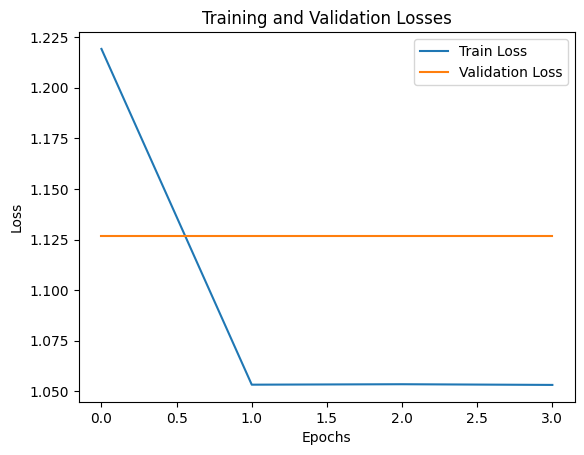

In [13]:
from tqdm import tqdm  # Used to display progress bars

# Training function
def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    
    # Display progress bar using tqdm
    for batch in tqdm(train_loader, desc="Training", total=total_iter):
        # Forward pass
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Parameter update
        optim.step()
        scheduler.step()
 
        iter_num += 1
        if iter_num % 100 == 0:
            print("Epoch: %d, Iteration: %d, Loss: %.4f, %.2f%%" % (epoch,
                            iter_num, loss.item(), iter_num/total_iter*100))
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Save training loss
    print("Epoch: %d, Average training loss: %.4f" % (epoch, avg_train_loss))

# Validation function
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in tqdm(test_dataloader, desc="Validating", total=len(test_dataloader)):
        with torch.no_grad():
            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]
        
        # Calculate total loss
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()  # Move logits to CPU and convert to numpy array
        label_ids = labels.to('cpu').numpy()  # Move true labels to CPU and convert to numpy array
        # Calculate accuracy using flat_accuracy function
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    
    # Save validation loss
    val_losses.append(avg_val_loss)
    
    print("Validation Accuracy: %.4f" % (avg_val_accuracy))
    print("Average Validation Loss: %.4f" % (avg_val_loss))
    print("-------------------------------")

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Execute training and validation
for epoch in range(4):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()


import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()


In [14]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm progress bar library

# Model prediction function
def predict():
    
    model.eval()
    predictions = []
    
    # Disable gradient calculations
    with torch.no_grad():
        # Initialize tqdm progress bar, setting the total steps to the total number of samples 
        #in the dataset
        with tqdm(total=len(test_df), desc="Predicting", ncols=100) as pbar:
            for batch in test_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs[0]
                
                # Get the predicted labels (based on the maximum value of the softmax output)
                predicted_labels = torch.argmax(logits, dim=-1).cpu().numpy()
                
                # Update predictions and progress bar
                predictions.extend(predicted_labels)
                pbar.update(len(predicted_labels))  # Update progress bar with the number 
                                                    # of predicted samples
    
    return predictions

# Data preprocessing and DataLoader setup
test_encodings = tokenizer(
    test_df['tokenized_text'].tolist(), 
    truncation=True, 
    padding=True, 
    max_length=64
)
test_dataset = NewsDataset(test_encodings, [0] * len(test_df))  # Create test dataset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Call the prediction function
predicted_labels = predict()

# Convert the predicted numerical labels back to the original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Add the prediction results to the DataFrame
test_df['predicted_labels'] = predicted_labels

# Save the prediction results to a CSV file
submission = test_df[['tweet_id', 'predicted_labels']].rename(columns={
    'tweet_id': 'id',
    'predicted_labels': 'emotion'
})
submission.to_csv('/kaggle/working/submission.csv', index=False)


Predicting: 100%|██████████████████████████████████████████| 411972/411972 [26:02<00:00, 263.68it/s]


In [15]:
submission

,id,emotion
0,0x28cc61,joy
1,0x2db41f,disgust
2,0x2466f6,disgust
3,0x23f9e9,sadness
4,0x1fb4e1,joy
...,...,...
411967,0x2c4dc2,surprise
411968,0x31be7c,anticipation
411969,0x1ca58e,sadness
411970,0x35c8ba,joy
